<a href="https://colab.research.google.com/github/xx529/Risk-Control-Detect/blob/main/final/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data
* 启示1：continuous_dti 缺失1行，可以选择舍该样本。
* 启示2：continuous_annual_inc_joint 与 continuous_dti_joint 缺失行数一致，可能存在某些关联。
* 启示3：启示2中的变量少于训练数据5%，可以考虑舍弃，也可以条件标记变量继续使用。

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

In [78]:
# train_raw = pd.read_csv('./train_final.csv')
train_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks Project/Risk Control & Detect/final/train_final.csv')
train_raw.head()

continuous_annual_inc  ...  discrete_term_2_one_hot
0                55000.0  ...                        0
1                65000.0  ...                        0
2                63000.0  ...                        1
3               104433.0  ...                        1
4                34000.0  ...                        0

[5 rows x 146 columns]

In [79]:
train_raw.info(max_cols=146)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 146 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   continuous_annual_inc                   50000 non-null  float64
 1   continuous_annual_inc_joint             220 non-null    float64
 2   continuous_delinq_2yrs                  50000 non-null  float64
 3   continuous_dti                          49999 non-null  float64
 4   continuous_dti_joint                    220 non-null    float64
 5   continuous_fico_range_high              50000 non-null  float64
 6   continuous_fico_range_low               50000 non-null  float64
 7   continuous_funded_amnt                  50000 non-null  float64
 8   continuous_funded_amnt_inv              50000 non-null  float64
 9   continuous_inq_last_6mths               50000 non-null  float64
 10  continuous_installment                  50000 non-null  f

In [80]:
label_col = 'loan_status'
continuous_features = [x for x in train_raw.columns if 'continuous' in x]
discrete_features = [x for x in train_raw.columns if 'discrete' in x]
null_features = [x for x in train_raw.columns if train_raw[x].isnull().any()]

len(continuous_features) + len(discrete_features) + 1

146

# EDA

## Distribution

### Label y

* 启示1：全部猜1的话至少也能有75%的准确率，模型准确率最低是75%的标准

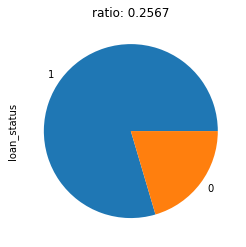

In [81]:
label_count = train_raw[label_col].value_counts()
label_count.plot(kind='pie', title='ratio: {:.4f}'.format(label_count[0] / label_count[1]))
plt.show()

### Continuous X
* 启示1：衍生变量 last_fico_range_high 与 last_fico_range_low 的差的值为499.0的值对标签 y 的区分能力强，原始数据1/4，在这个衍生变量下为1/10
* 启示2：continuous_fico_range_high 与 continuous_fico_range_low 基本上是按差值为4变化的。

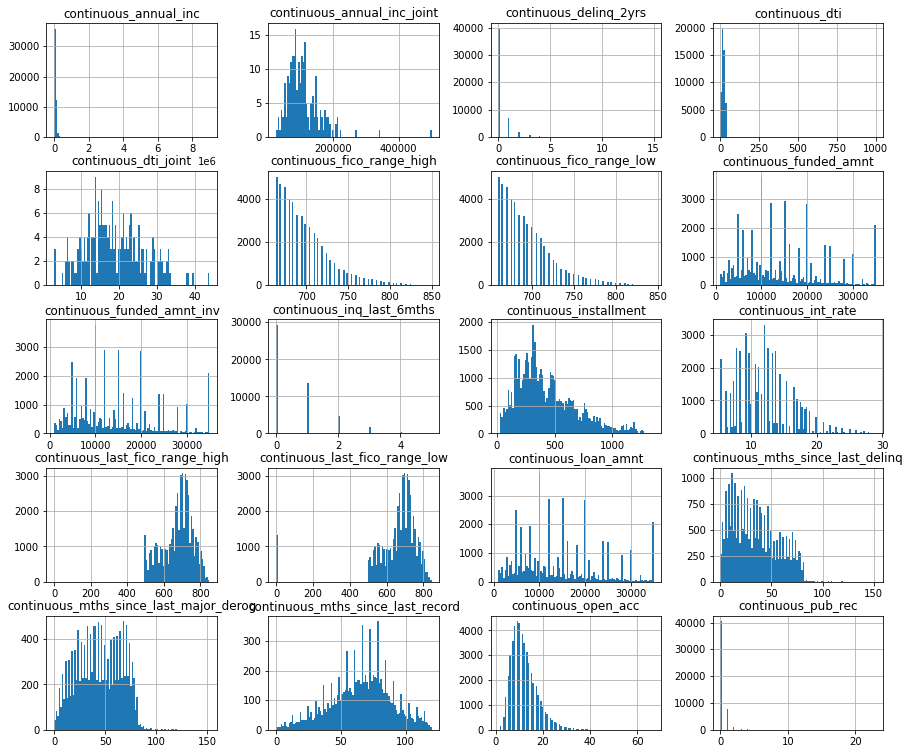

In [82]:
train_raw[continuous_features].hist(bins=100, figsize=(15, 13))
plt.show()

In [83]:
# 启示1
value_499_bool = (train_raw['continuous_last_fico_range_high'] - train_raw['continuous_last_fico_range_low']) == 499.0
train_raw[value_499_bool][label_col].value_counts()

0    1212
1     123
Name: loan_status, dtype: int64

In [84]:
# 启示2
(train_raw['continuous_fico_range_high'] - train_raw['continuous_fico_range_low']).value_counts()

4.0    49992
5.0        8
dtype: int64

### One Hot X
* 启示1：application_type、policy_code、pymnt_plan这三个离散变量分布极端，没有区分性，可以考虑舍弃。
* 启示2：annual_inc_joint 与 continuous_dti_joint 缺失的行正好是 application_type 为0的行，可以作为标记用。

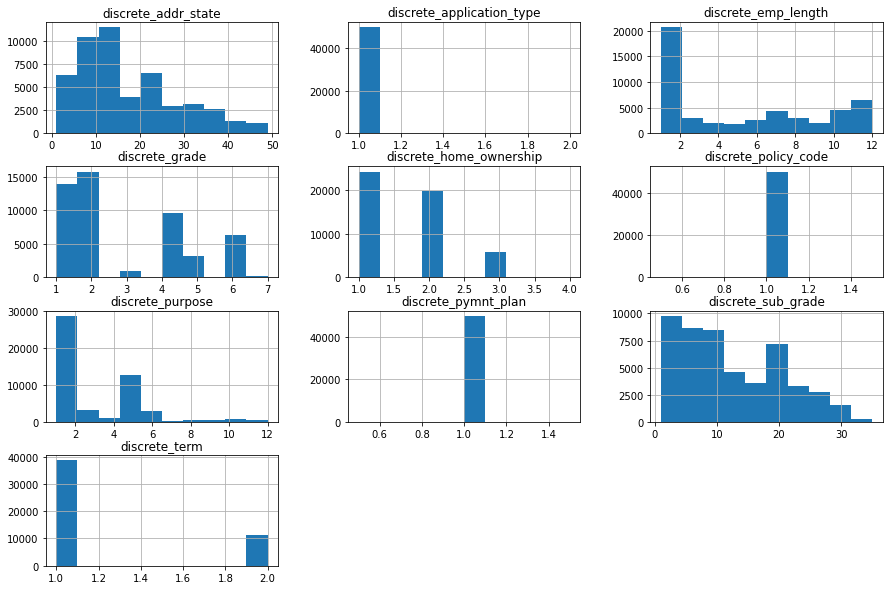

In [85]:
one_hot_name_dict = defaultdict(list)

for dis in discrete_features:
    dis_name = '_'.join(dis.split('_')[:-3])
    one_hot_name_dict[dis_name].append(dis)
    

df_dict = {}

for col in one_hot_name_dict:
    if len(one_hot_name_dict[col]) < 2:
        df_dict[col] = train_raw[one_hot_name_dict[col]].values.reshape(1, -1)[0]
    else:
        index = train_raw[one_hot_name_dict[col]].values.argmax(axis=1) + 1
        df_dict[col] = index

one_hot_raw = pd.DataFrame(df_dict)
one_hot_raw.hist(figsize=(15, 10)) 
plt.show()

In [86]:
# 启示1
print(train_raw['discrete_application_type_1_one_hot'].sum())
print(train_raw['discrete_policy_code_1_one_hot'].sum())
print(train_raw['discrete_pymnt_plan_1_one_hot'].sum())

49780
50000
50000


In [87]:
# 启示2
print((train_raw['continuous_annual_inc_joint'].isnull().astype(int) == train_raw['discrete_application_type_1_one_hot']).all())
print((train_raw['continuous_dti_joint'].isnull().astype(int) == train_raw['discrete_application_type_1_one_hot']).all())

True
True


## Correlation

### Among Continuous X

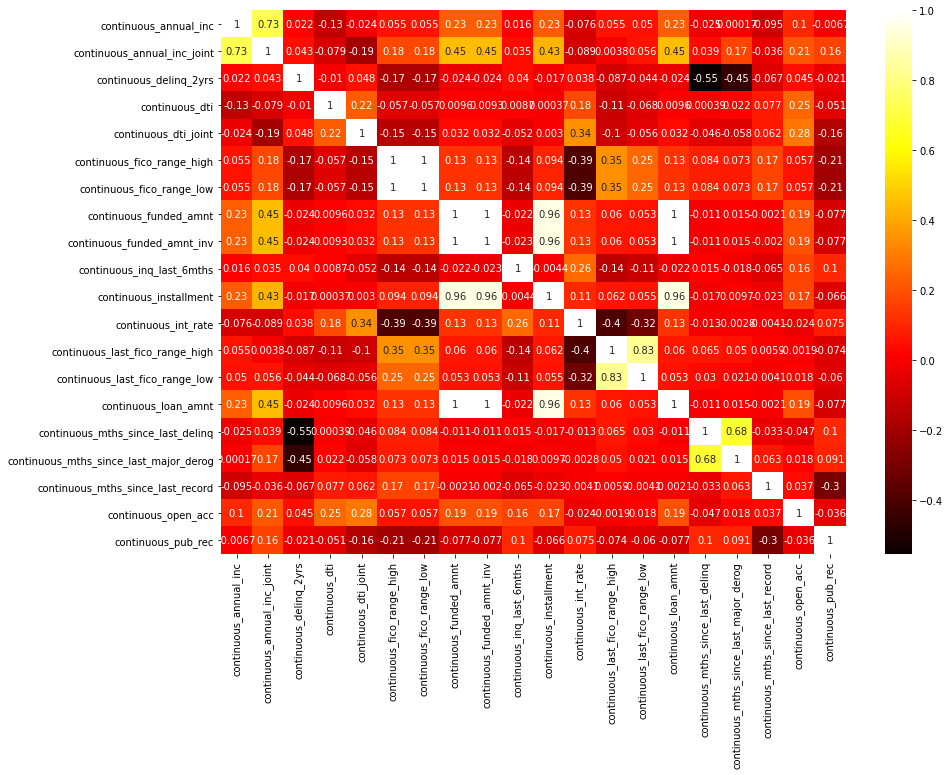

threshold over 0.6


['0.73 :continuous_annual_inc  with  continuous_annual_inc_joint',
 '1.00 :continuous_fico_range_high  with  continuous_fico_range_low',
 '1.00 :continuous_funded_amnt  with  continuous_funded_amnt_inv',
 '0.96 :continuous_funded_amnt  with  continuous_installment',
 '1.00 :continuous_funded_amnt  with  continuous_loan_amnt',
 '0.96 :continuous_funded_amnt_inv  with  continuous_installment',
 '1.00 :continuous_funded_amnt_inv  with  continuous_loan_amnt',
 '0.96 :continuous_installment  with  continuous_loan_amnt',
 '0.83 :continuous_last_fico_range_high  with  continuous_last_fico_range_low',
 '0.68 :continuous_mths_since_last_delinq  with  continuous_mths_since_last_major_derog']

In [88]:
plt.figure(figsize=(14, 10))
cross = train_raw[continuous_features].corr()
sns.heatmap(cross, cmap='hot', annot=True)
plt.show()

threshold = 0.6
over_threshold_pair = []
pair_result = np.where((cross.values < -threshold) | (cross.values > threshold))

for i, j in zip(pair_result[0], pair_result[1]):
    if i == j or (j, i) in over_threshold_pair:
        pass
    else:
        over_threshold_pair.append((i, j))

        
print('threshold over {}'.format(threshold))
columns_pair = ['{:.2f} :{}  with  {}'.format(cross.loc[cross.columns[x], cross.columns[y]], cross.columns[x], cross.columns[y]) for x, y in over_threshold_pair]
columns_pair

### Among Discrete X

In [89]:
for idx in range(len(one_hot_raw.columns[:-1])):
    print('-'*60)
    if one_hot_raw.iloc[:,idx].nunique() > one_hot_raw.iloc[:,idx+1].nunique():
        print(pd.crosstab(one_hot_raw.iloc[:,idx], one_hot_raw.iloc[:,idx+1]))
    else:
        print(pd.crosstab(one_hot_raw.iloc[:,idx+1], one_hot_raw.iloc[:,idx]))

------------------------------------------------------------
discrete_application_type     1   2
discrete_addr_state                
1                          1683  11
2                            99   1
3                          1938   6
4                          1661   8
5                           897   3
6                           610   3
7                           220   0
8                          1374   4
9                          6838  31
10                         1432   3
11                         1252   5
12                          844   4
13                         1176   4
14                         4074  11
15                         4132  24
16                          407   1
17                          290   0
18                          620   5
19                          962   7
20                         1669   7
21                          569   1
22                         3551  18
23                         1039   2
24                         1342   4
25 

### Null X And Y
* 启示1：单变量缺失与不缺失对y的区分程度大致相同。

In [90]:
df_null = train_raw[null_features].isnull().astype(int)
df_null[label_col] = train_raw[label_col]

for col in df_null:
    print('-'*60)
    cro_tab = pd.crosstab(df_null[col], df_null[label_col])
    cro_tab['ratio'] = cro_tab[0] / cro_tab[1]
    print(cro_tab)

------------------------------------------------------------
loan_status                      0      1     ratio
continuous_annual_inc_joint                        
0                               57    163  0.349693
1                            10155  39625  0.256278
------------------------------------------------------------
loan_status         0      1     ratio
continuous_dti                        
0               10212  39787  0.256667
1                   0      1  0.000000
------------------------------------------------------------
loan_status               0      1     ratio
continuous_dti_joint                        
0                        57    163  0.349693
1                     10155  39625  0.256278
------------------------------------------------------------
loan_status                           0      1     ratio
continuous_mths_since_last_delinq                       
0                                  5495  20588  0.266903
1                                  4717  

### Between X and Y

* 启示1：continuous_last_fico_range_low 大于 750左右 的区间对 y 有很好的分辨能力

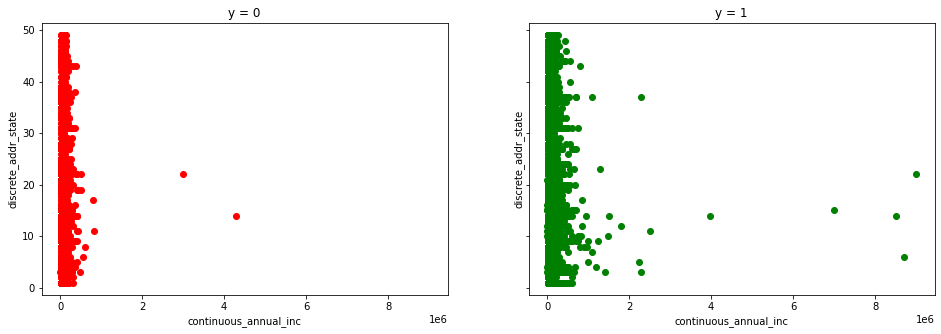

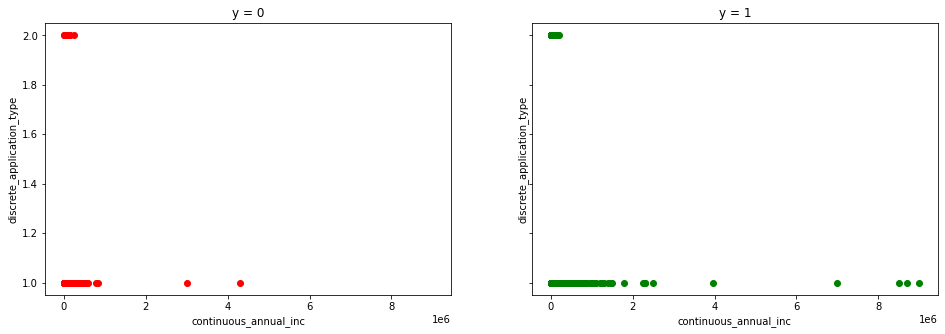

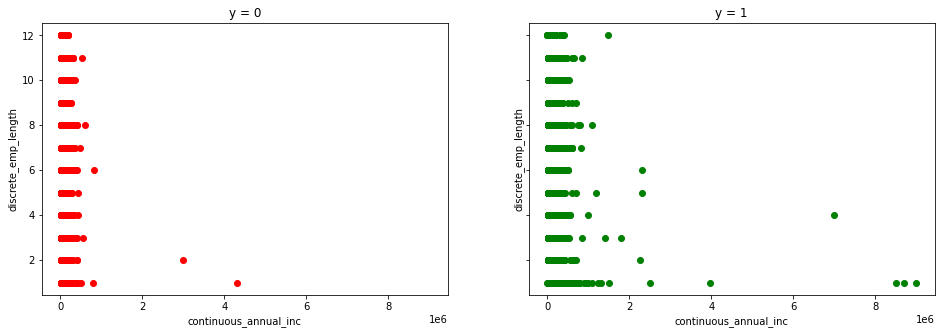

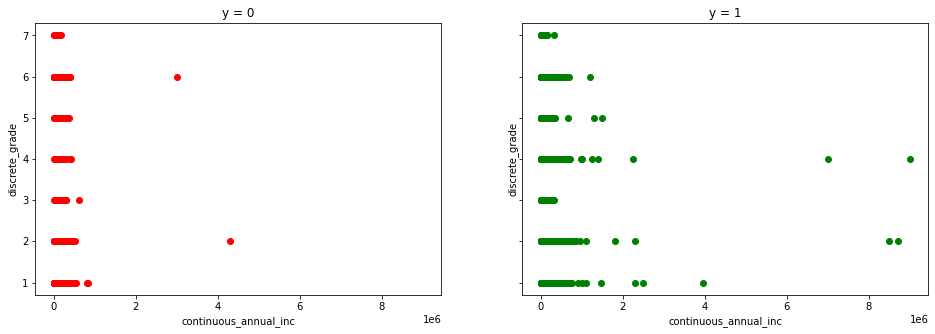

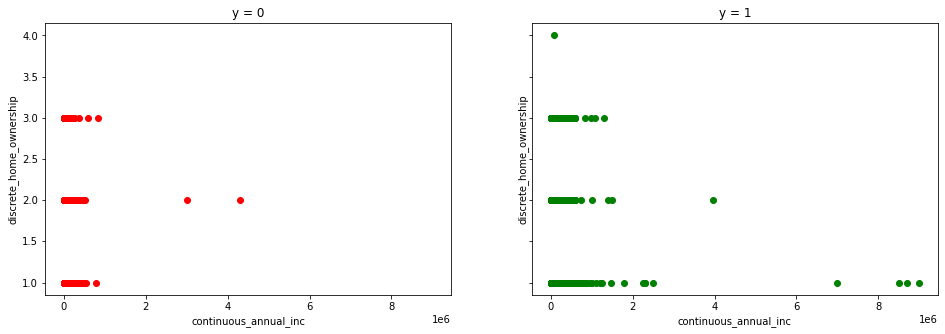

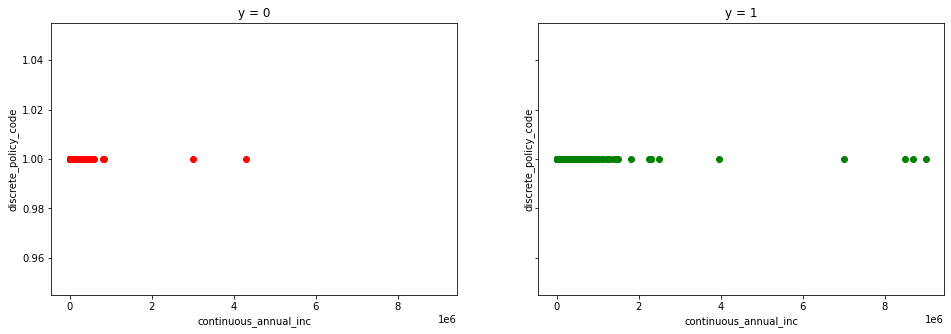

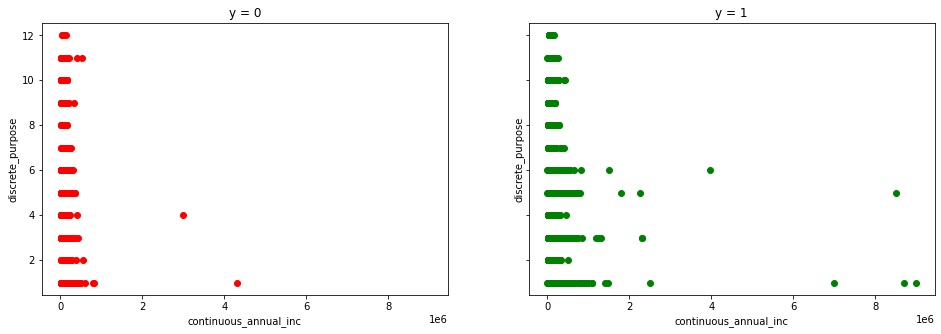

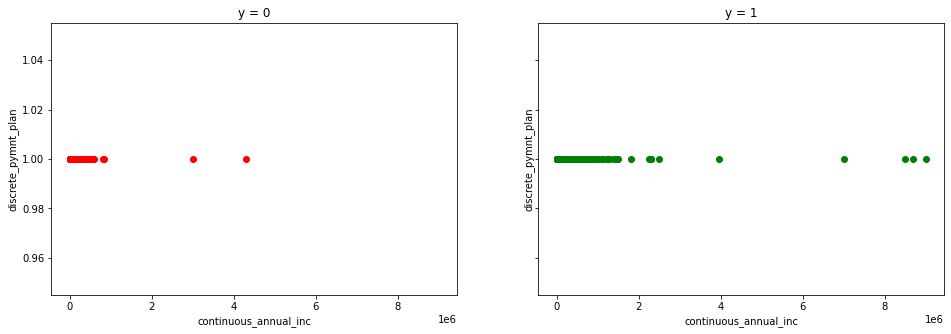

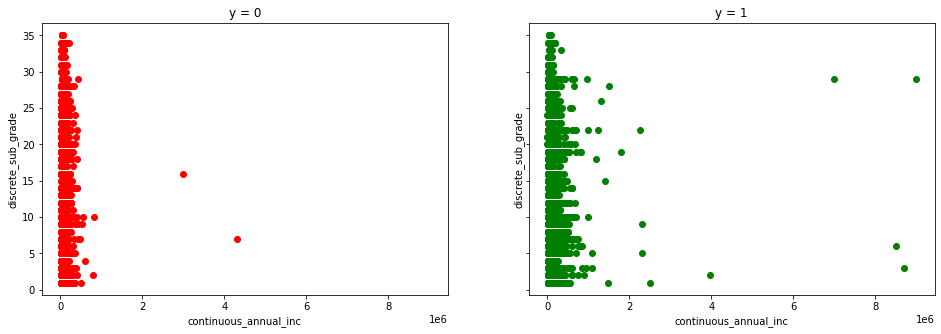

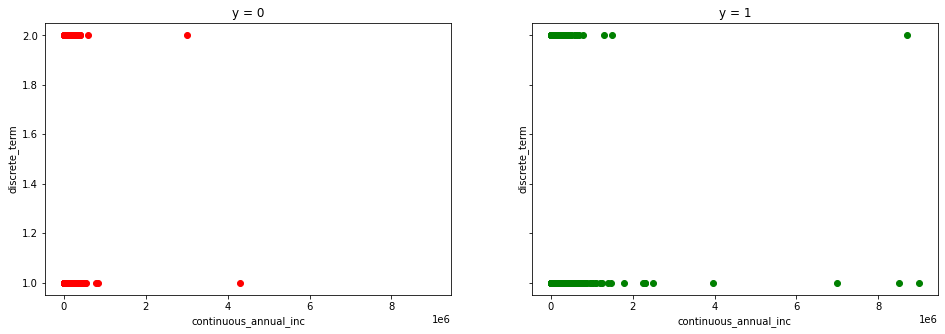

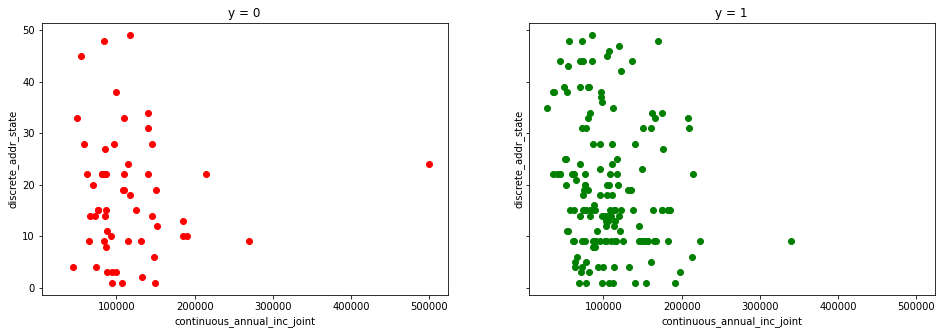

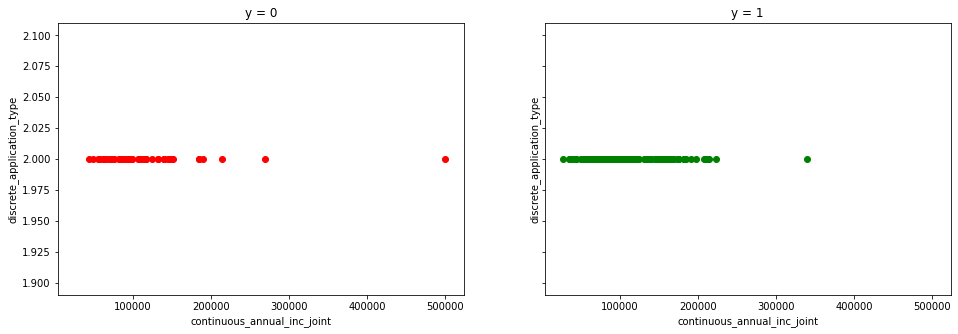

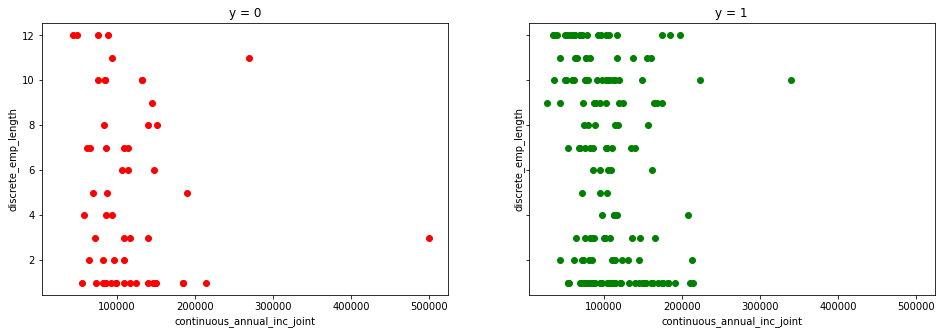

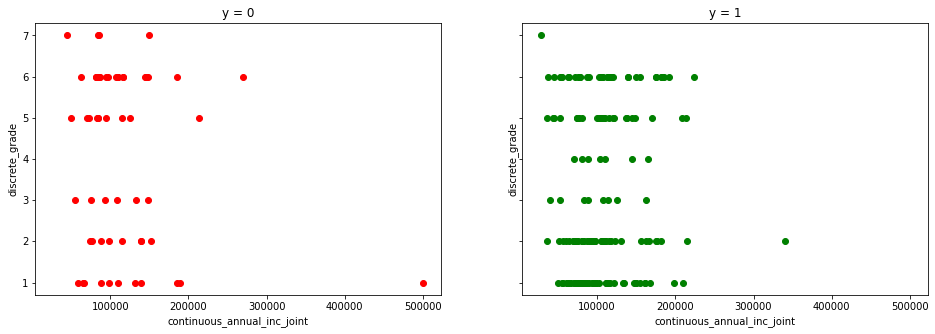

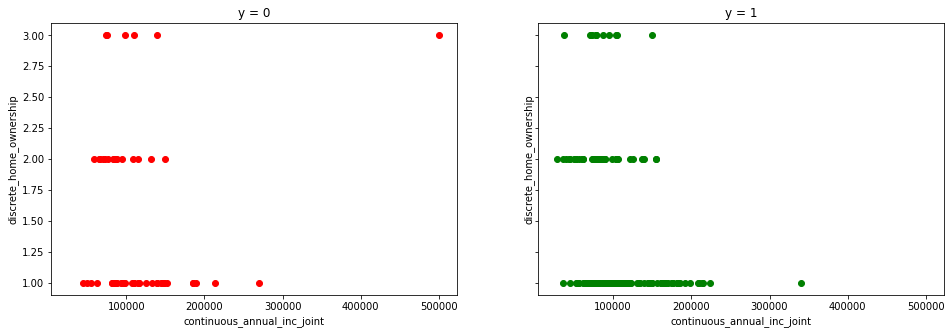

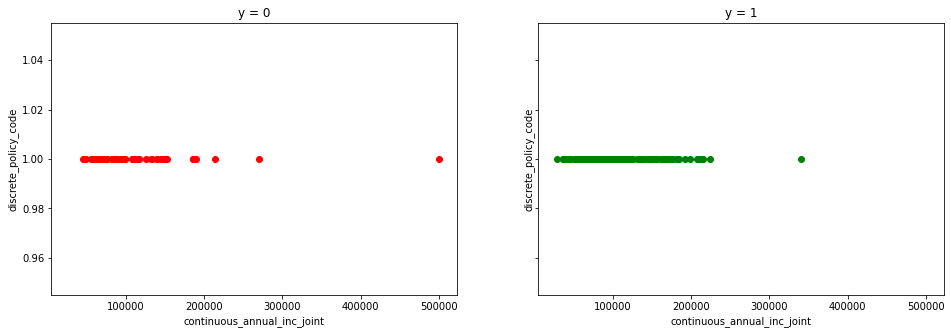

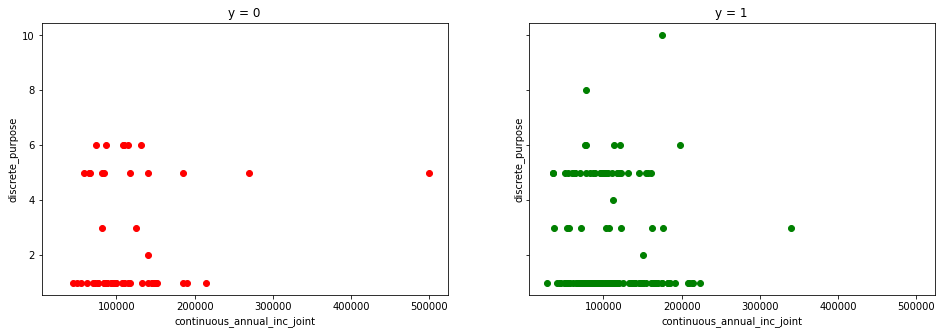

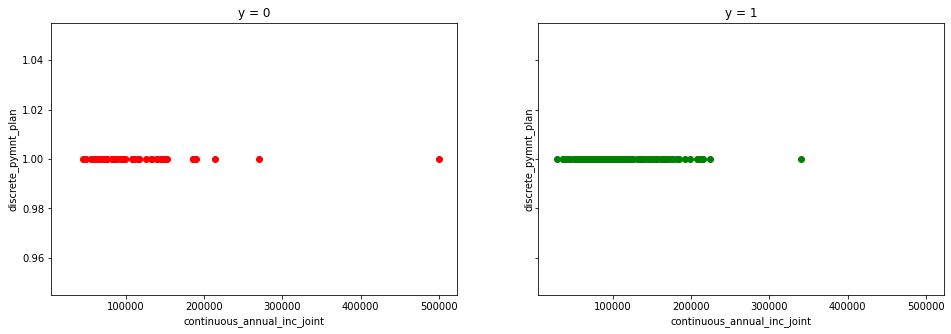

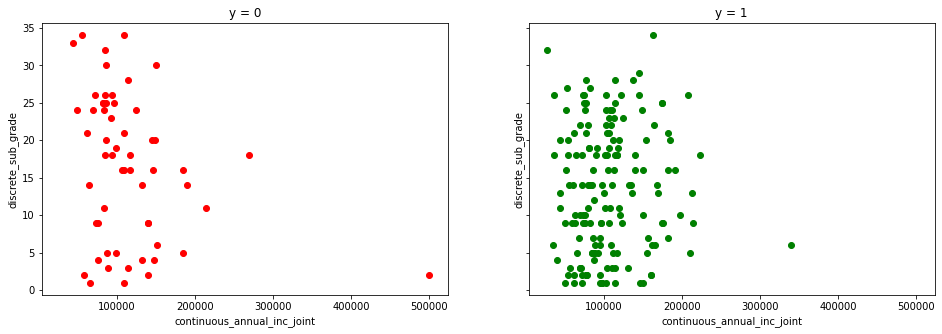

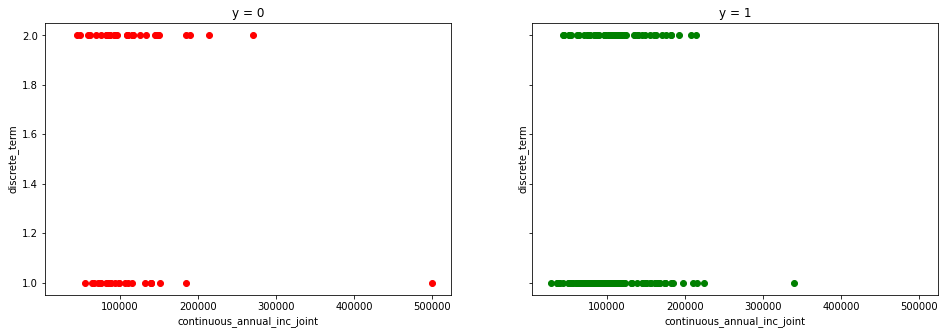

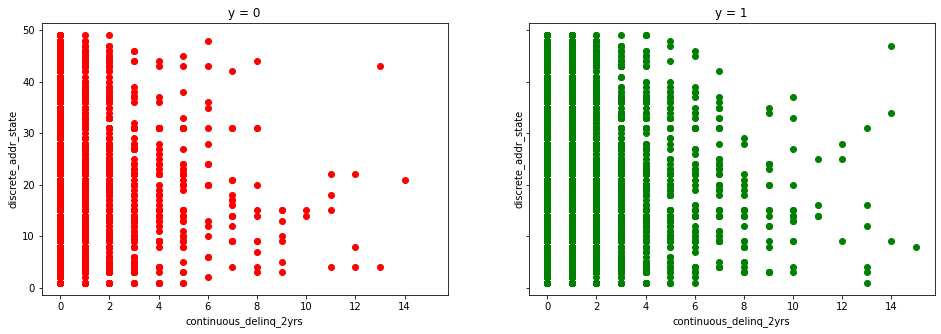

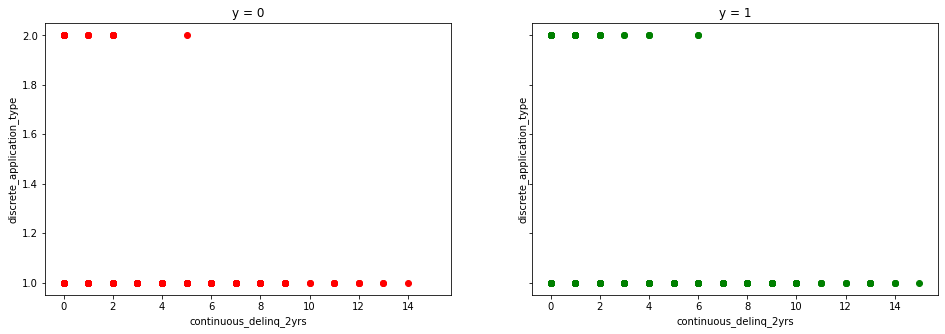

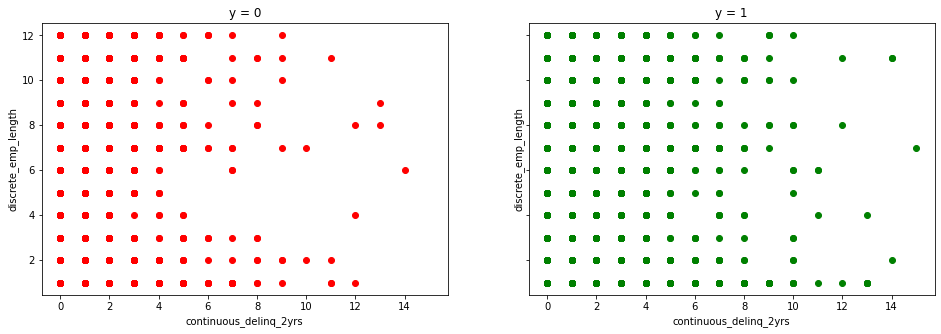

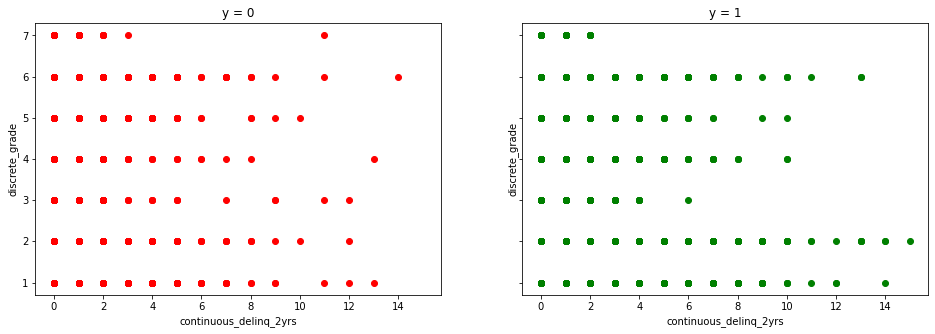

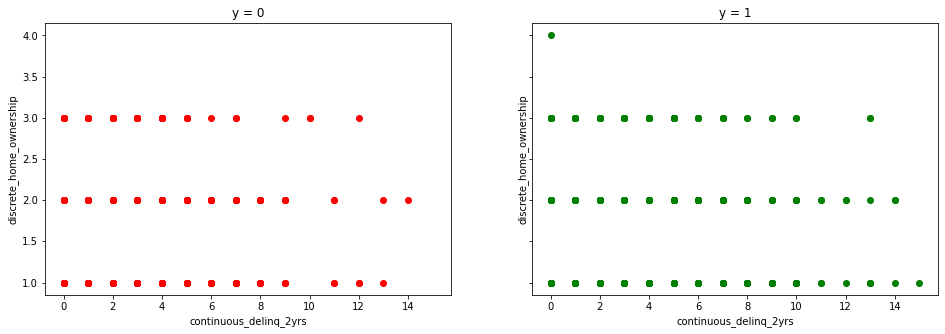

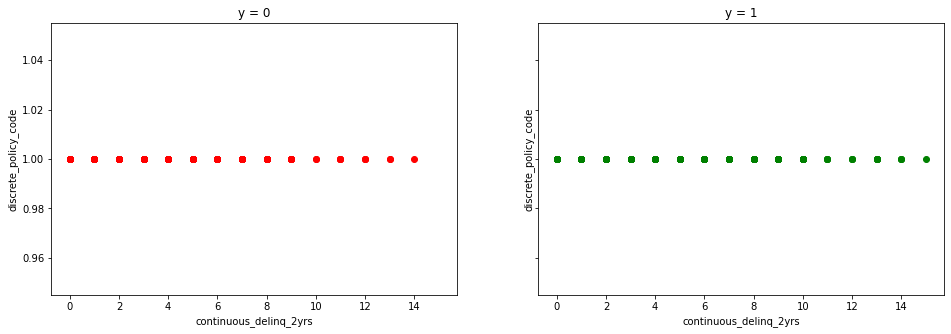

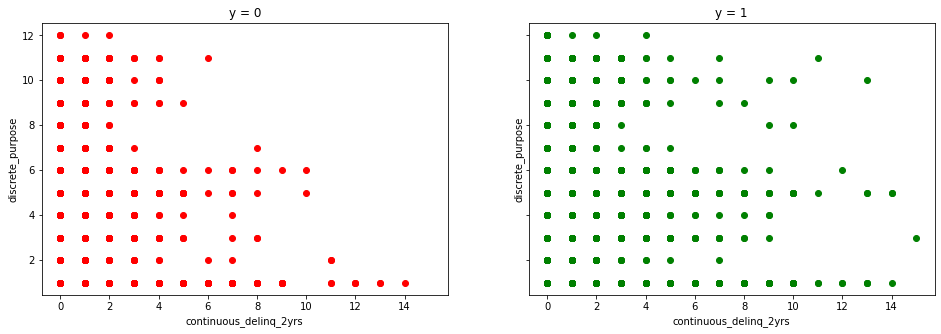

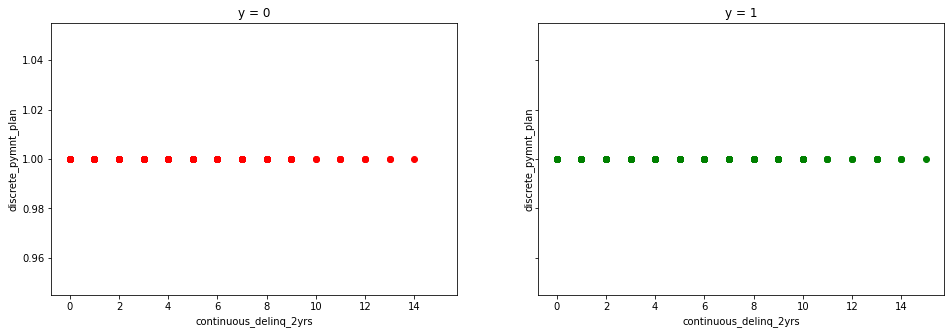

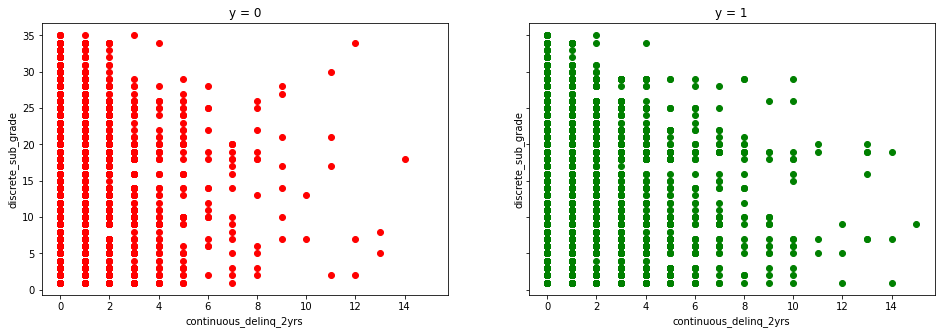

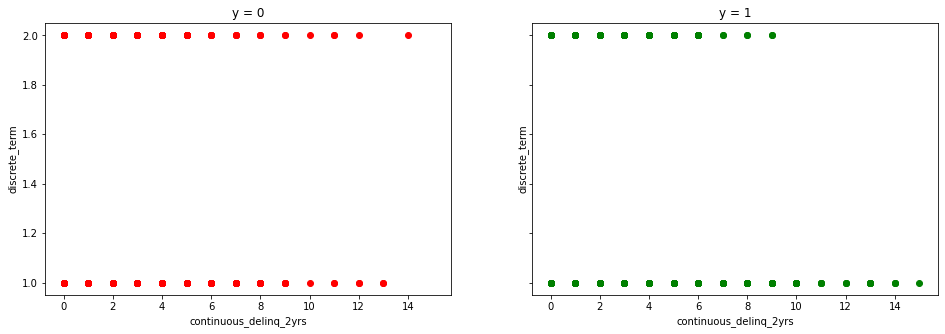

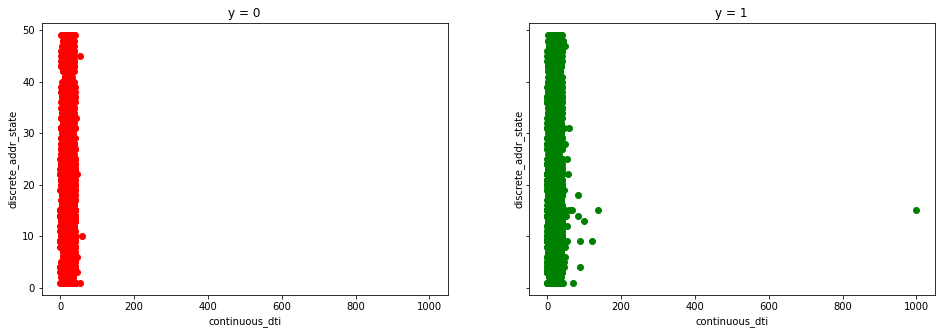

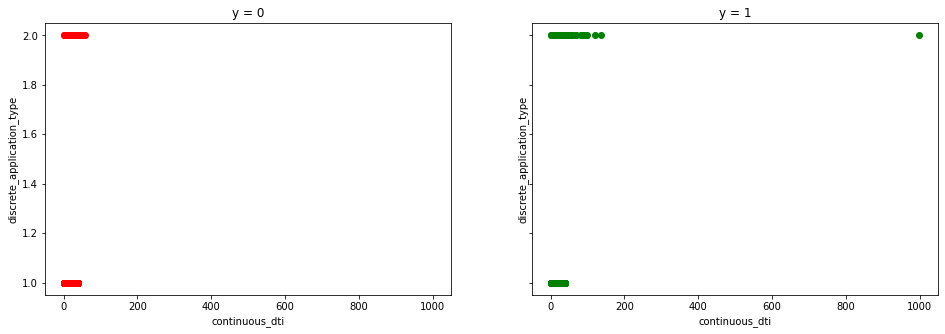

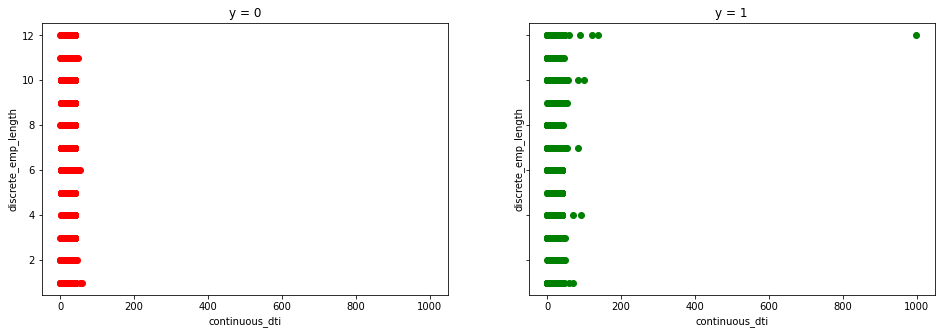

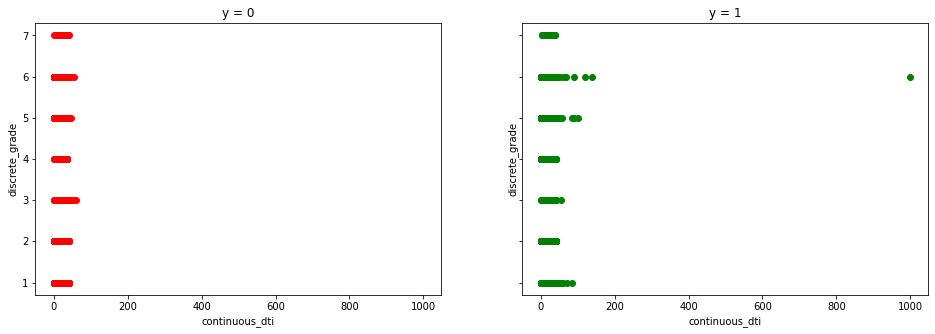

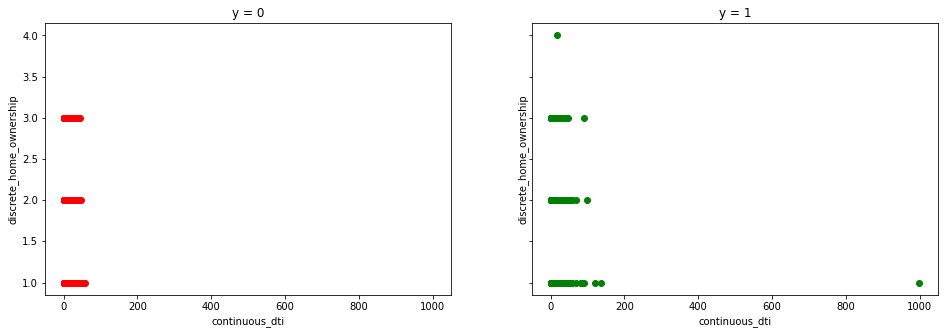

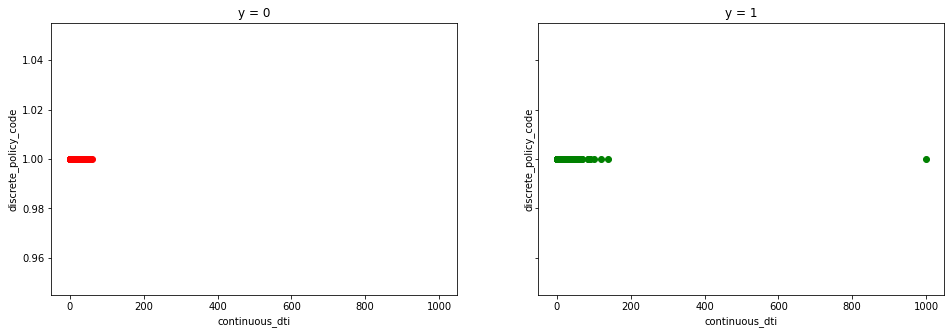

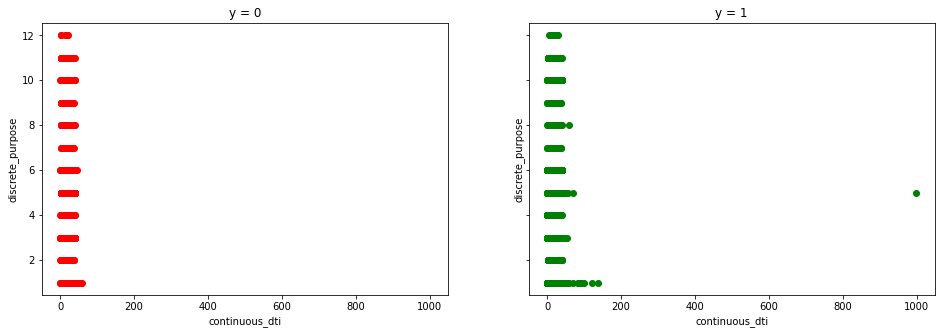

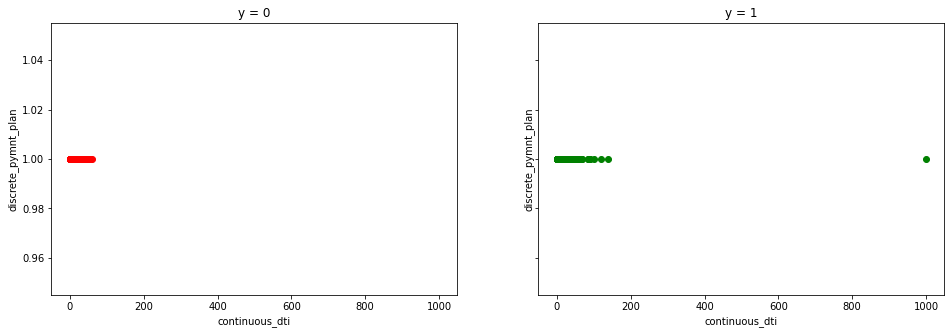

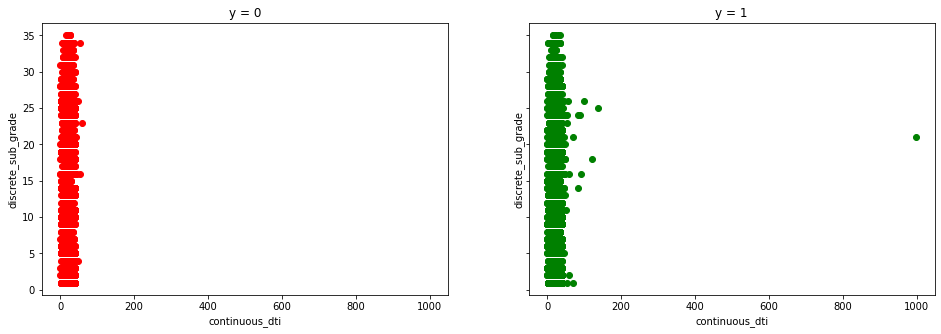

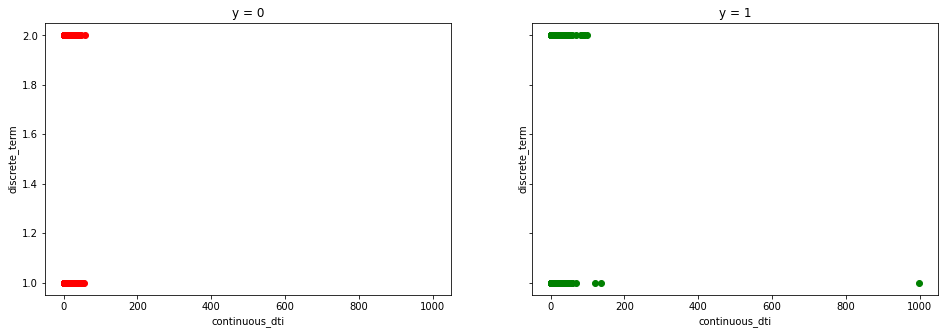

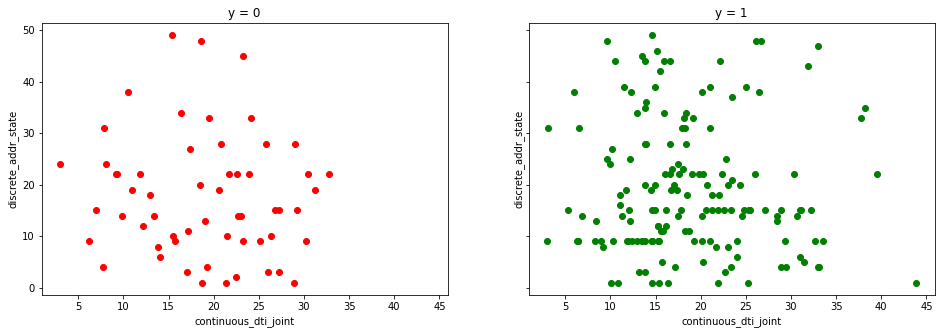

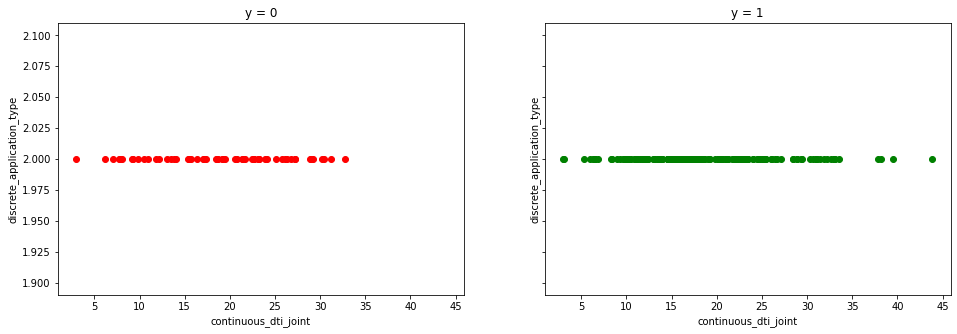

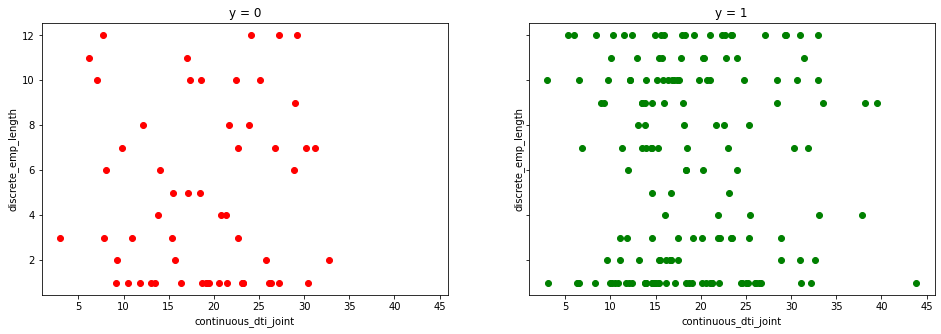

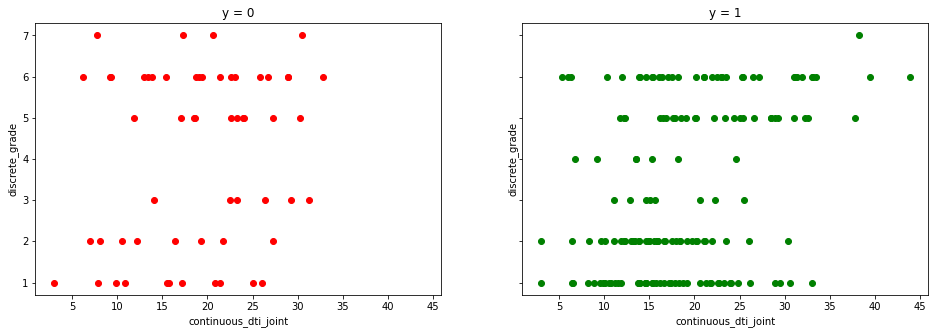

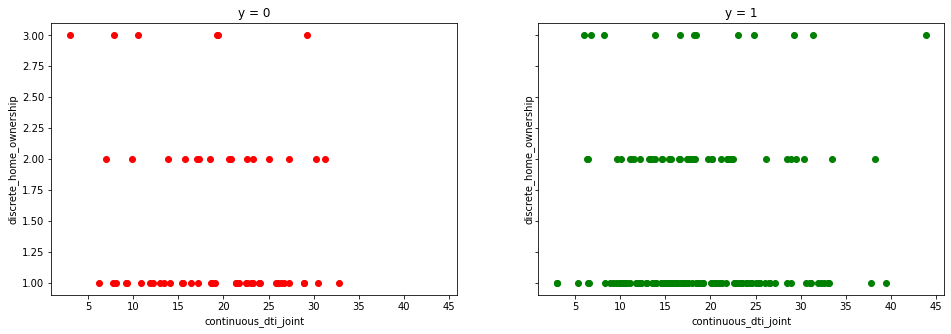

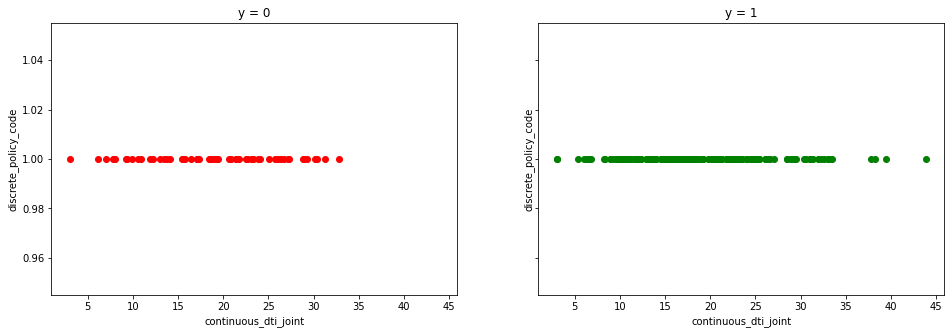

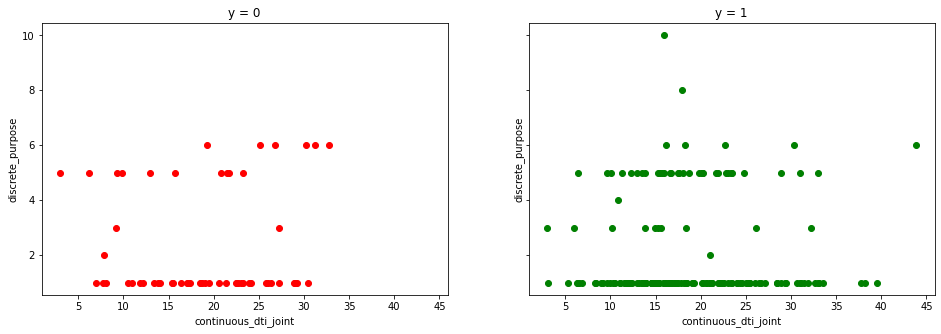

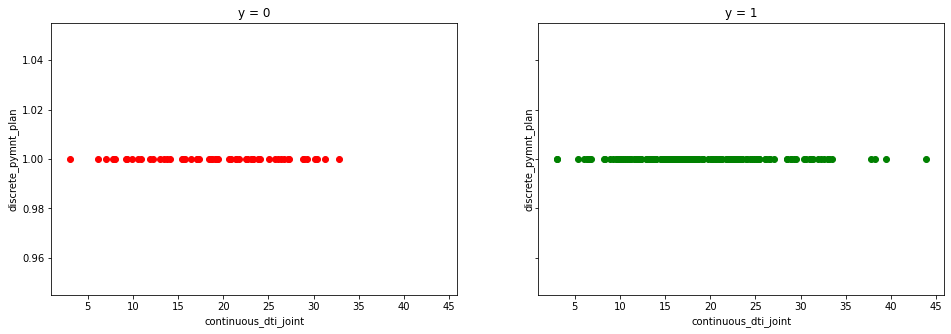

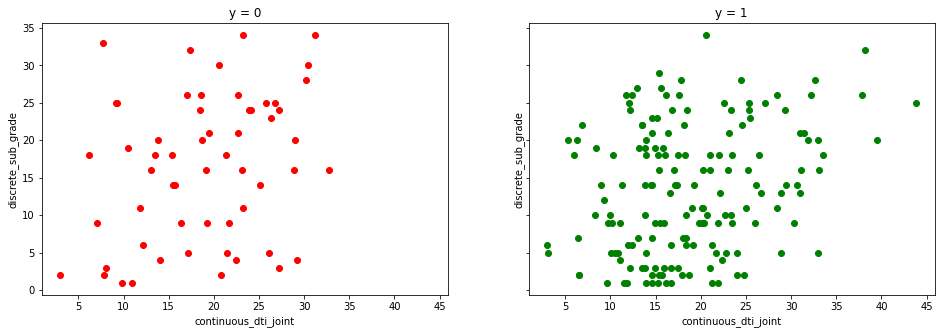

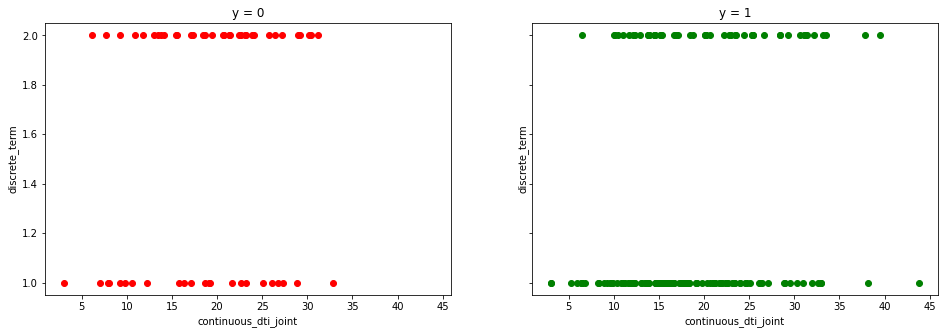

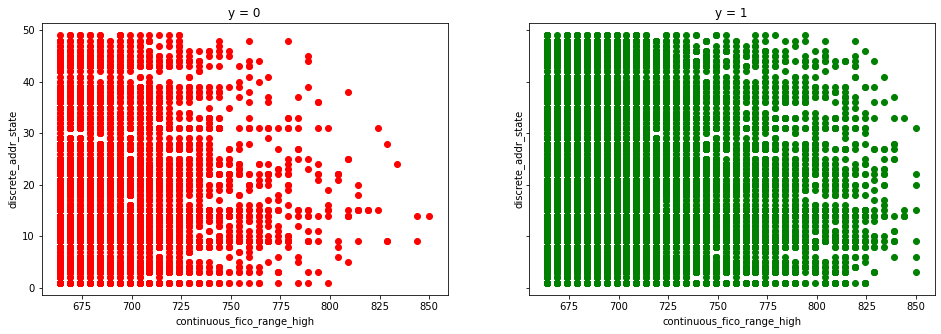

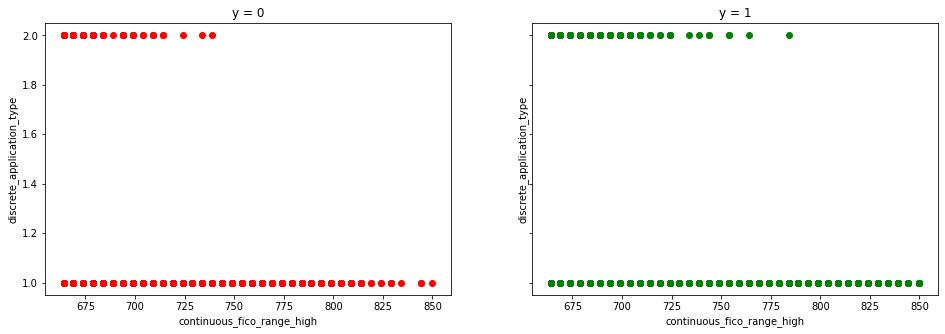

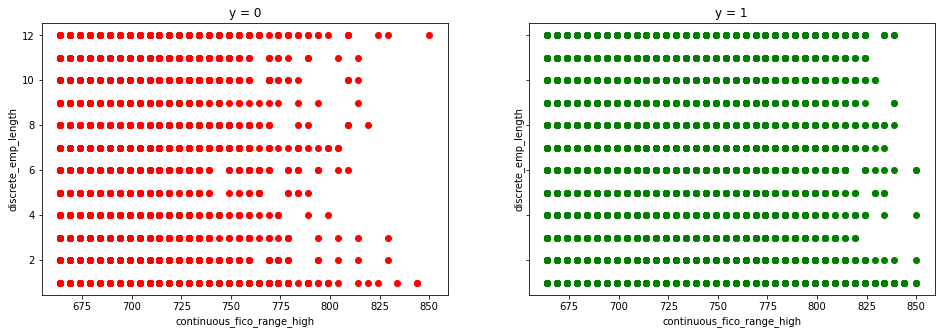

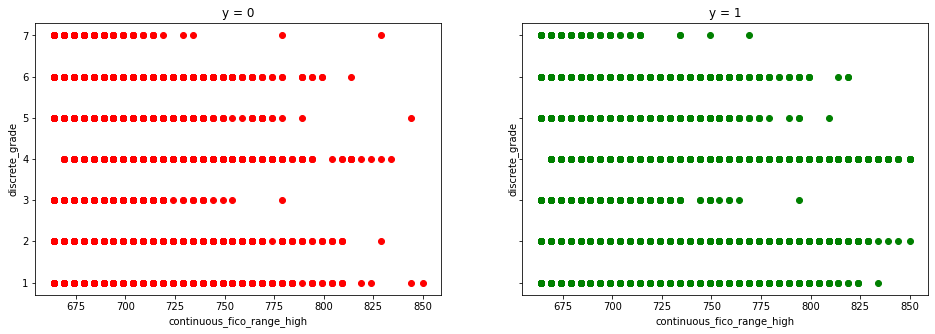

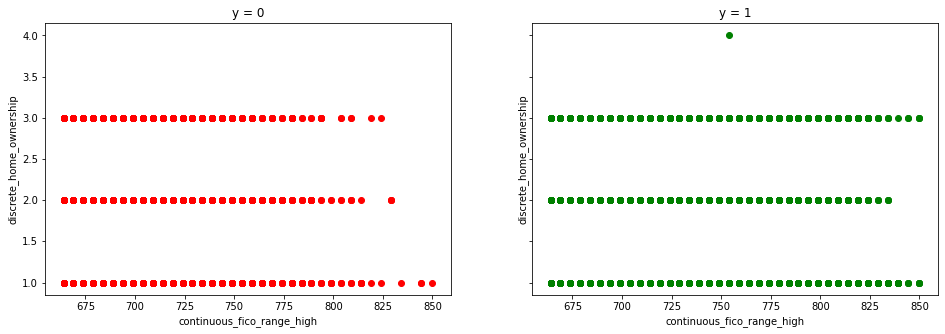

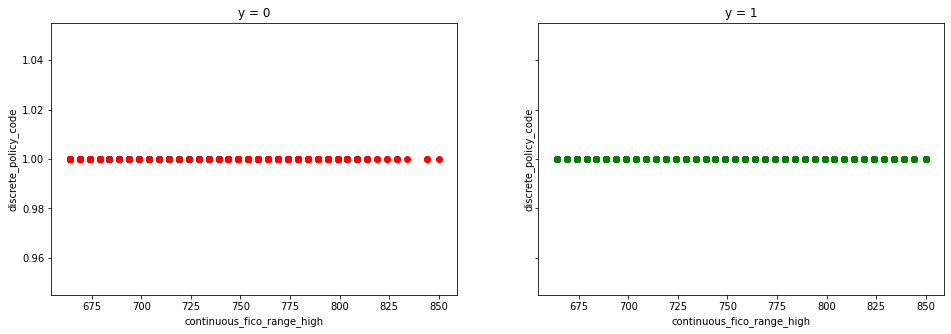

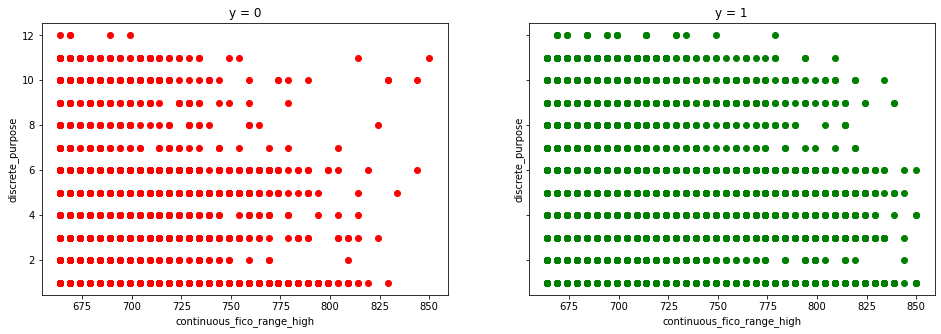

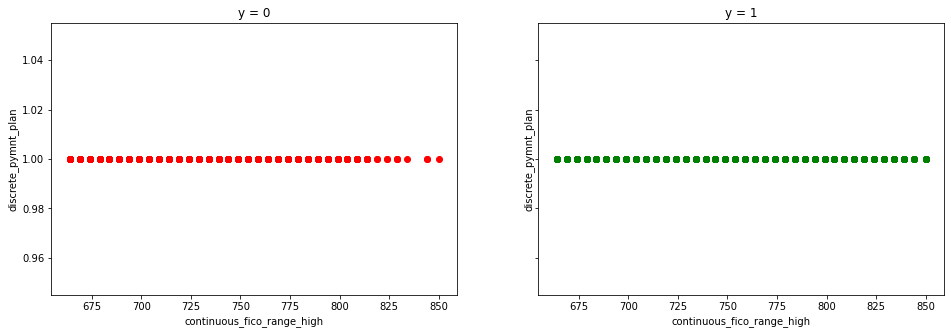

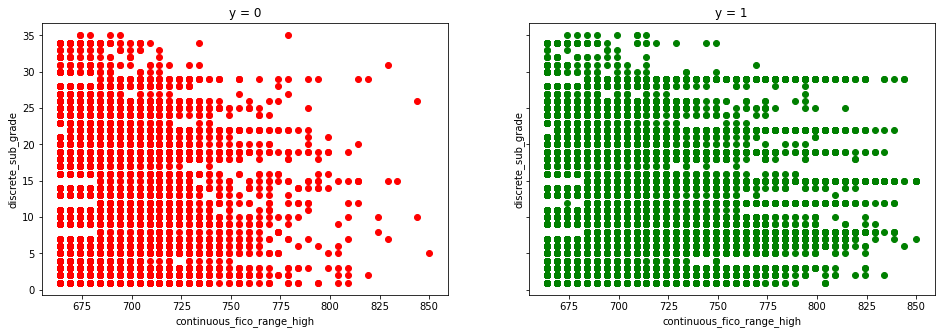

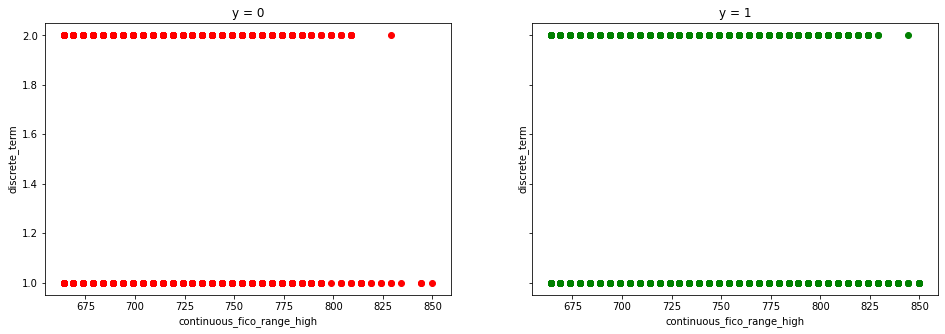

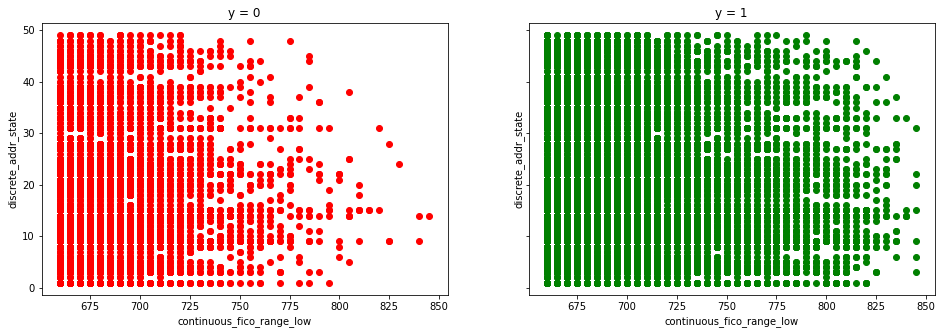

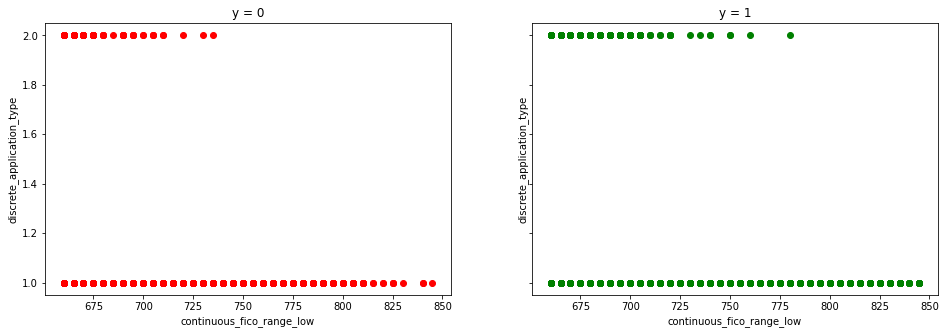

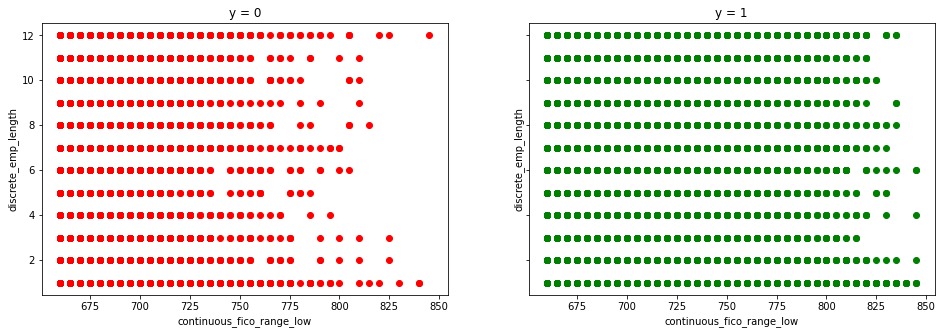

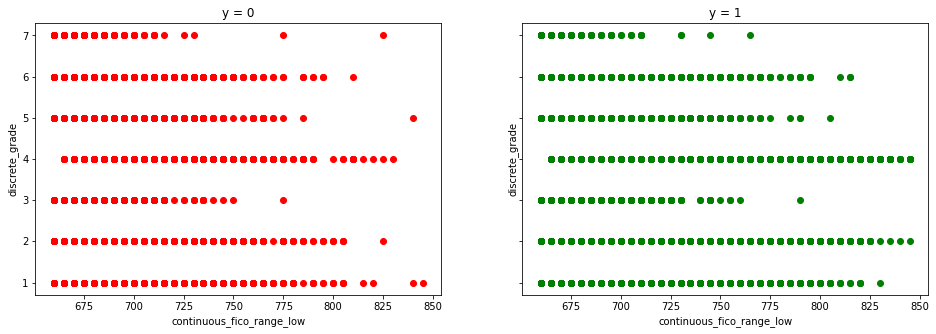

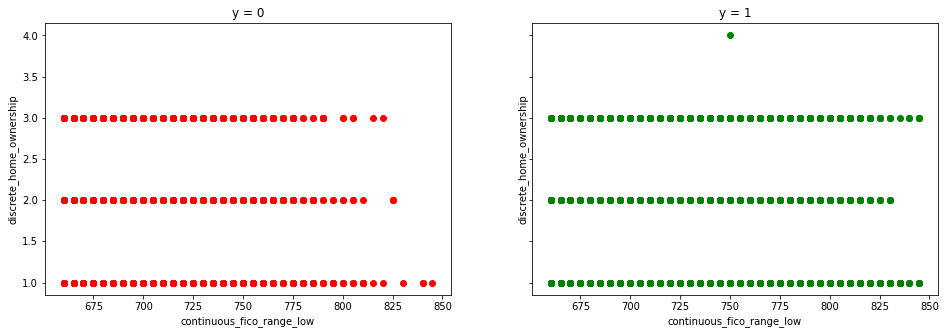

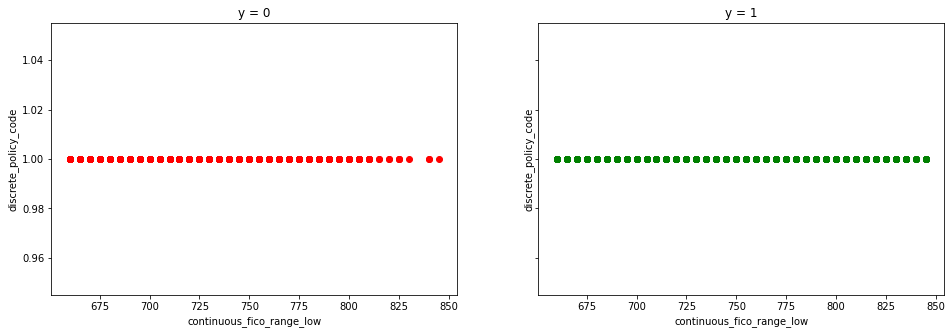

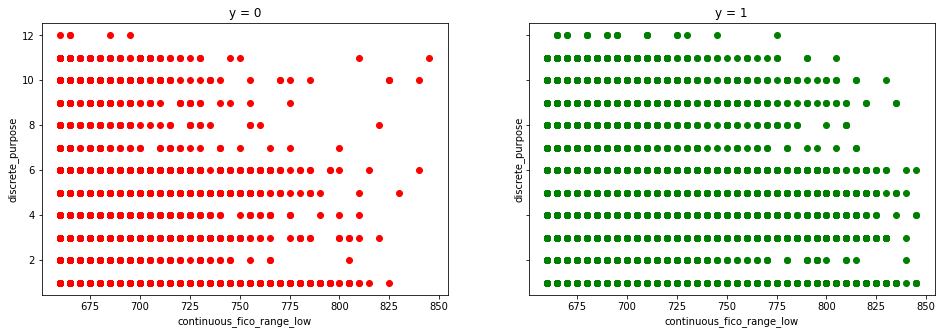

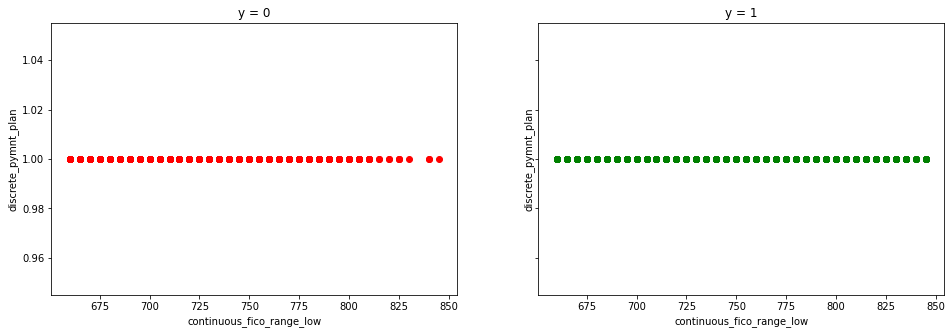

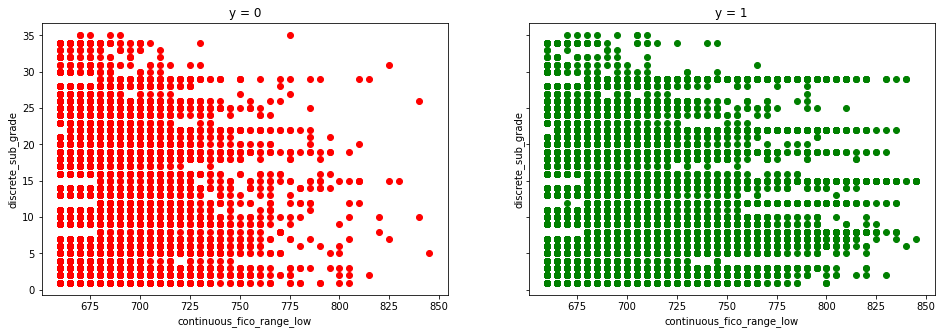

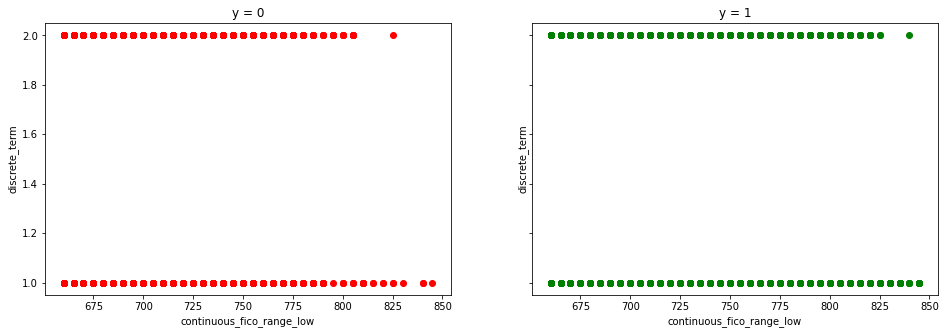

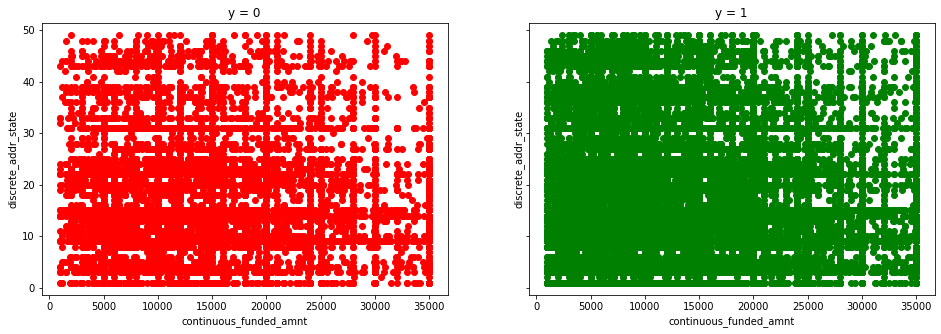

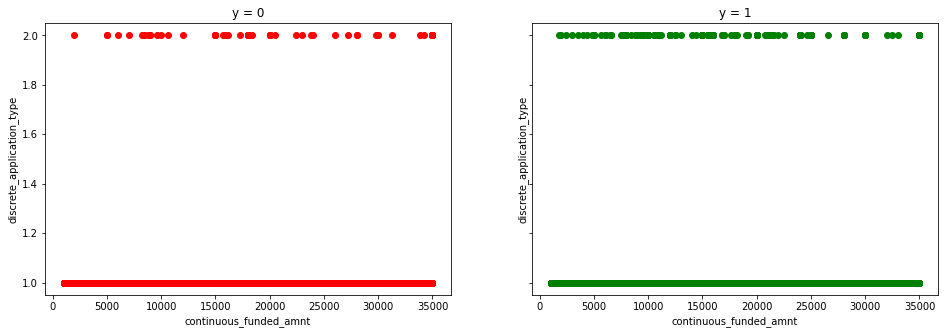

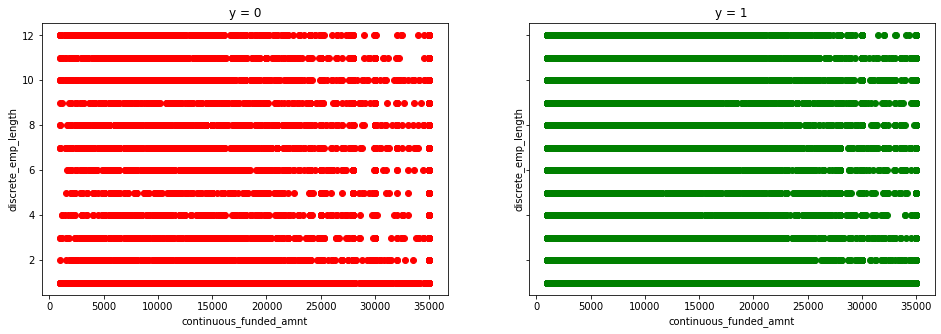

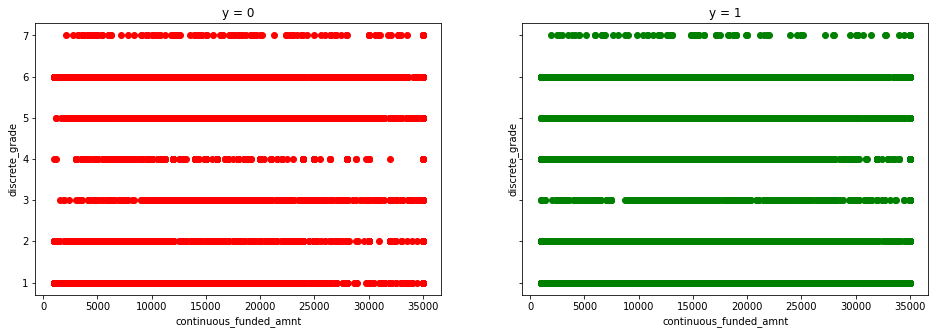

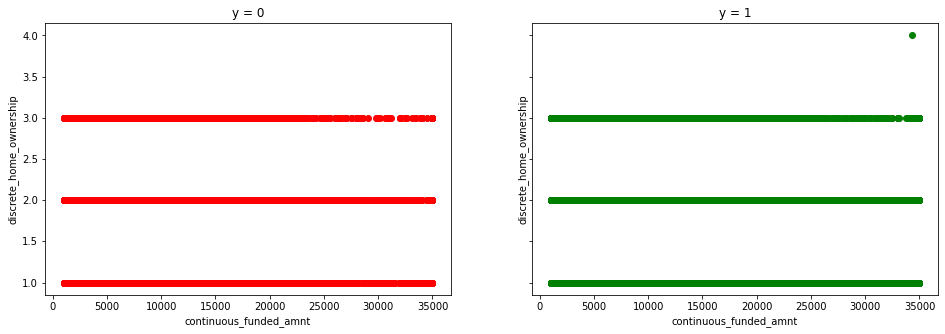

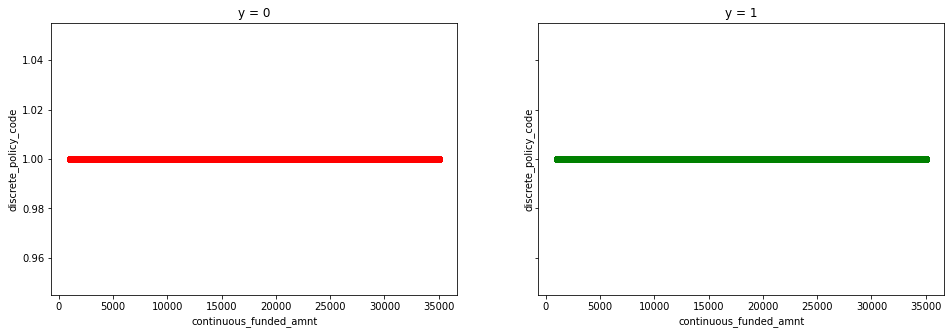

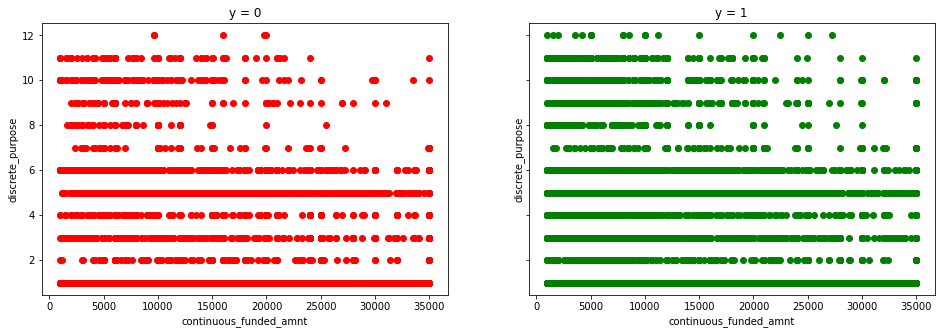

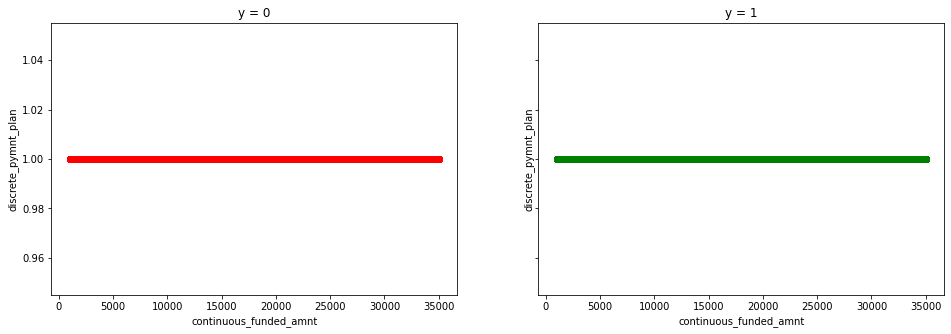

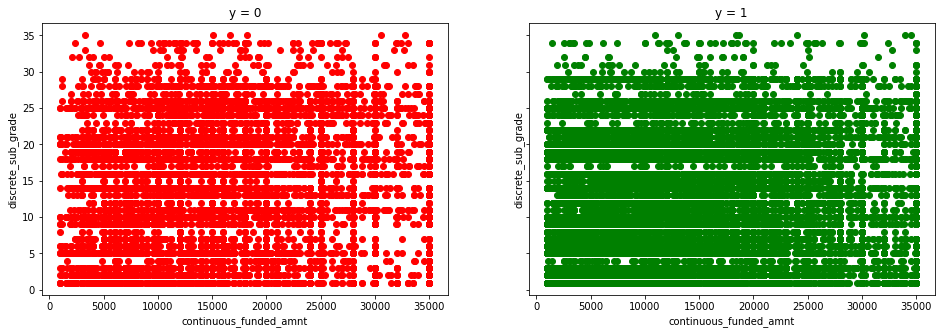

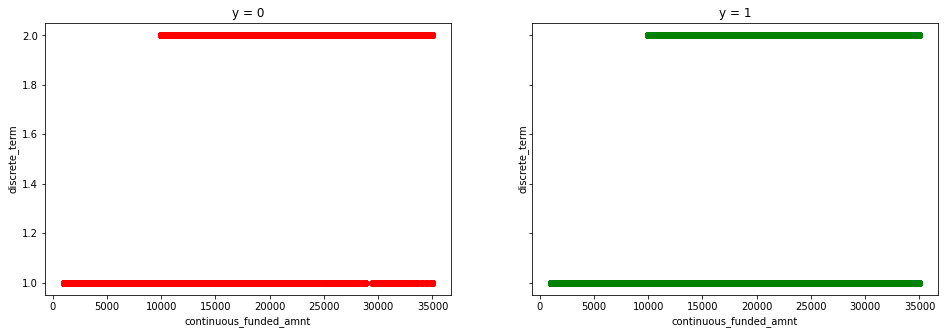

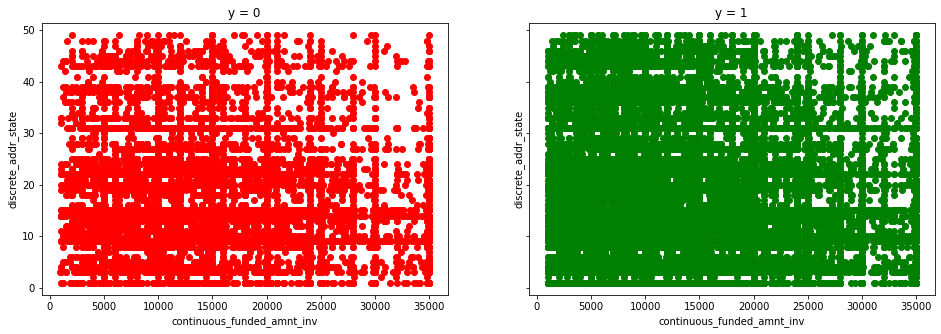

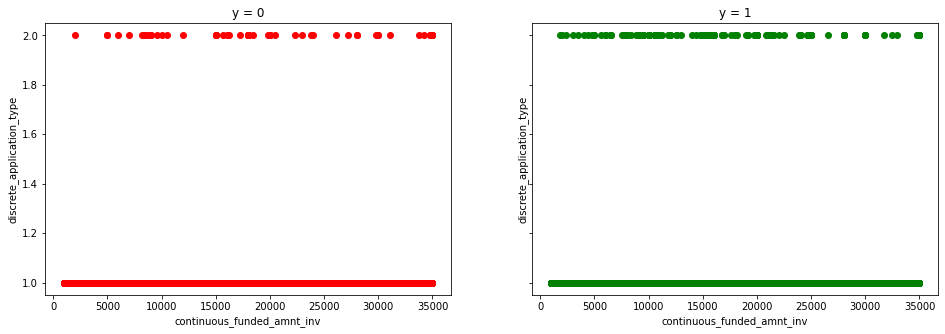

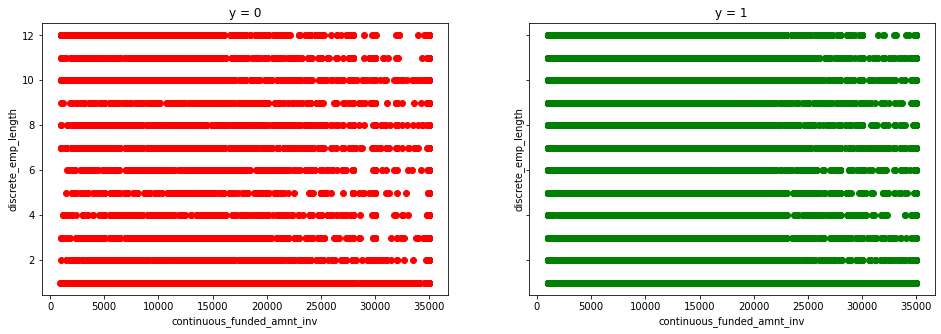

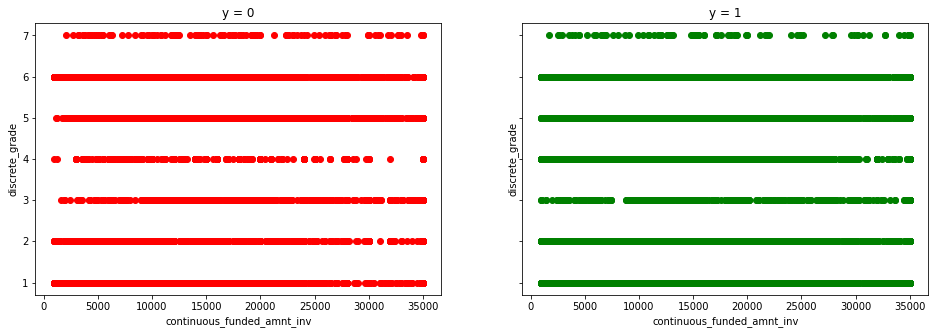

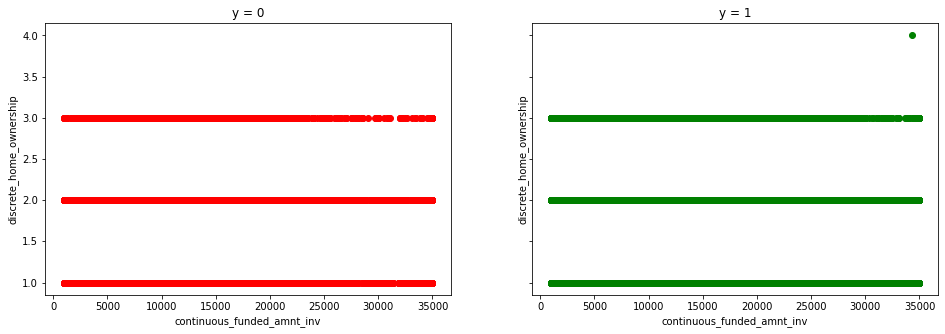

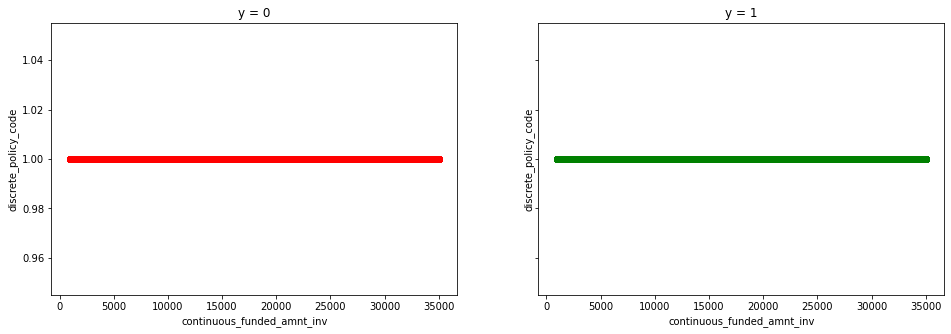

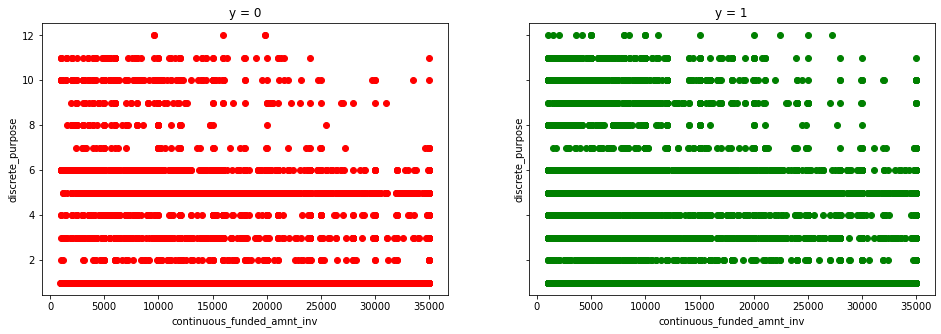

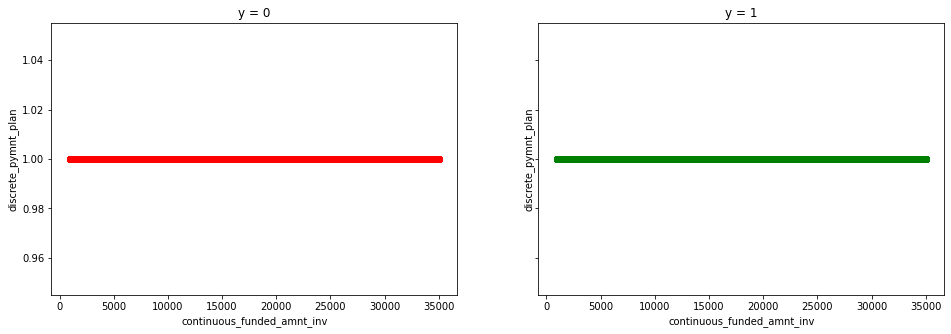

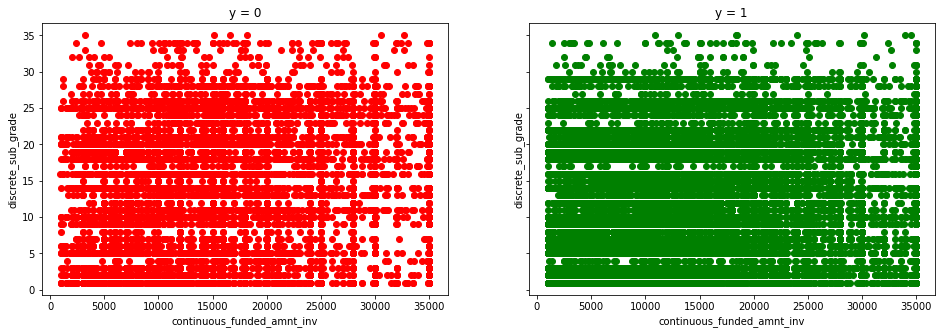

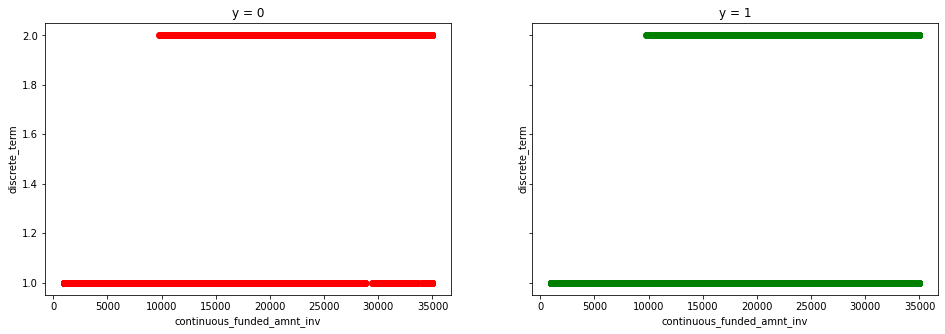

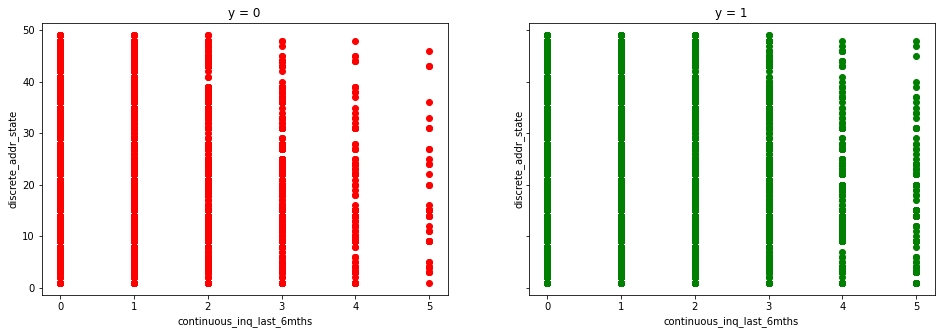

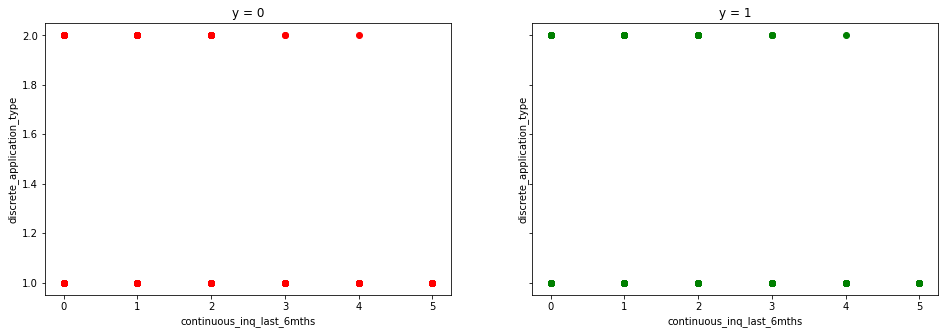

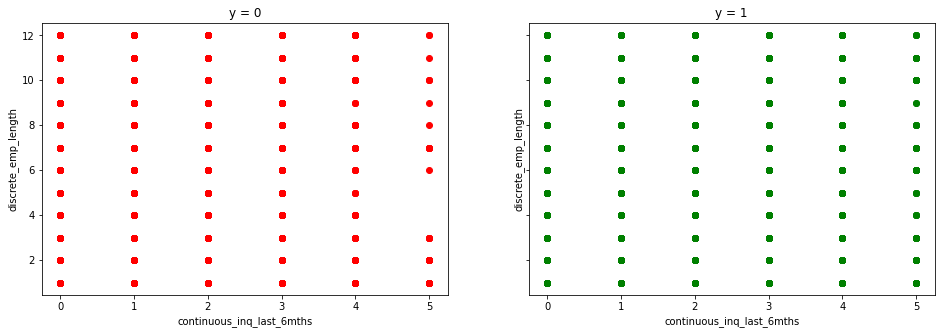

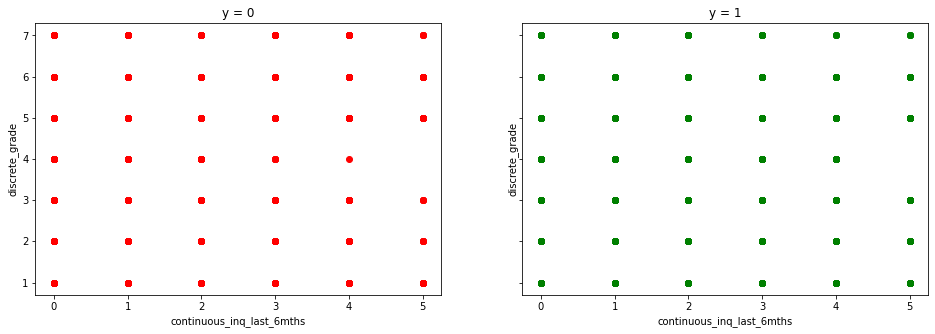

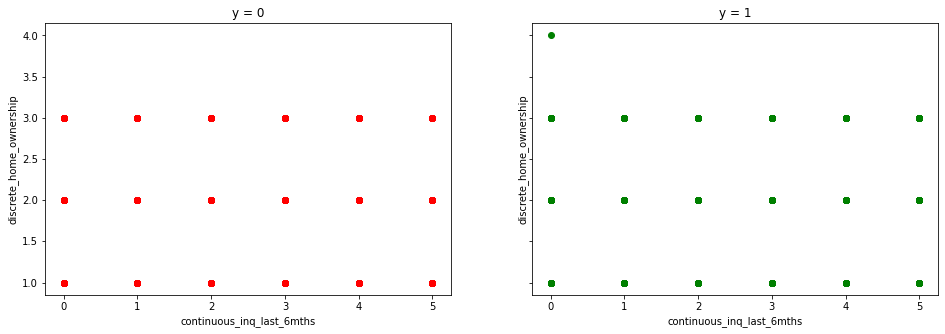

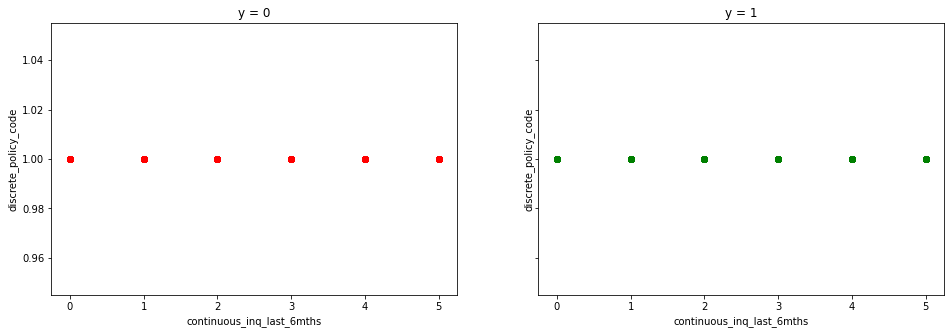

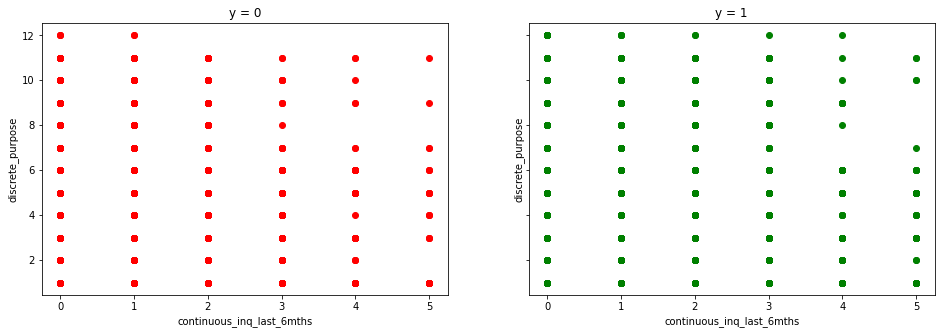

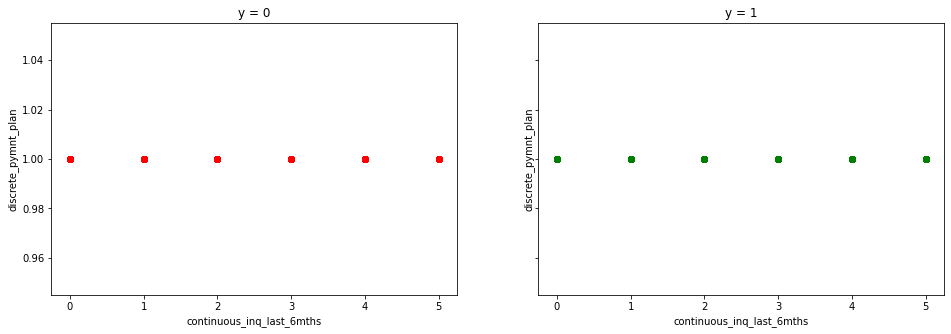

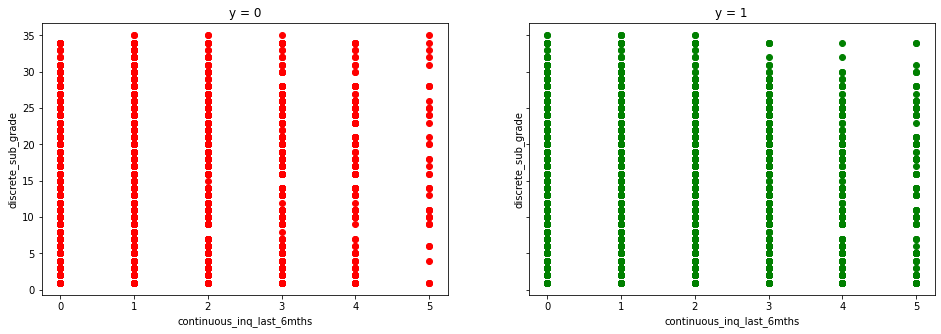

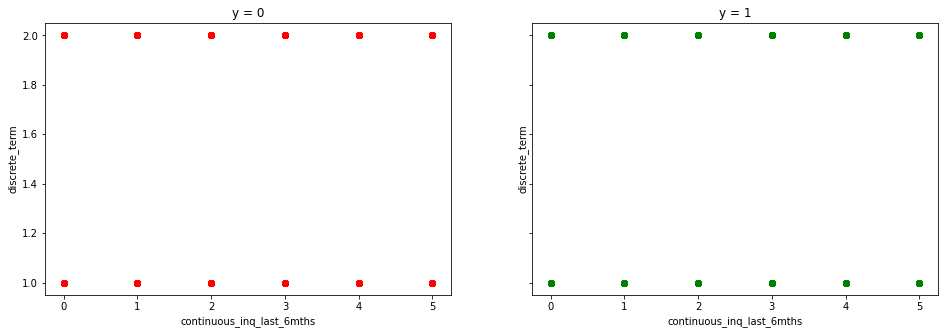

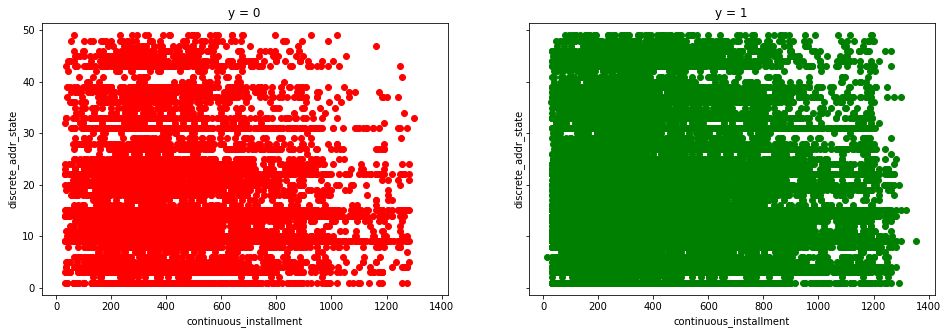

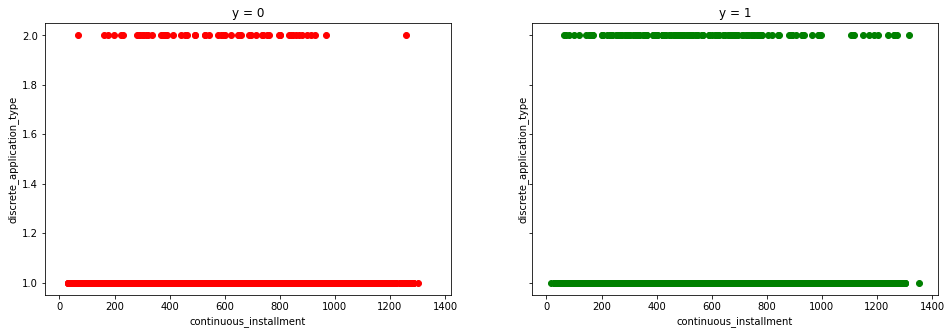

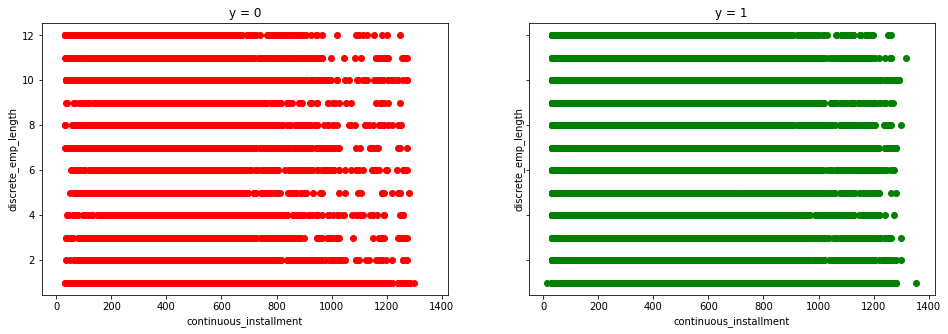

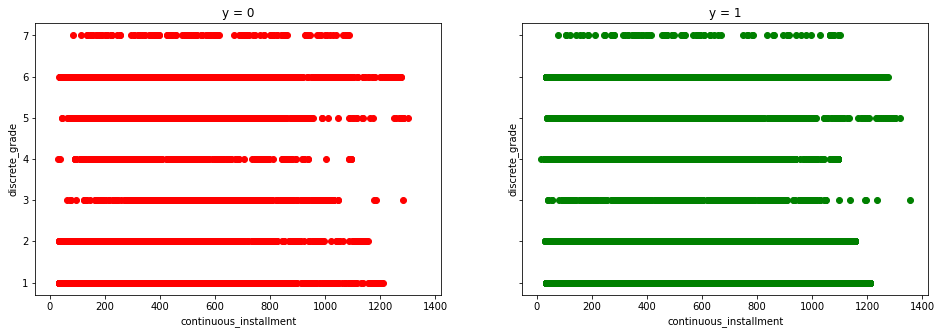

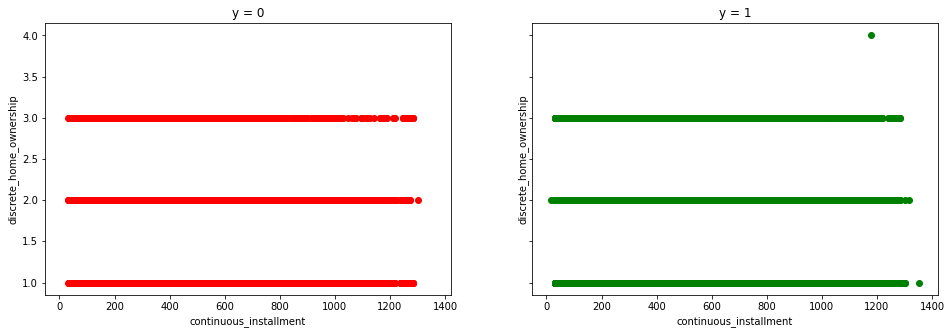

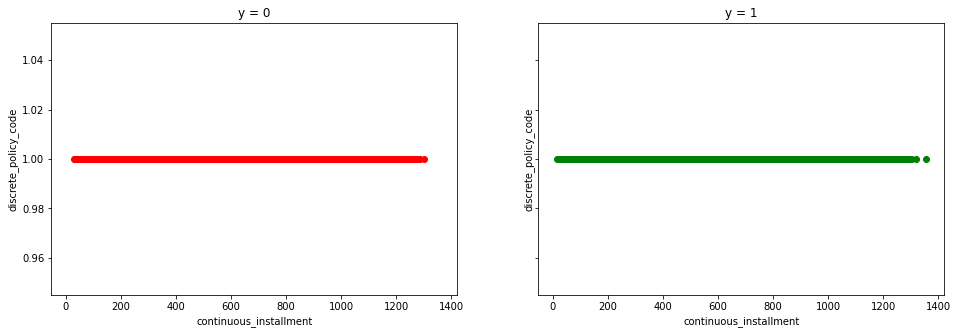

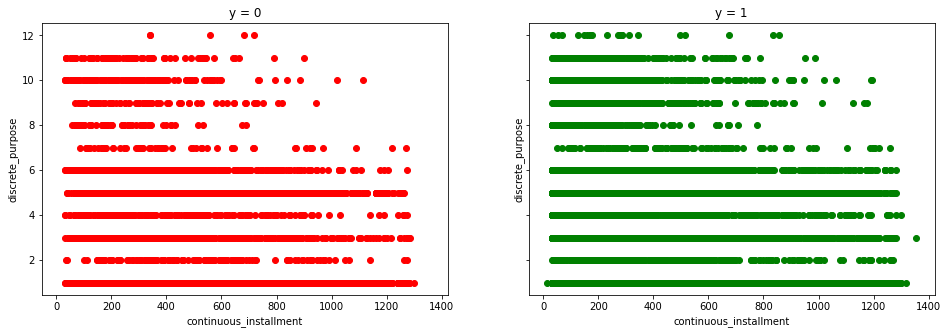

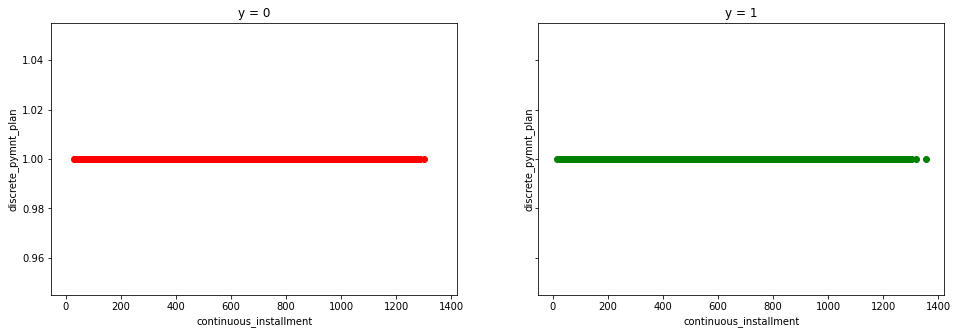

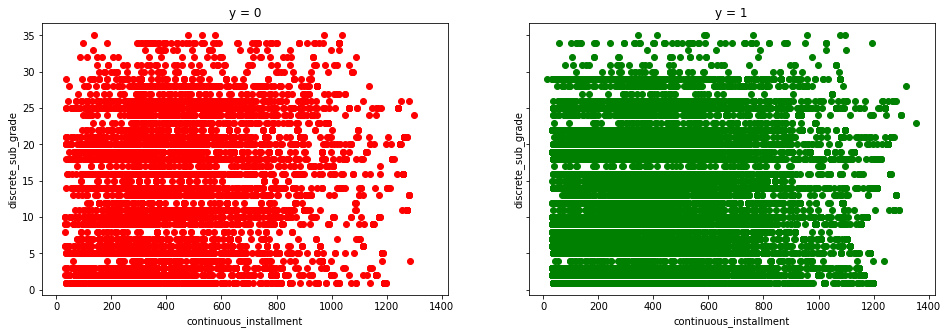

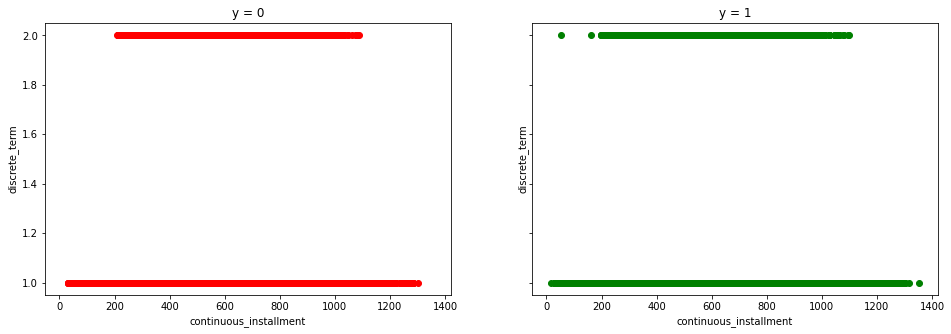

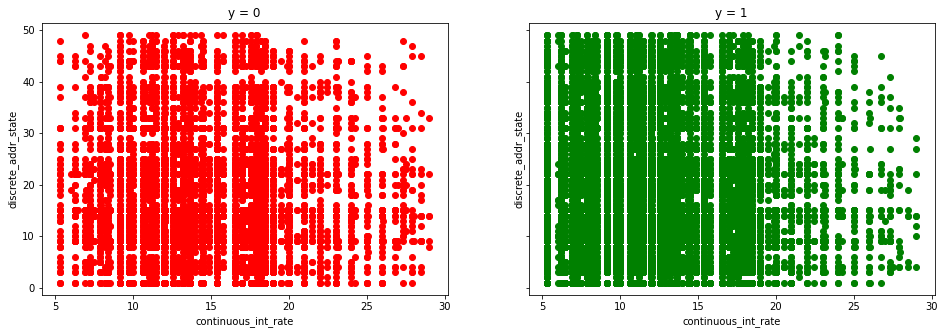

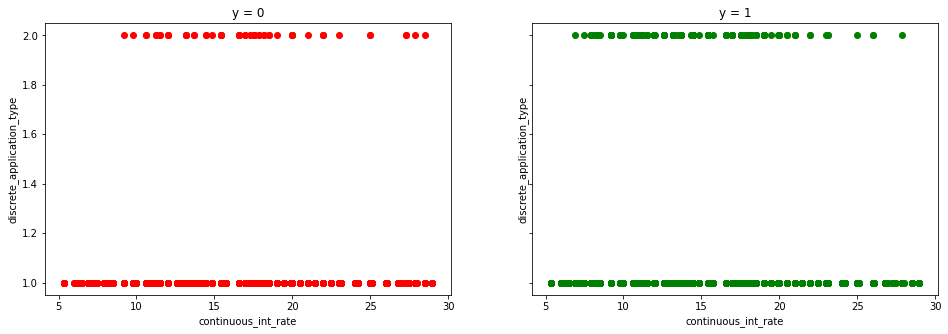

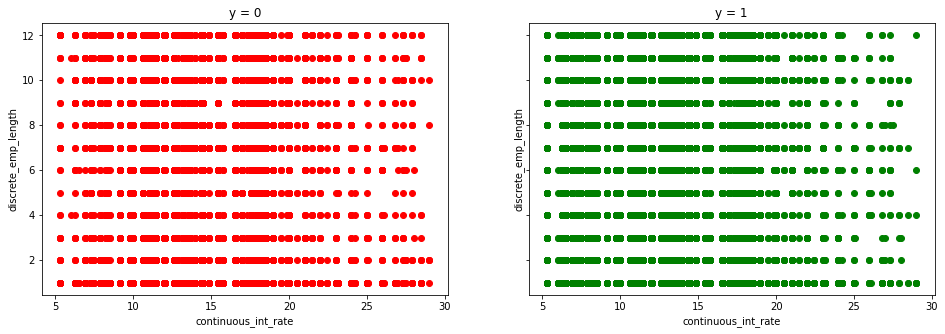

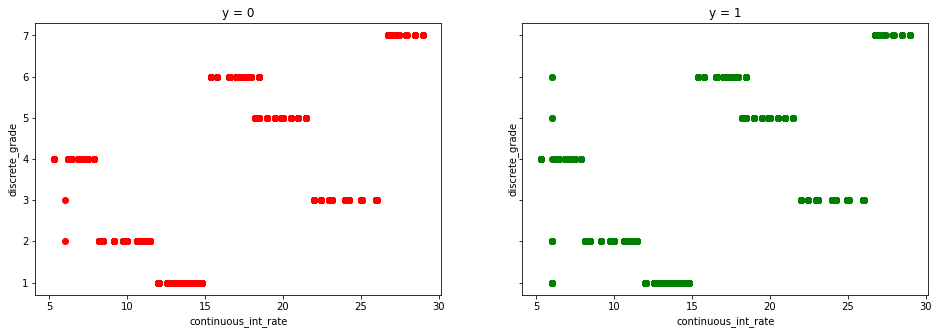

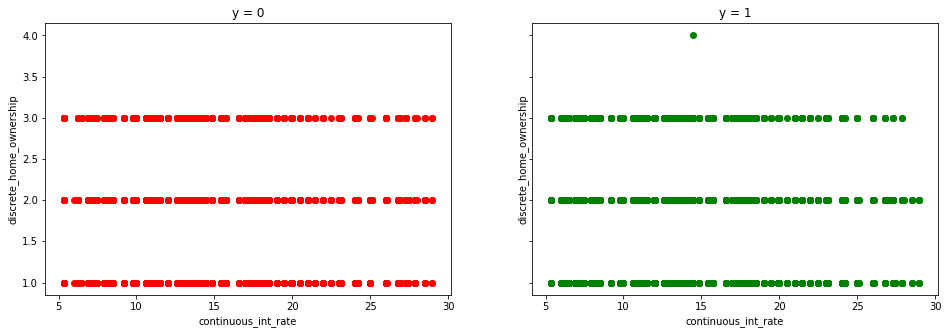

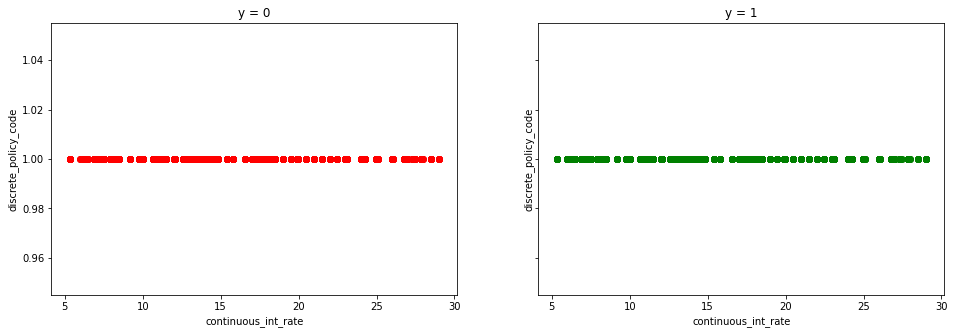

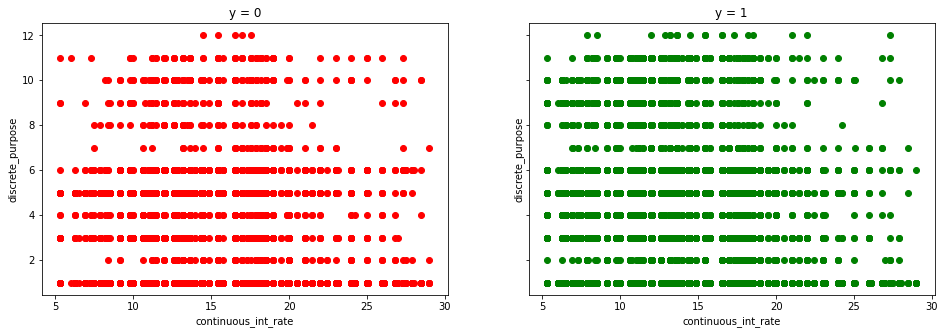

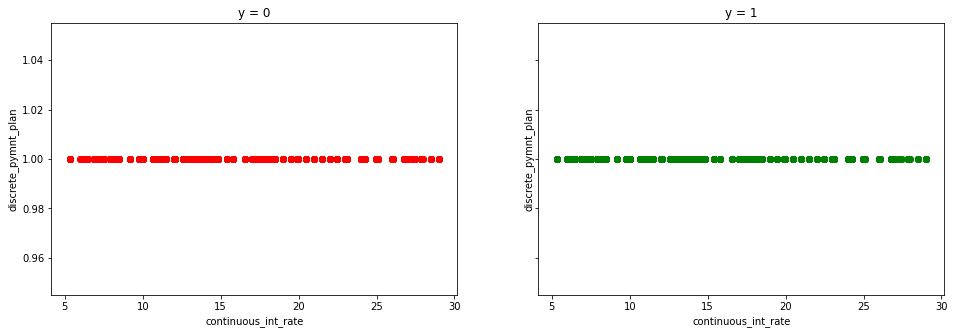

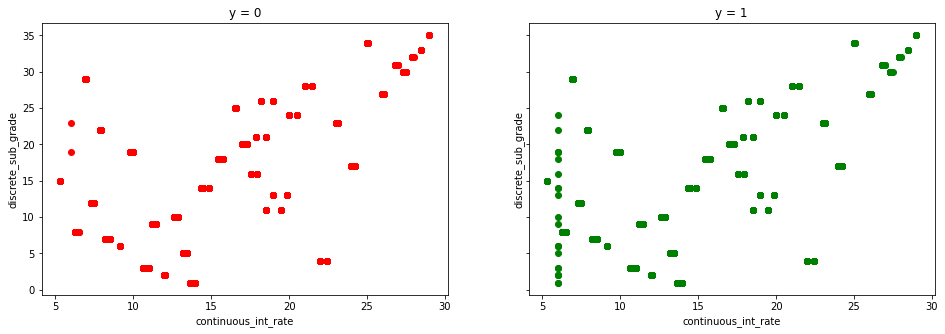

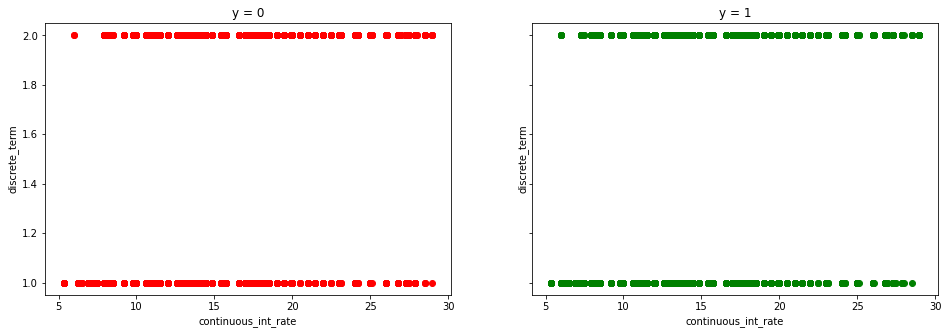

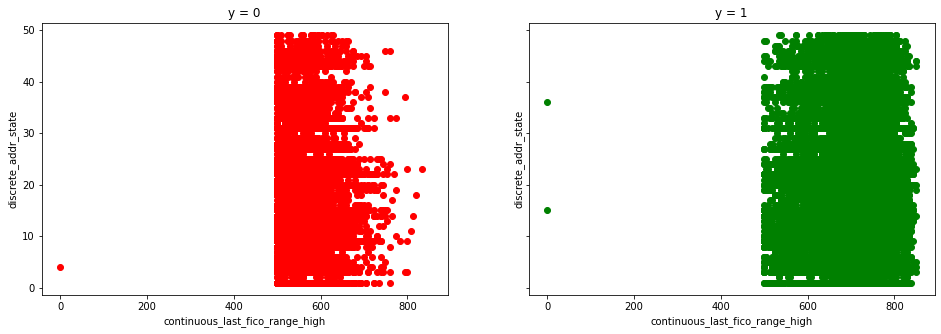

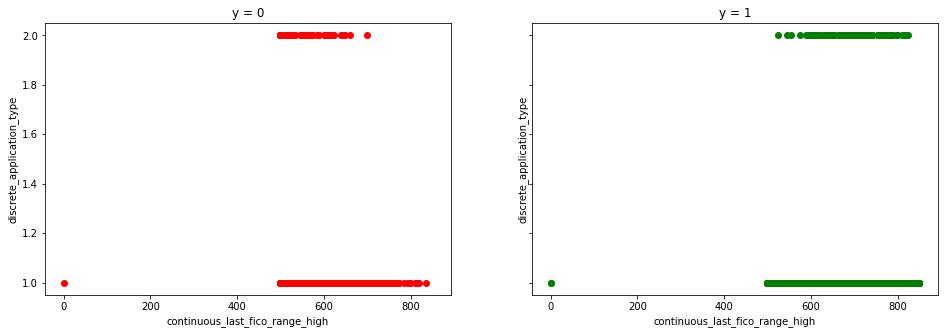

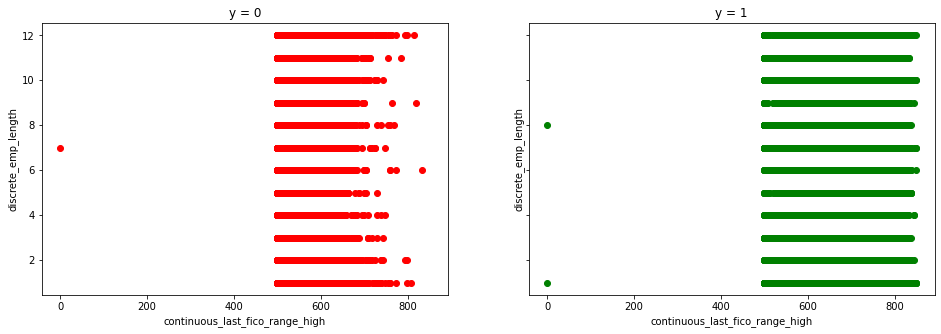

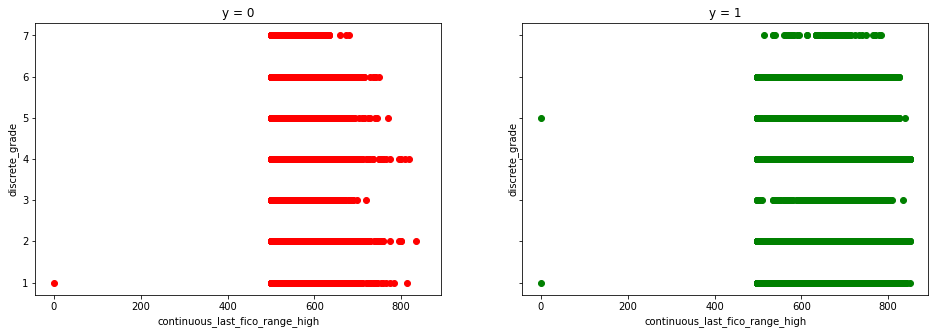

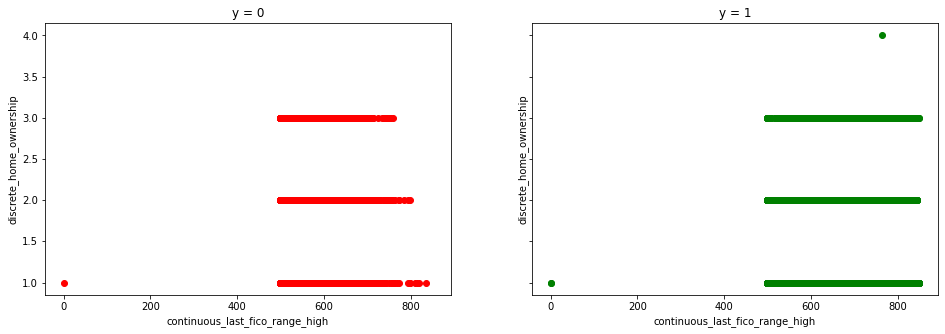

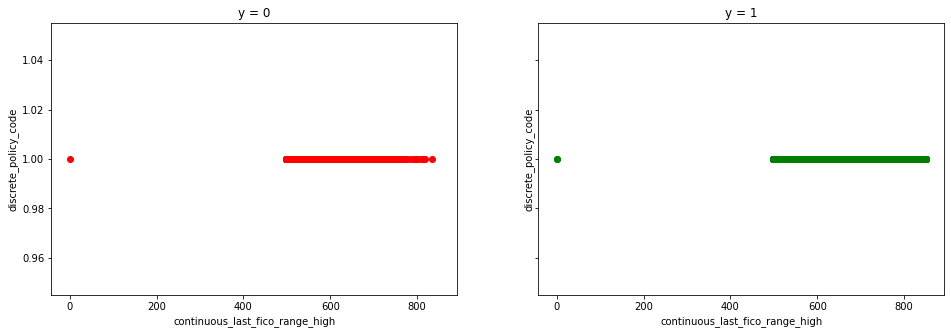

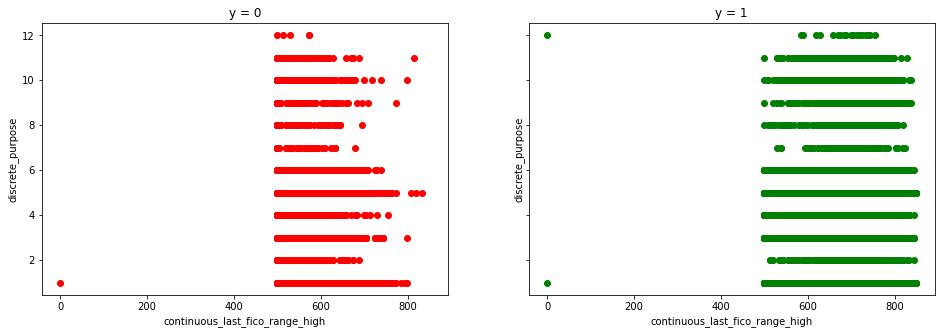

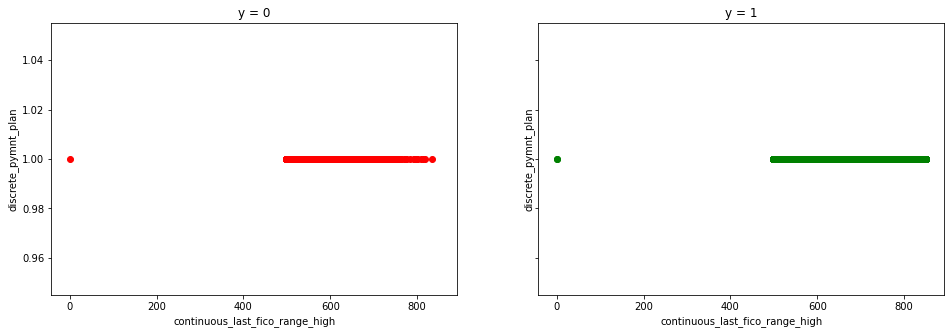

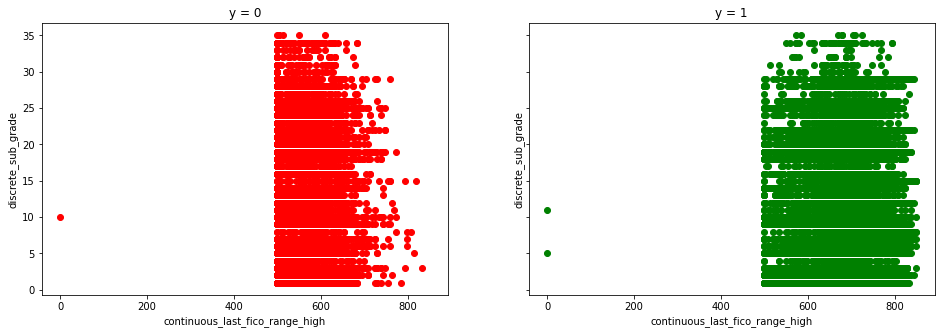

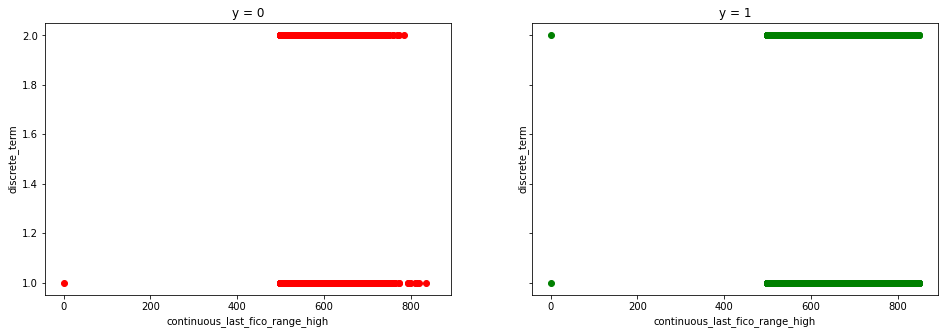

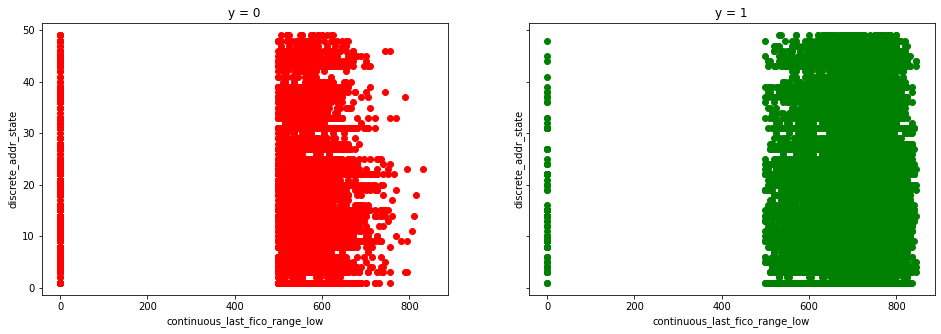

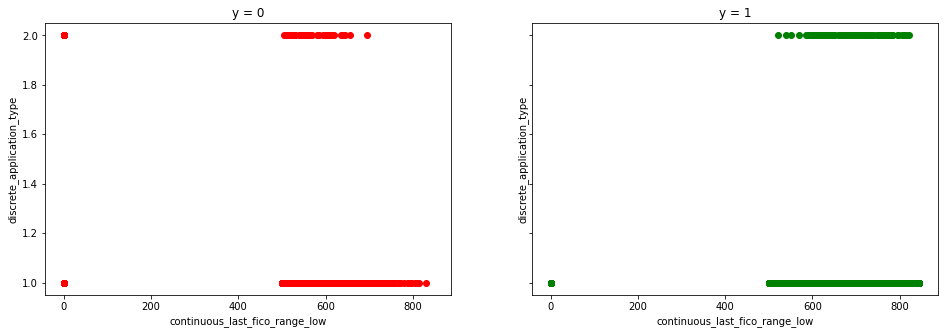

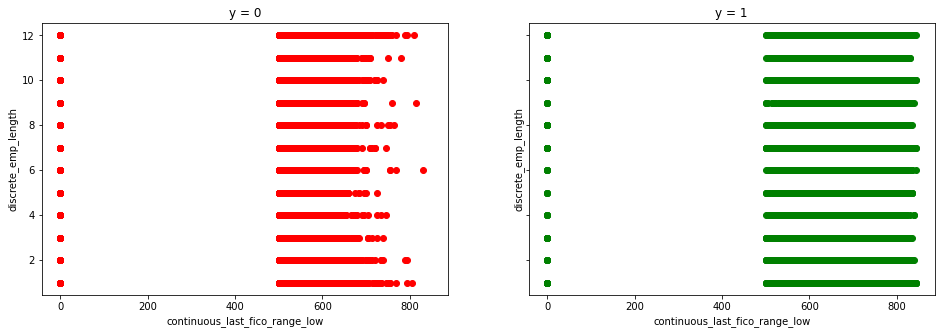

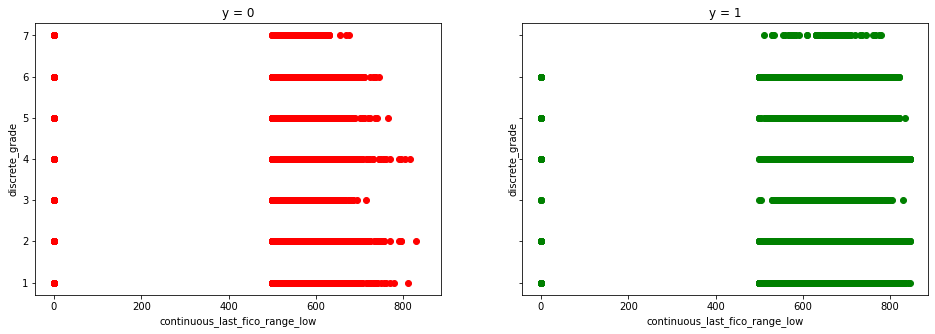

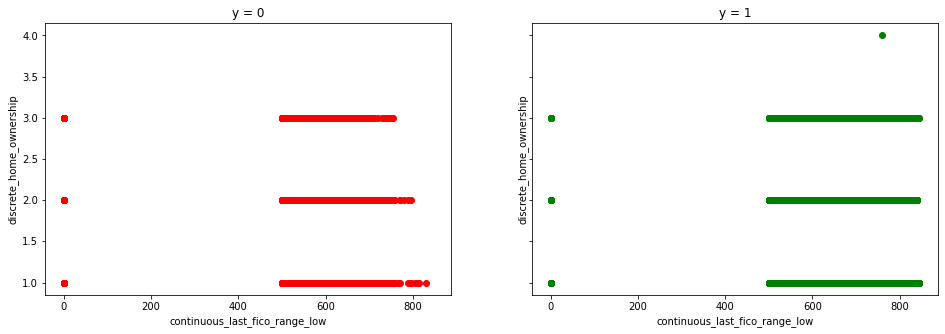

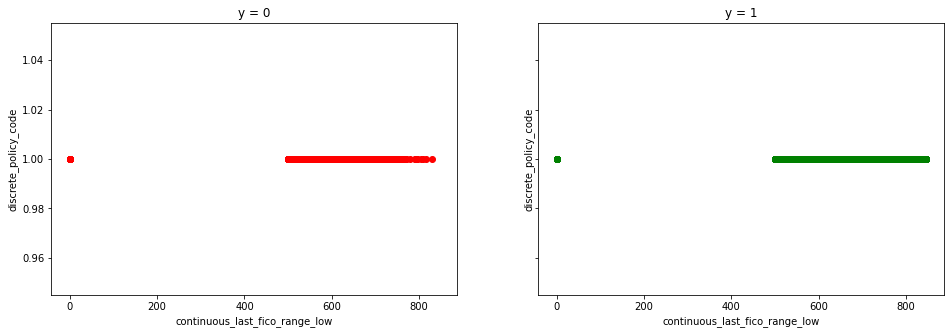

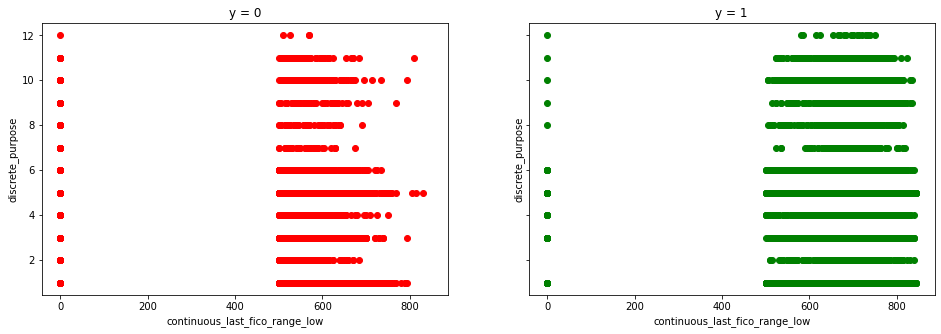

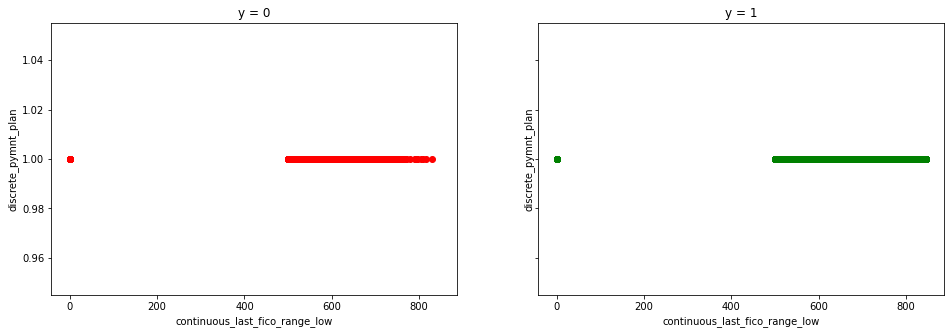

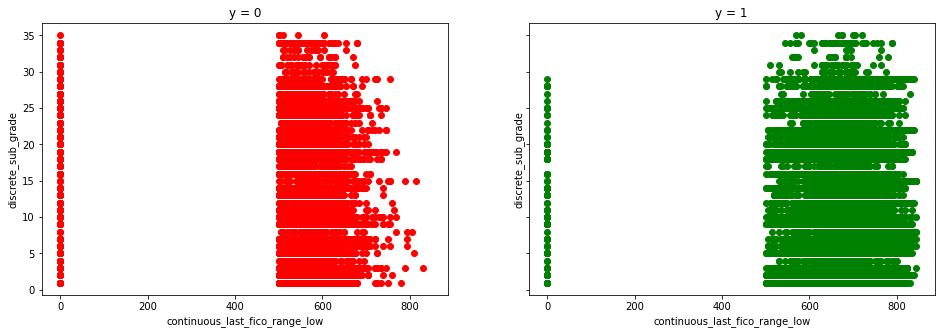

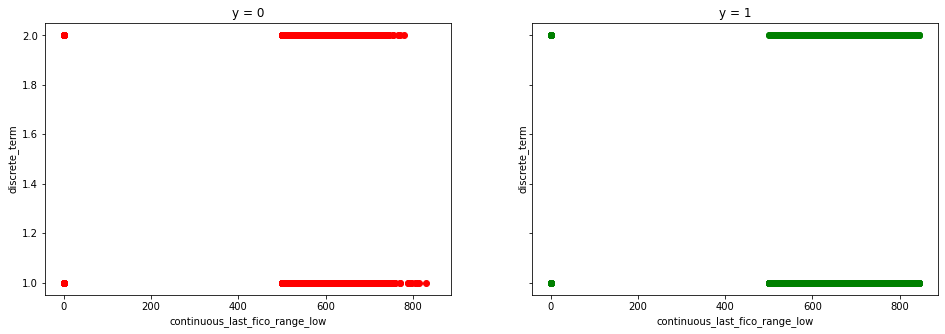

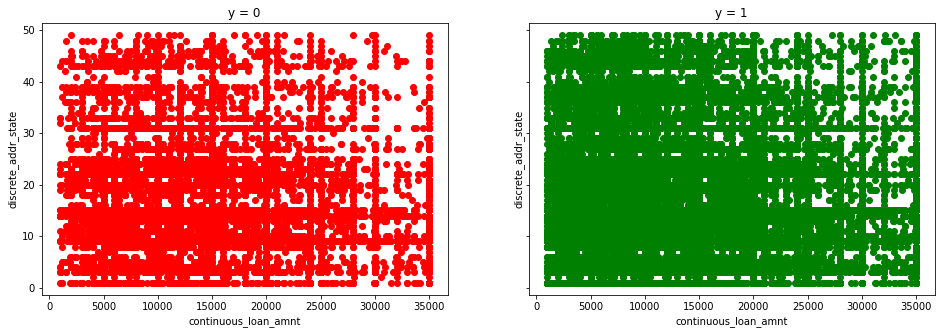

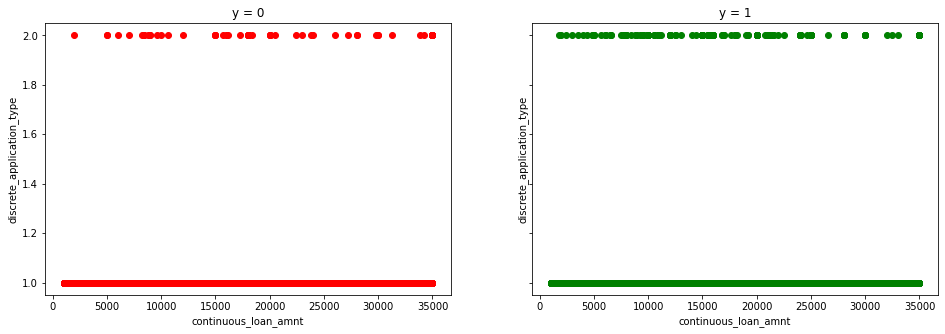

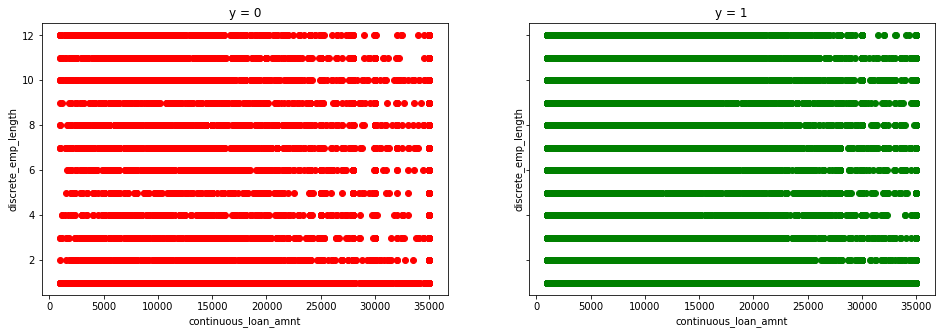

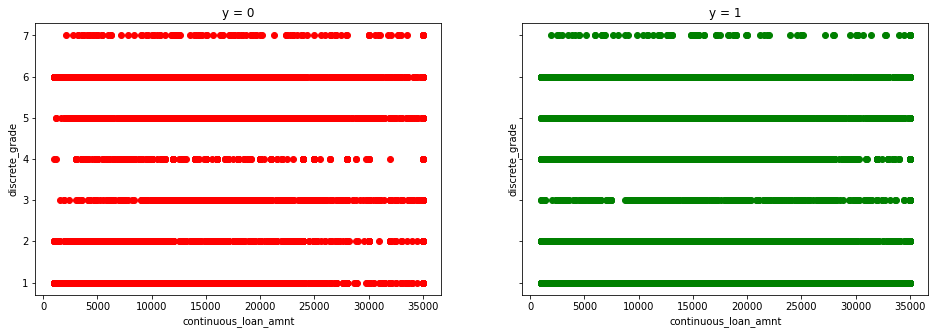

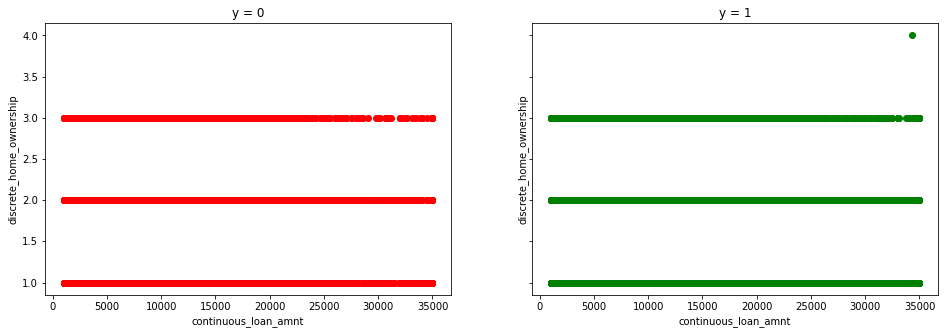

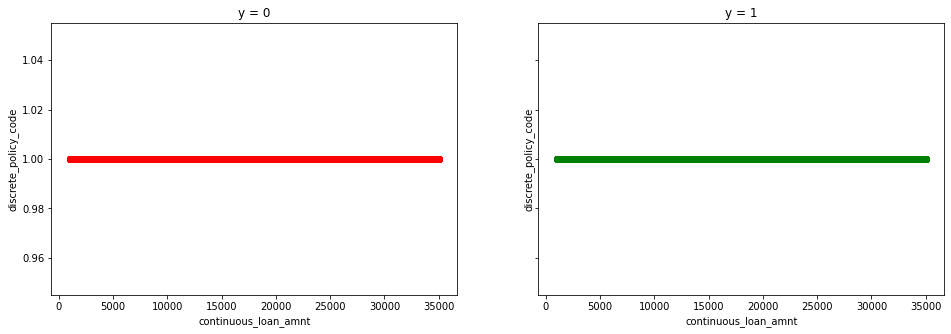

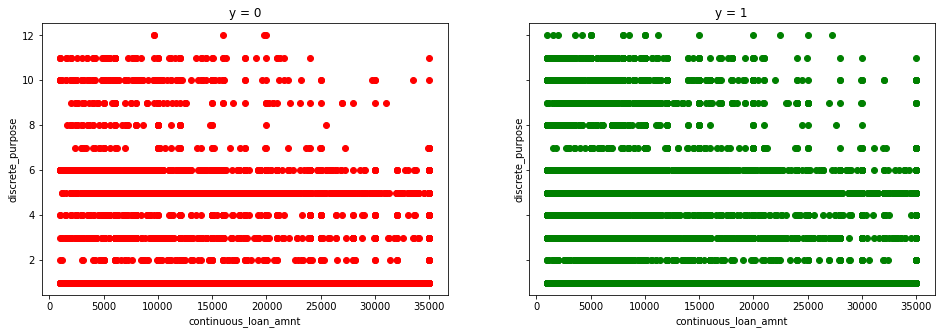

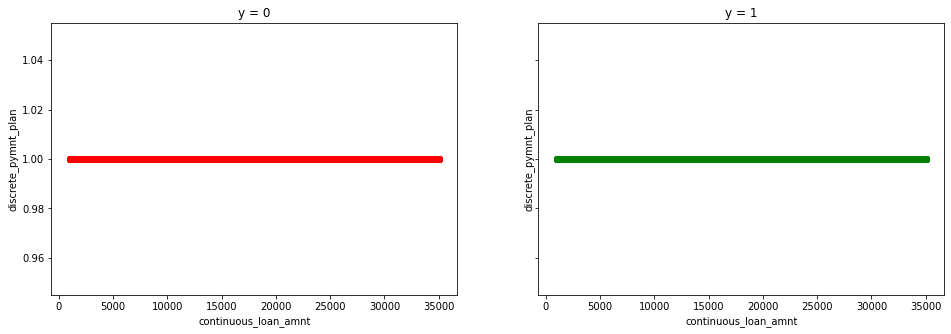

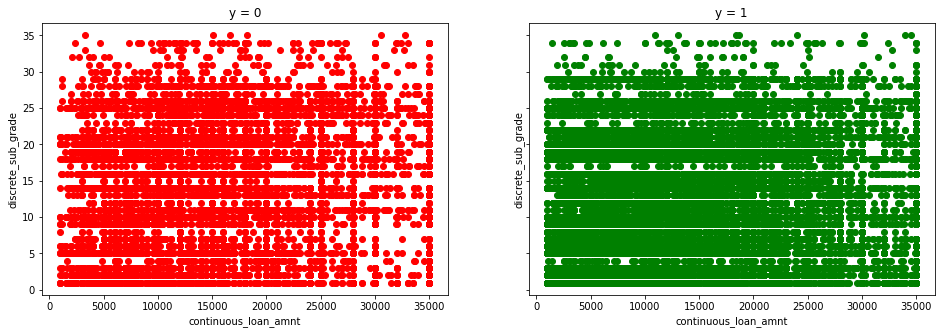

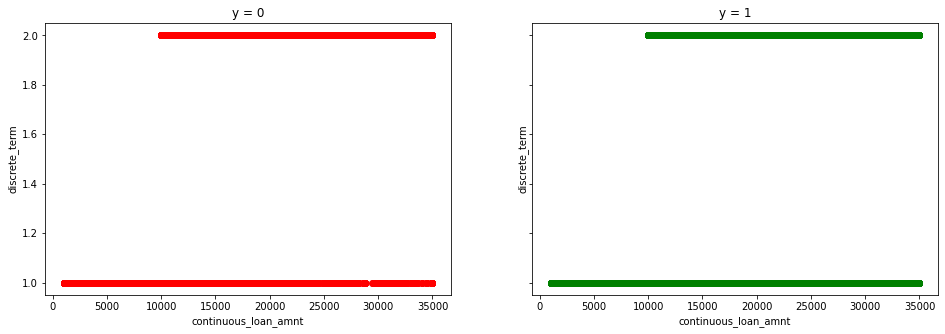

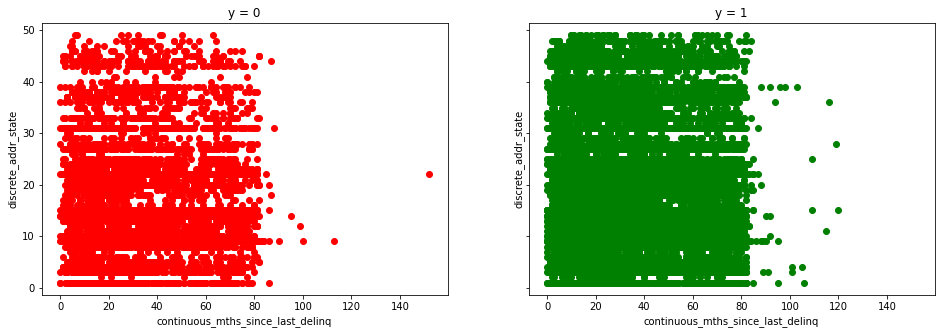

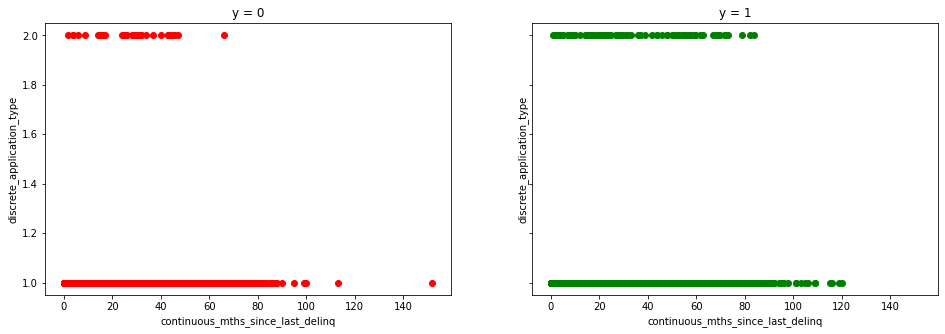

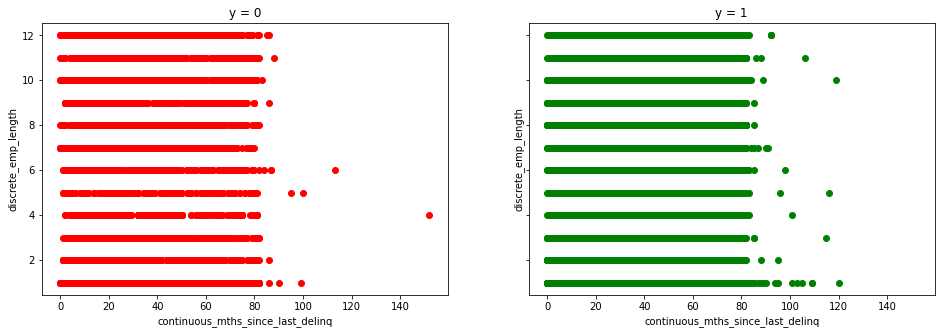

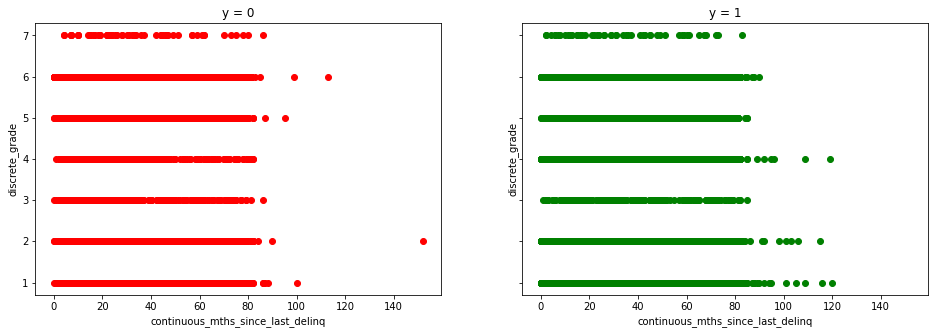

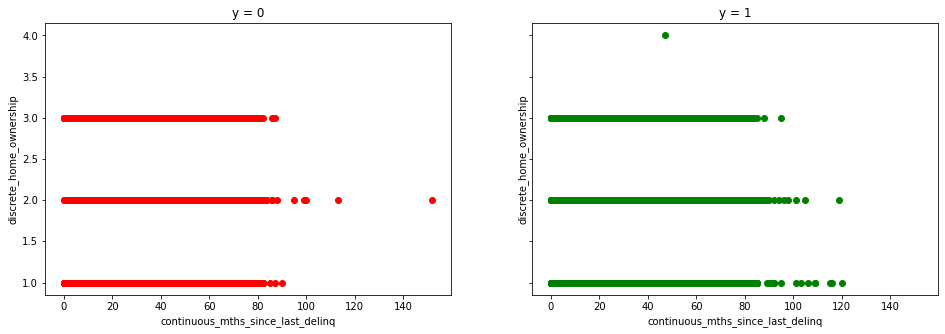

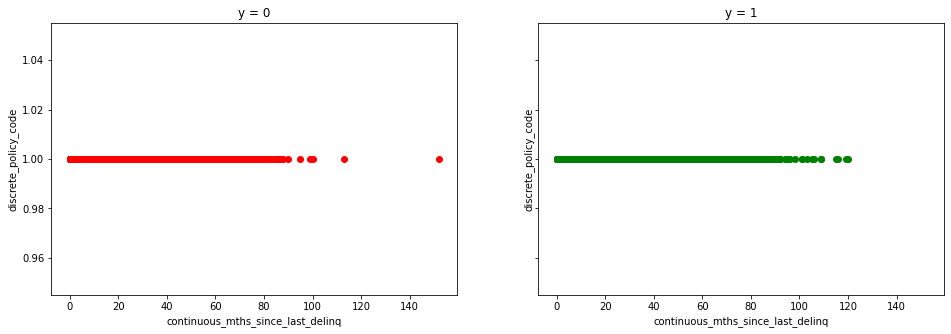

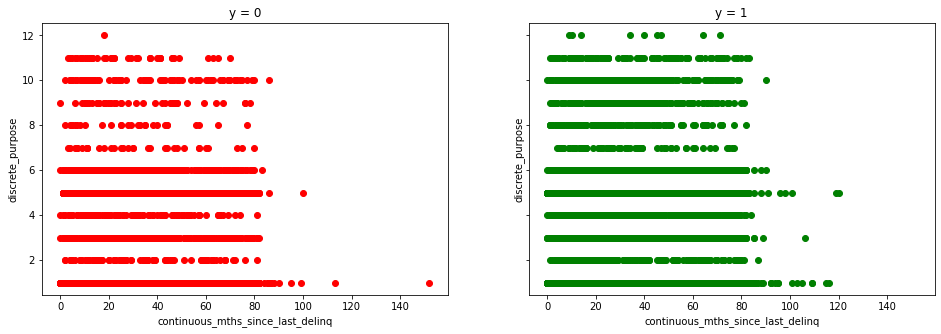

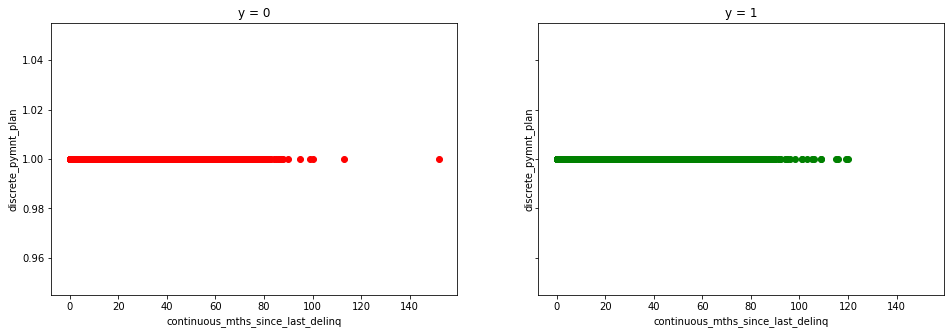

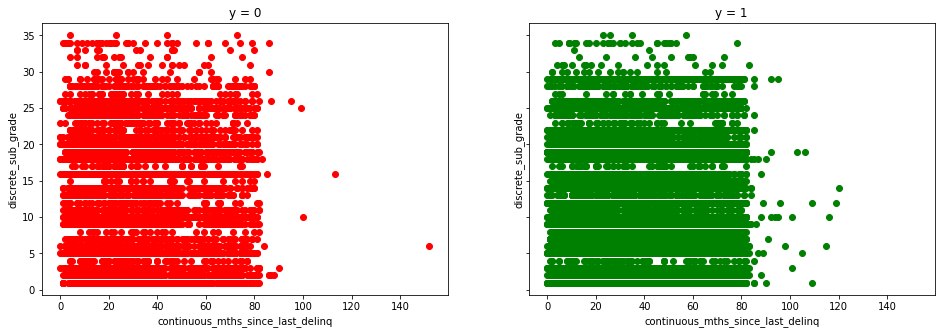

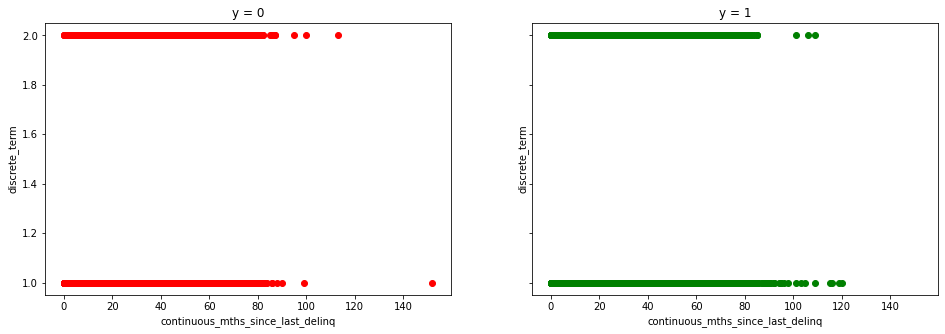

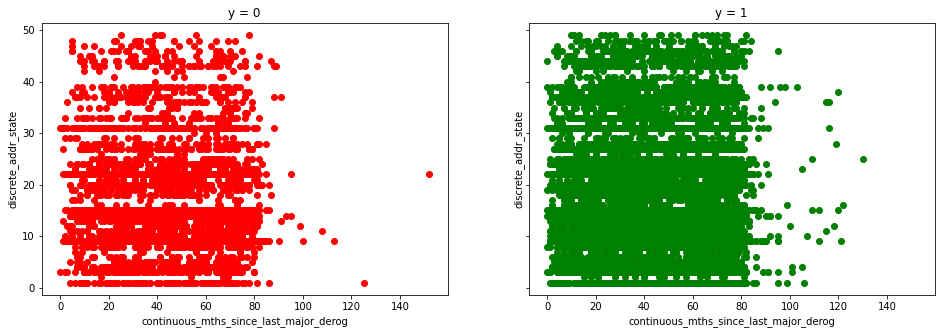

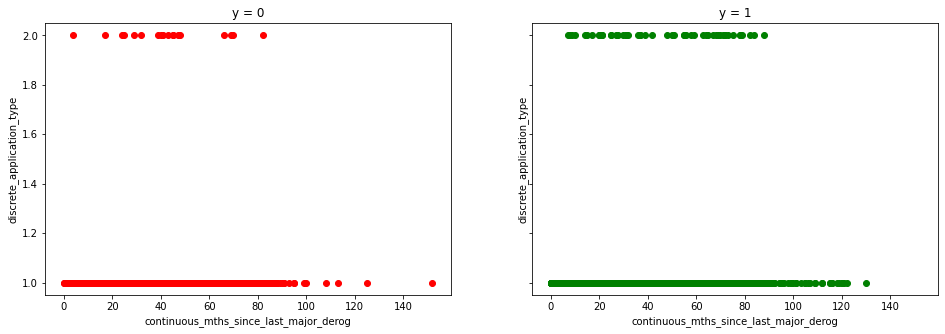

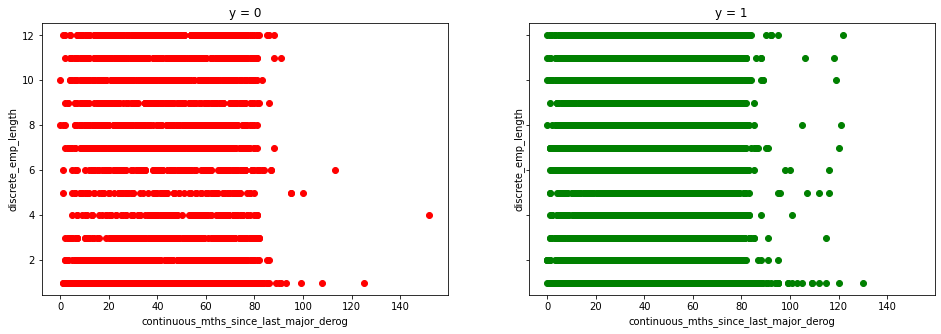

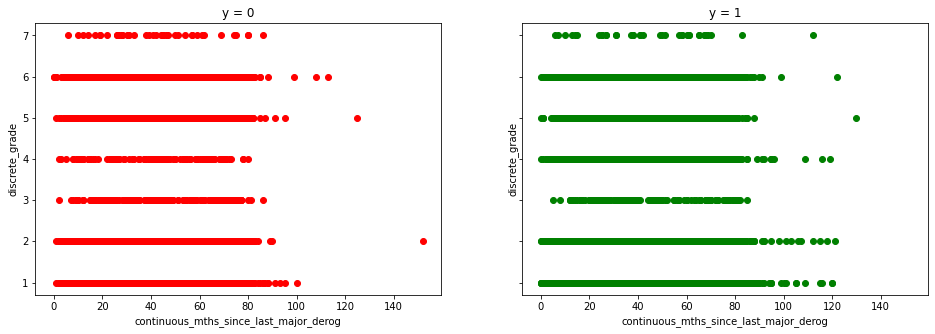

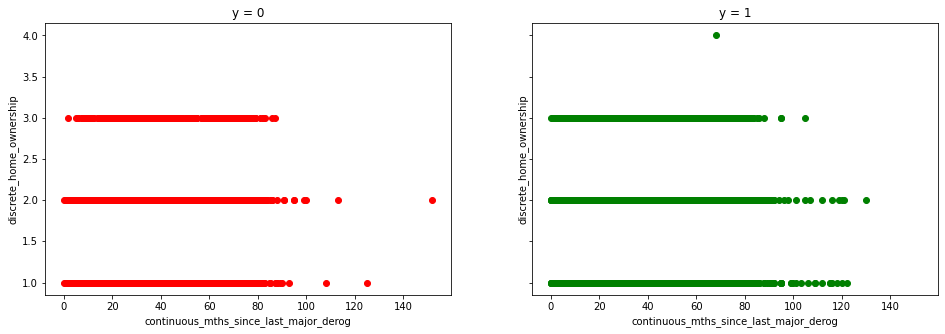

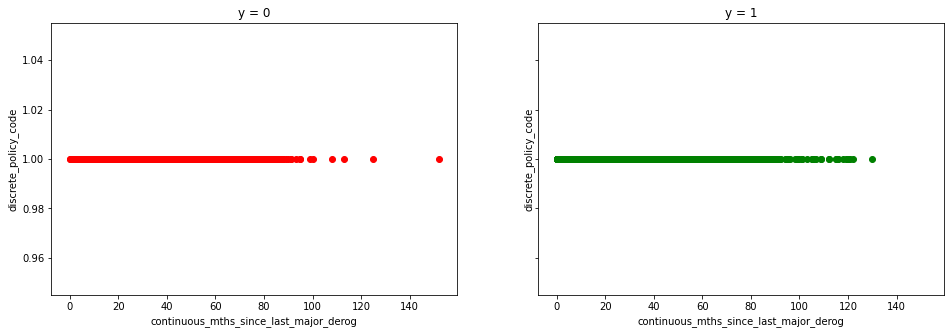

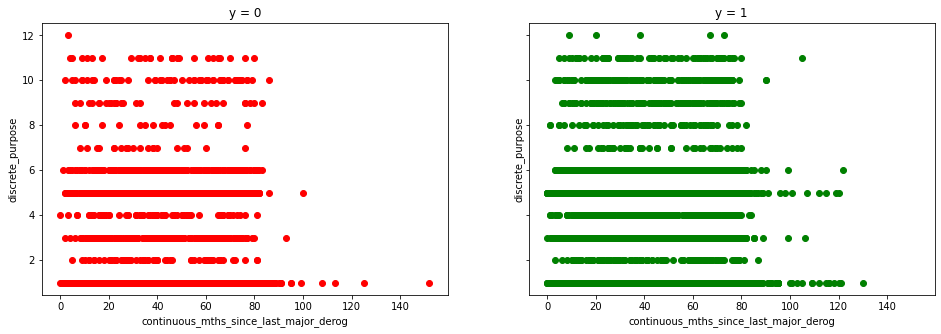

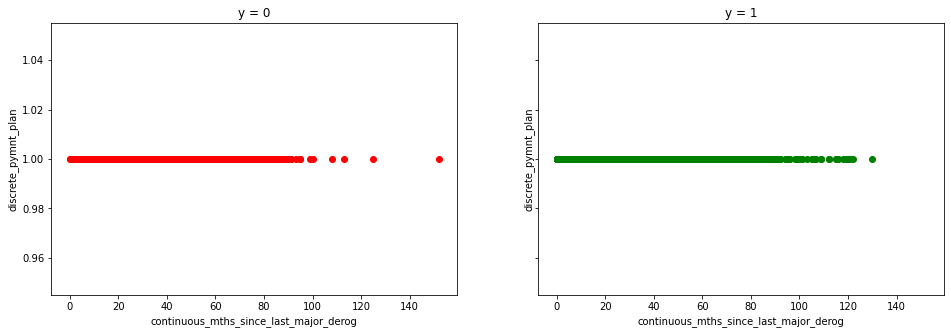

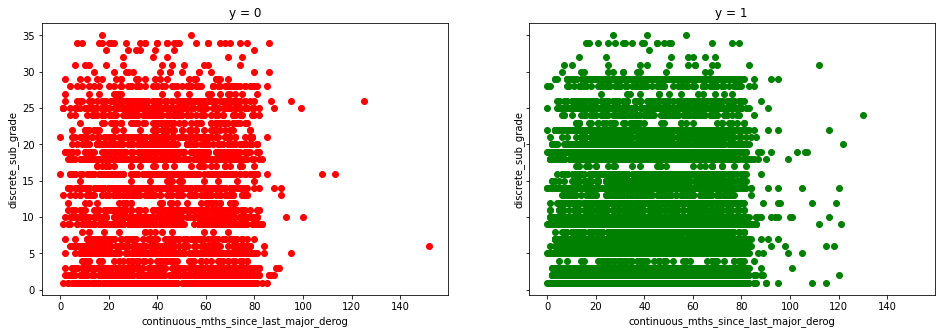

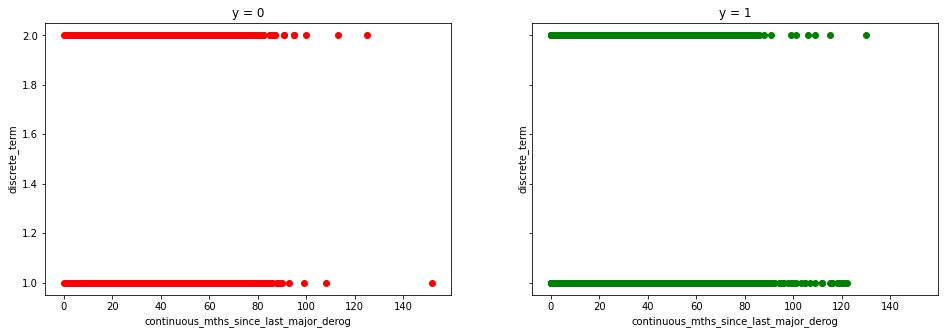

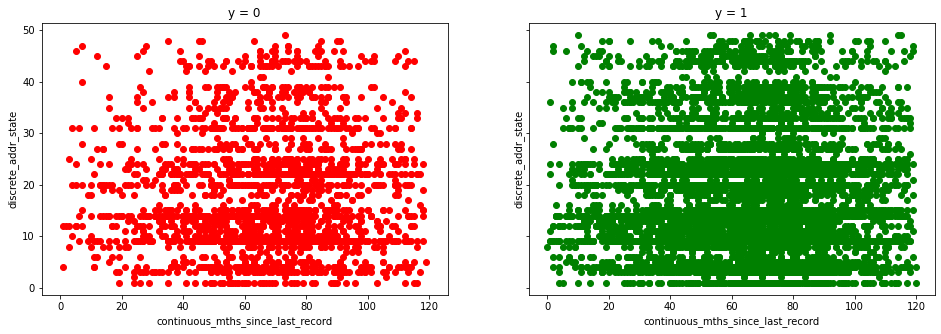

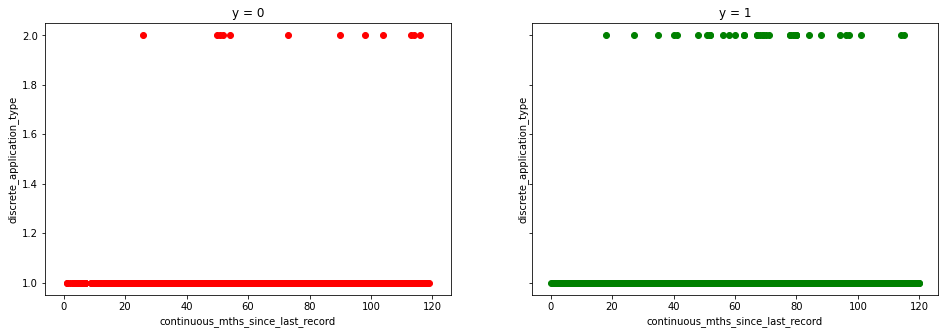

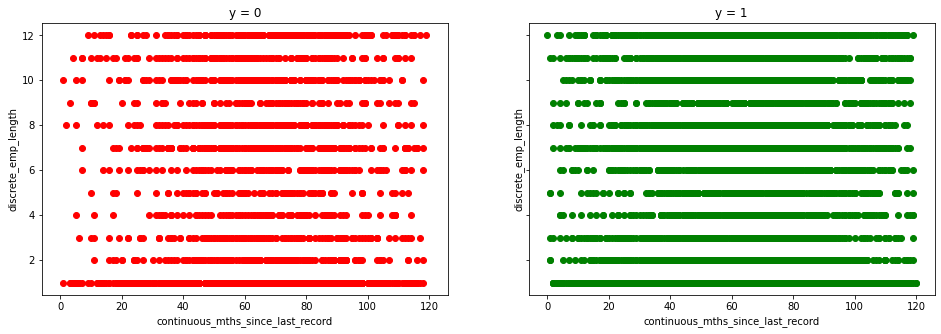

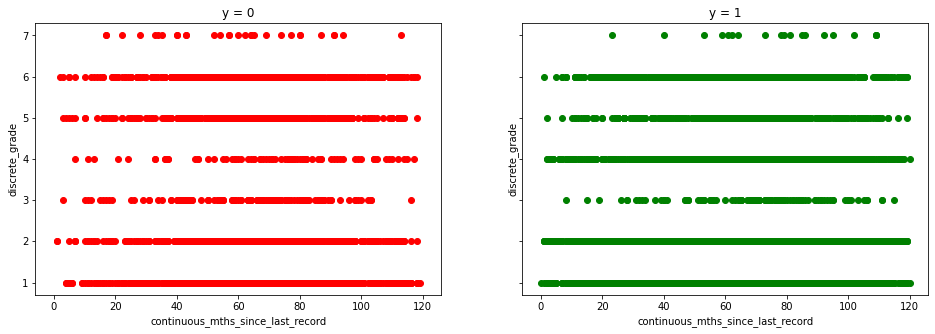

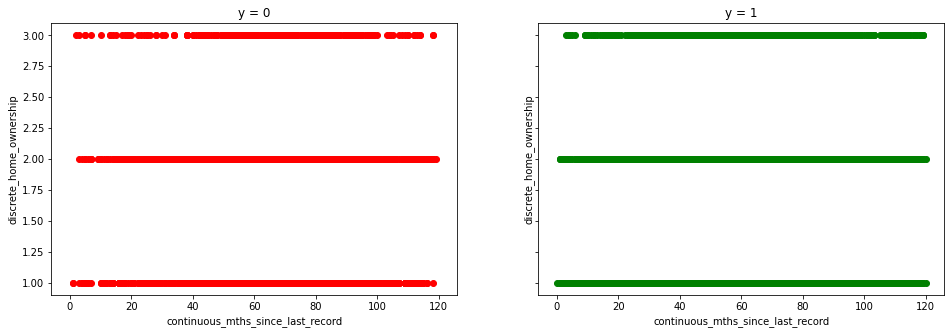

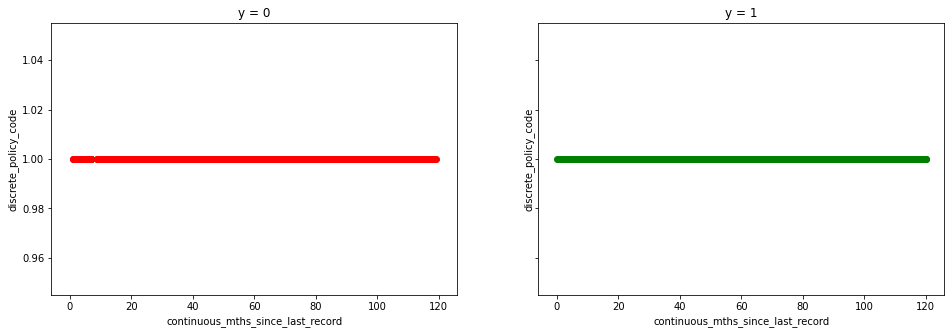

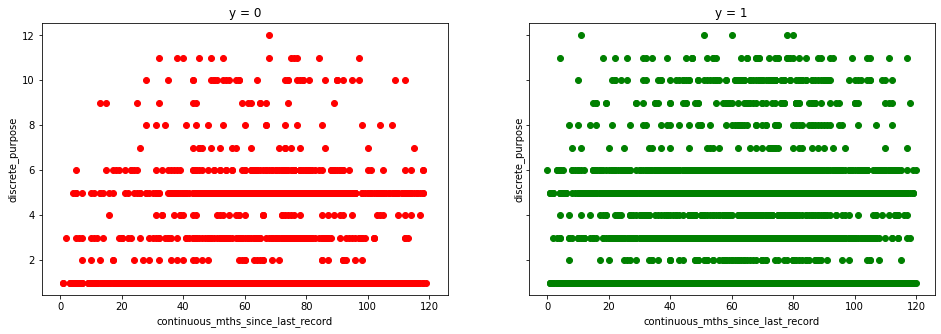

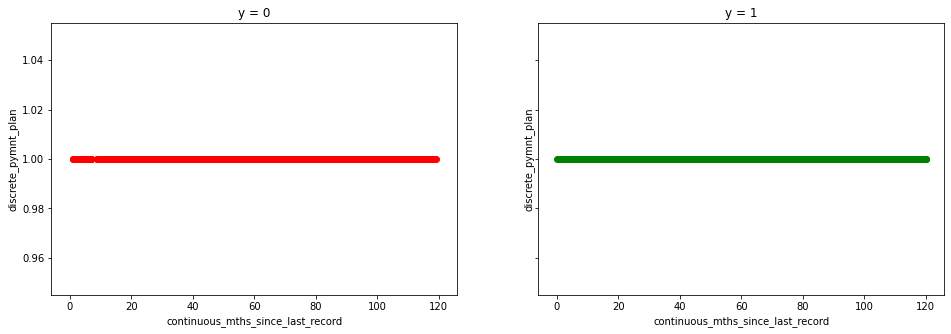

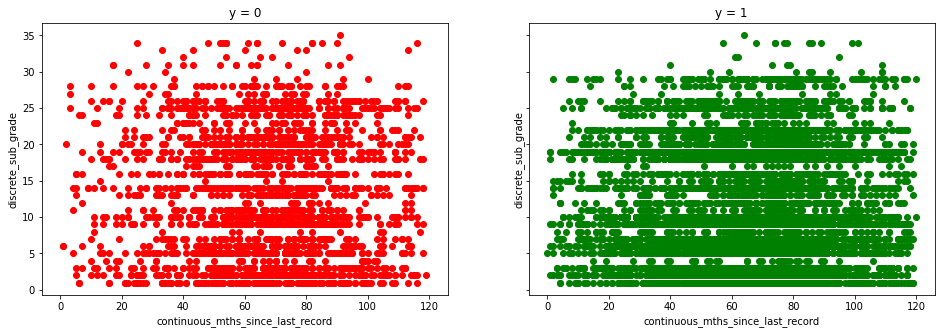

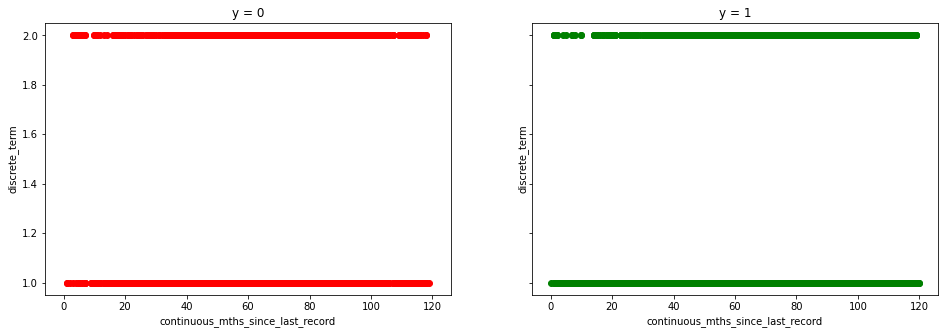

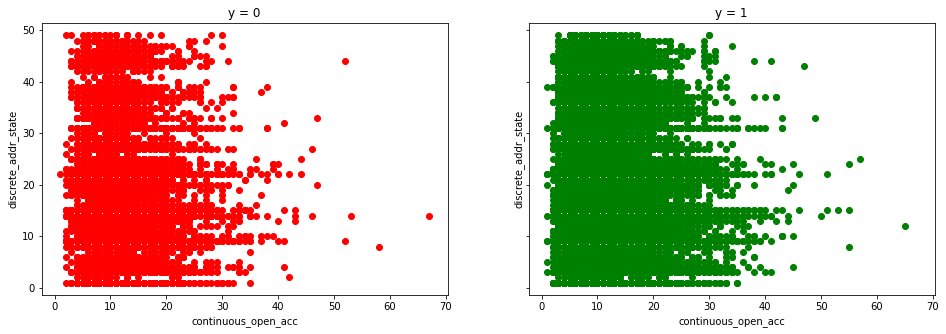

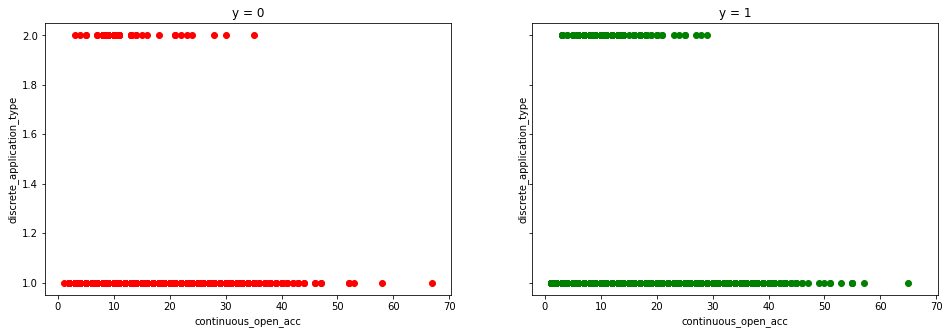

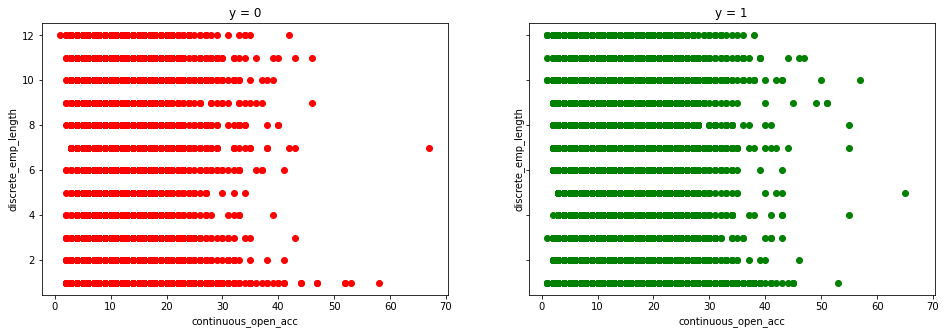

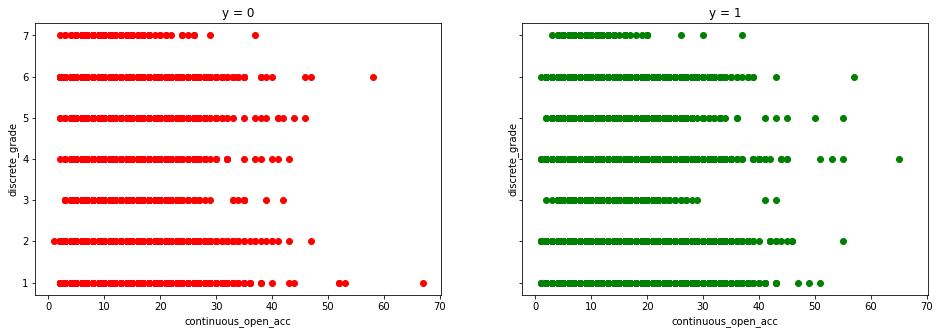

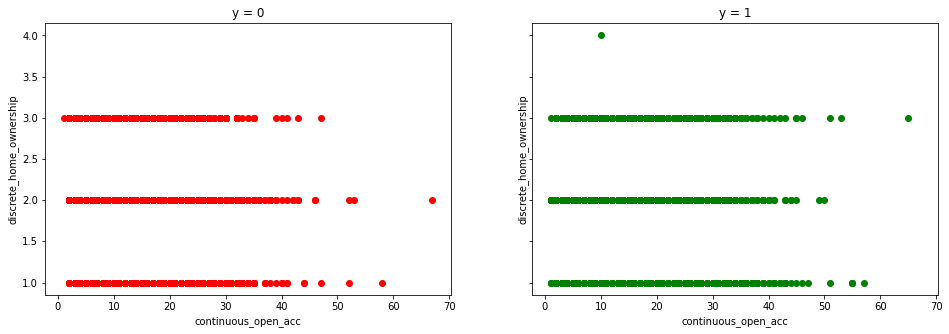

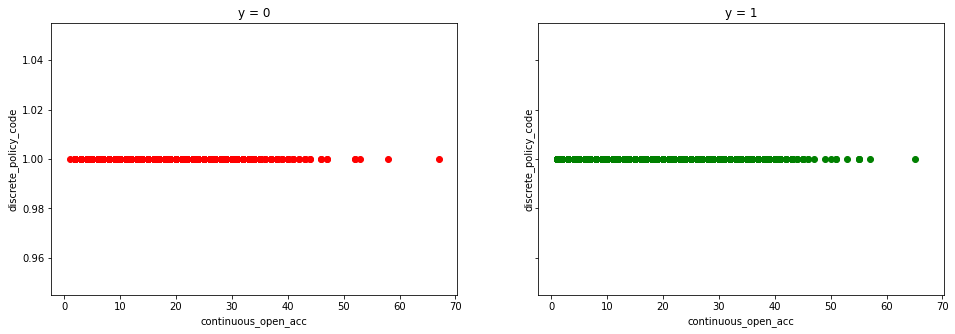

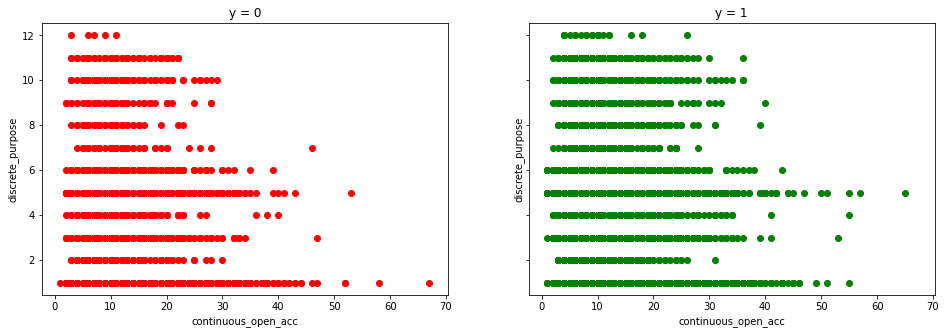

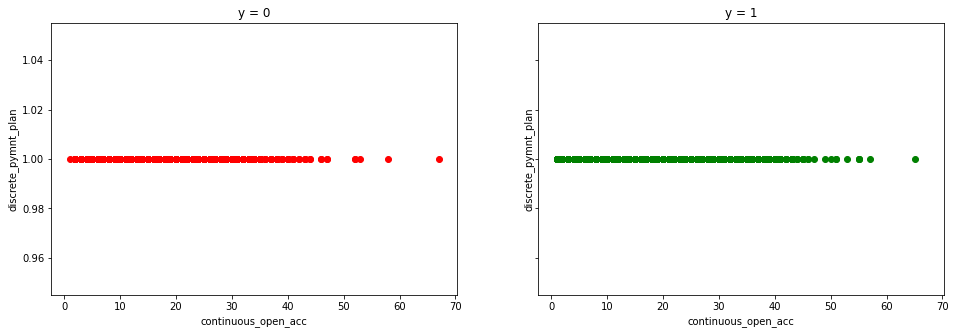

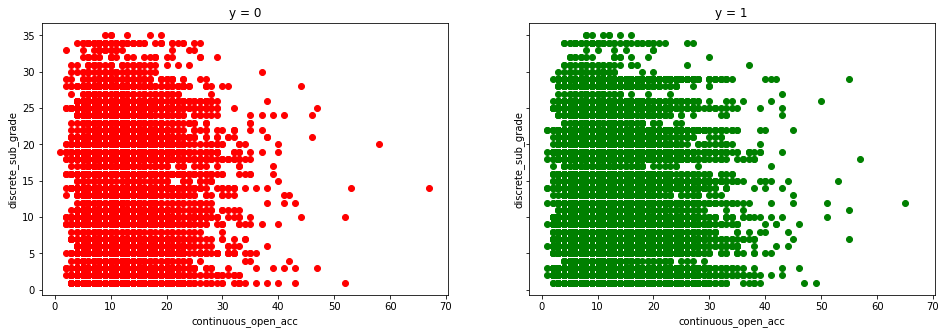

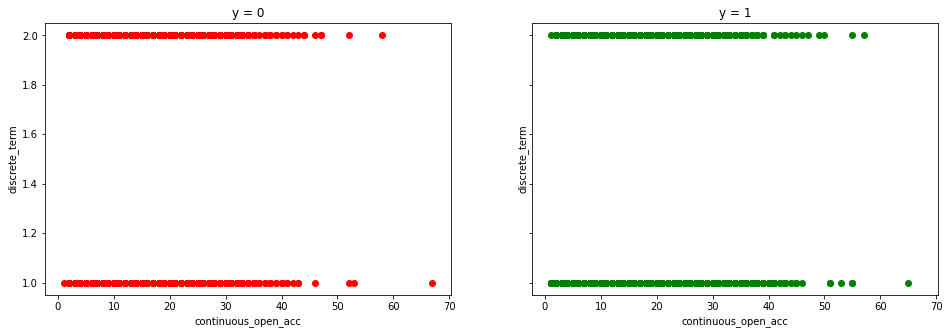

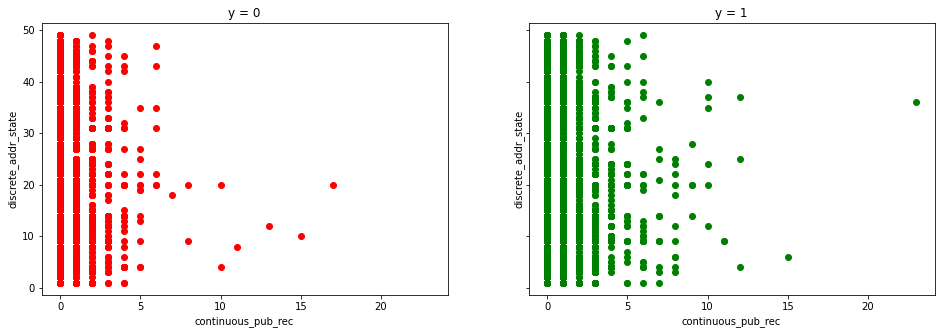

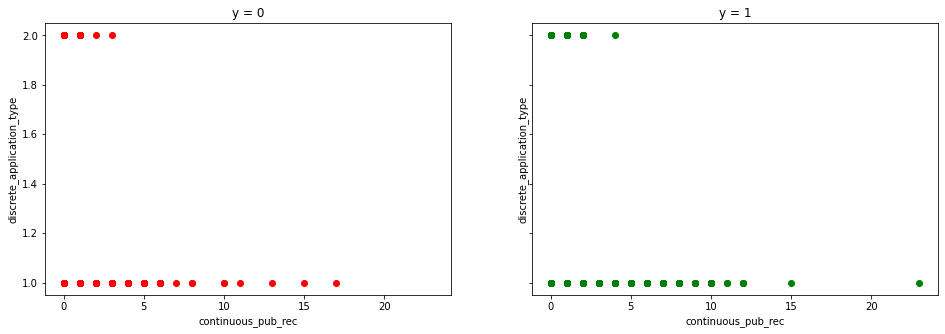

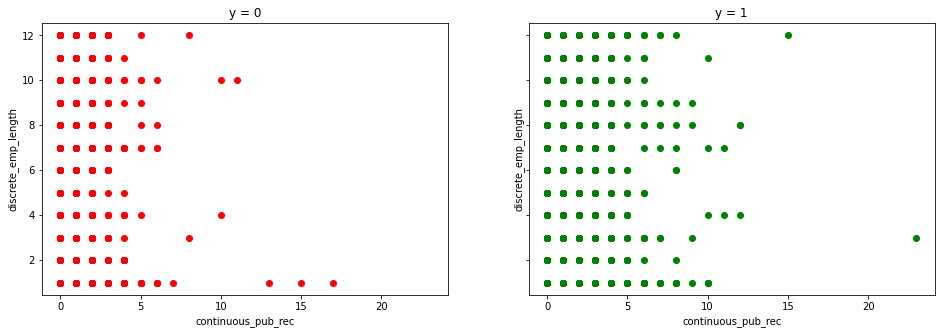

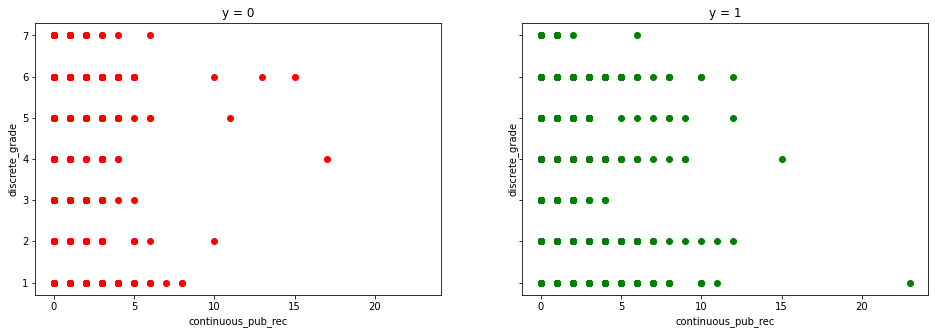

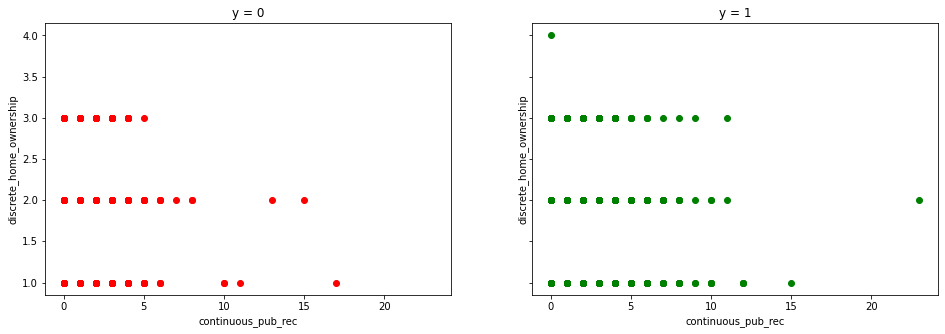

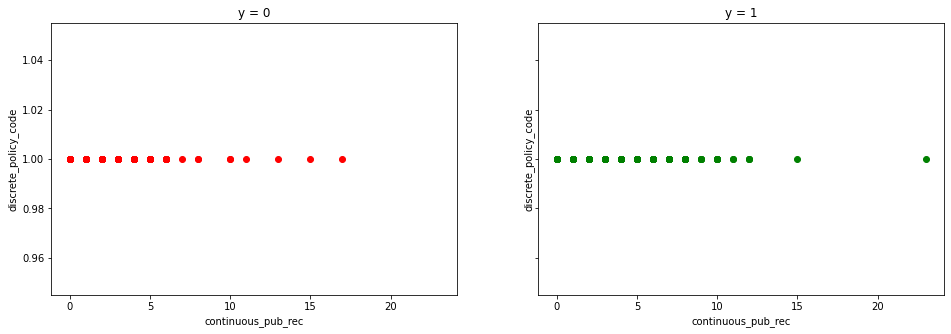

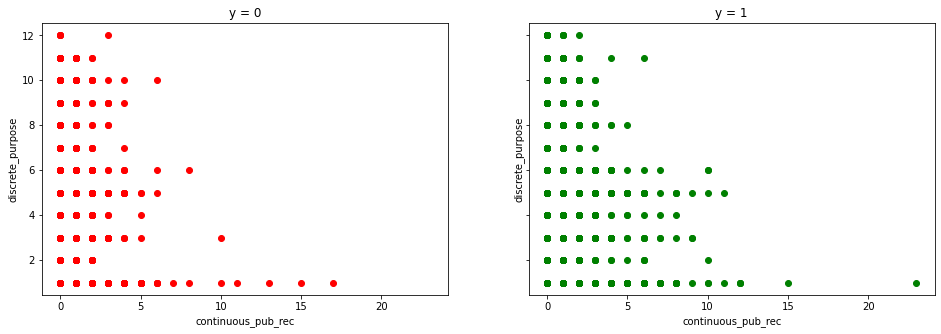

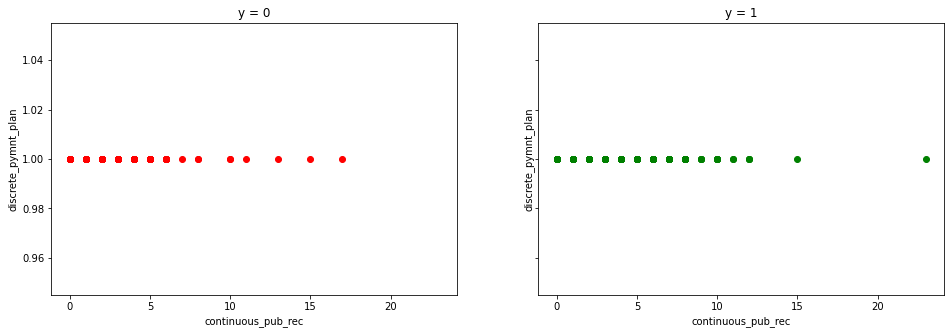

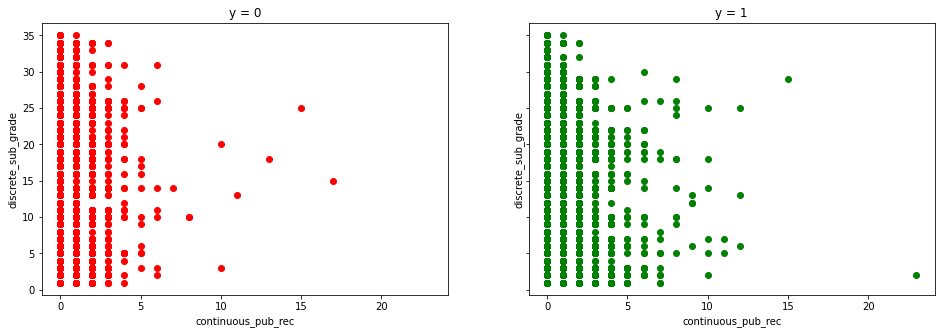

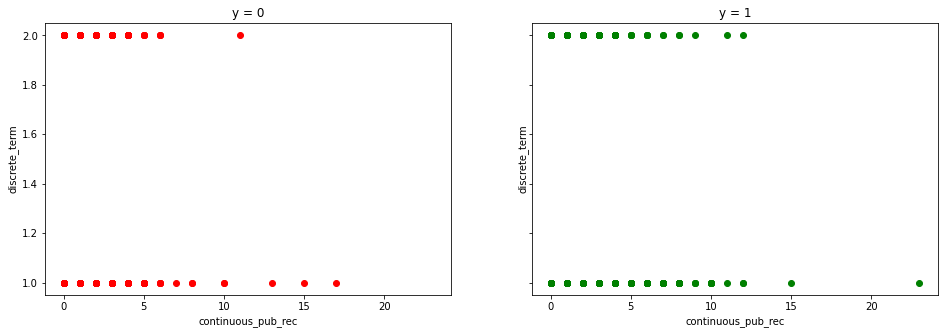

In [91]:
idx_1 = train_raw[train_raw[label_col] == 1].index.values
idx_0 = train_raw[train_raw[label_col] == 0].index.values

for c_col in continuous_features:
    for d_col in one_hot_raw.columns:        

        fig, ax = plt.subplots(1, 2,figsize=(16, 5),sharex=True, sharey=True)  
        
        ax[0].scatter(train_raw.iloc[idx_0][c_col], one_hot_raw.iloc[idx_0][d_col], c='red')
        ax[0].set_title('y = 0')
        ax[0].set_xlabel(c_col)
        ax[0].set_ylabel(d_col)
        
        ax[1].scatter(train_raw.iloc[idx_1][c_col], one_hot_raw.iloc[idx_1][d_col], c='green')
        ax[1].set_title('y = 1')
        ax[1].set_xlabel(c_col)
        ax[1].set_ylabel(d_col)
        
        plt.show() 

In [92]:
# 启示1
df_temp = pd.crosstab((train_raw['continuous_last_fico_range_low'] >= 750).astype(int), train_raw[label_col])
df_temp['0/1'] = df_temp[0] / df_temp[1]
df_temp

loan_status                         0      1       0/1
continuous_last_fico_range_low                        
0                               10186  31511  0.323252
1                                  26   8277  0.003141

## IV_score

* 启示1：discrete_home_ownership，continuous_last_fico_range_low，continuous_last_fico_range_high 值过高可能存在异常。
* 启示2：discrete_sub_grade，discrete_grade，continuous_int_rate，discrete_term 这四个特征 iv 值在0.1-0.5之间具有一定的分辨能力。

In [93]:
def get_woe_and_iv(df, labels, col, strategy='distance', bins=None):

    # 数据分桶
    df = df[[col]+[labels]]

    if strategy == 'distance':
        df['bins'] = pd.cut(df[col], bins=bins)
    elif strategy == 'frequency':
        df['bins'] = pd.qcut(df[col], q=bins, duplicates='drop')
    
    woe_detail = df['bins'].value_counts().reset_index().rename(columns={'bins': 'total', 'index': 'bins'})
    
    # 计算每个属性 good(not event) 和 bad(event) 的个数
    temp = df.groupby('bins')[labels].value_counts().unstack().reset_index().rename(columns={0: 'good_total', 1: 'bad_total'})
    woe_detail = pd.merge(woe_detail, temp, on='bins', how='left')
    woe_detail.fillna(value={'good_total': 0, 'bad_total': 0}, inplace=True)
    
    # 计算每个属性 good 和 bad 的占比
    woe_detail['good_ratio'] = woe_detail['good_total'] / woe_detail['good_total'].sum()
    woe_detail['bad_ratio'] = woe_detail['bad_total'] / woe_detail['bad_total'].sum()
    
    # 计算 woe 值
    woe_detail['woe'] = np.log1p(woe_detail['bad_ratio'] / woe_detail['good_ratio'])
    woe_detail.sort_values('woe', inplace=True, ascending=False)
    
    # 计算 Odds 值
    c = woe_detail['bad_total'].sum() / woe_detail['good_total'].sum()
    woe_detail['odds'] = np.log1p(c) + woe_detail['woe']
    
    # 单调性检验
    woe_detail['Monotonicity'] = woe_detail['odds'].diff().apply(lambda x: True if x <= 0.0 else False)
    
    # 计算 IV 值
    iv_score = ((woe_detail['bad_ratio'] - woe_detail['good_ratio']) * woe_detail['woe']).sum()
    
    return woe_detail, iv_score, df['bins']

In [94]:
df_iv_temp = pd.concat([train_raw[continuous_features+[label_col]], one_hot_raw], axis=1)

data_dict = {x: {'strategy': 'frequency', 'bins': [0, 0.2, 0.4, 0.6, 0.8, 1]} for x in continuous_features}
data_dict.update({x: {'strategy': 'distance', 'bins': [x for x in range(one_hot_raw[x].nunique()+1)]} for x in one_hot_raw.columns})

df_bin_record = {}
df_bin_record_detail = {}
df_iv = {'columns':[], 'iv': []}
for (key, value) in data_dict.items():
    df_woe, iv, bins_detail = get_woe_and_iv(df_iv_temp, 'loan_status' ,key , strategy=value['strategy'], bins=value['bins'])
    df_iv['columns'].append(key)
    df_iv['iv'].append(iv)
    df_bin_record[key] = df_woe
    df_bin_record_detail[key] = bins_detail

df_iv = pd.DataFrame(df_iv).sort_values('iv', ascending=False)
df_iv

columns        iv
24                 discrete_home_ownership       inf
13          continuous_last_fico_range_low  2.459779
12         continuous_last_fico_range_high  2.459779
28                      discrete_sub_grade  0.351928
23                          discrete_grade  0.316936
11                     continuous_int_rate  0.315512
29                           discrete_term  0.131777
6                continuous_fico_range_low  0.062132
5               continuous_fico_range_high  0.062132
4                     continuous_dti_joint  0.054648
3                           continuous_dti  0.043758
1              continuous_annual_inc_joint  0.031398
8               continuous_funded_amnt_inv  0.026196
7                   continuous_funded_amnt  0.026177
14                    continuous_loan_amnt  0.026177
10                  continuous_installment  0.019156
9                continuous_inq_last_6mths  0.016908
26                        discrete_purpose  0.013356
0                    continuous_annual_inc  0.012685
20                     discrete_addr_state  0.011010
17       continuous_mths_since_last_record  0.005291
18                     continuous_open_acc  0.004413
22                     discrete_emp_length  0.003642
16  continuous_mths_since_last_major_derog  0.001519
15       continuous_mths_since_last_delinq  0.000881
2                   continuous_delinq_2yrs  0.000760
21               discrete_application_type  0.000213
19                      continuous_pub_rec  0.000000
25                    discrete_policy_code  0.000000
27                     discrete_pymnt_plan  0.000000

In [95]:
detail, *_  = get_woe_and_iv(df_iv_temp, 'loan_status' ,'discrete_home_ownership' , strategy='distance', bins=[0, 1, 2, 3, 4])
detail

bins  total  good_total  ...       woe      odds  Monotonicity
3  (3, 4]      1         0.0  ...       inf       inf         False
0  (0, 1]  24322      4280.0  ...  0.789305  2.377765          True
2  (2, 3]   5779      1238.0  ...  0.663427  2.251886          True
1  (1, 2]  19898      4694.0  ...  0.605042  2.193502          True

[4 rows x 9 columns]

In [96]:
detail, *_  = get_woe_and_iv(df_iv_temp, 'loan_status' ,'continuous_last_fico_range_low' , strategy='frequency', bins=[x/10 for x in range(0, 10, 1)])
detail

bins  total  good_total  ...       woe      odds  Monotonicity
5   (740.0, 770.0]   4703          21  ...  4.182092  5.676451         False
6   (705.0, 720.0]   4637          30  ...  3.816143  5.310502          True
4   (720.0, 740.0]   4854          34  ...  3.738008  5.232367          True
0   (685.0, 705.0]   6160          79  ...  3.147151  4.641510          True
8   (670.0, 685.0]   4237          94  ...  2.621131  4.115490          True
1   (640.0, 670.0]   5787         406  ...  1.575767  3.070126          True
3   (590.0, 640.0]   5066        1749  ...  0.437405  1.931764          True
7   (545.0, 590.0]   4572        3146  ...  0.123224  1.617583          True
2  (-0.001, 545.0]   5449        4643  ...  0.049002  1.543362          True

[9 rows x 9 columns]

In [97]:
detail, *_  = get_woe_and_iv(df_iv_temp, 'loan_status' ,'continuous_last_fico_range_high' , strategy='frequency', bins=[x/10 for x in range(0, 10, 1)])
detail

bins  total  good_total  ...       woe      odds  Monotonicity
5   (744.0, 774.0]   4703          21  ...  4.182092  5.676451         False
6   (709.0, 724.0]   4637          30  ...  3.816143  5.310502          True
4   (724.0, 744.0]   4854          34  ...  3.738008  5.232367          True
0   (689.0, 709.0]   6160          79  ...  3.147151  4.641510          True
8   (674.0, 689.0]   4237          94  ...  2.621131  4.115490          True
1   (644.0, 674.0]   5787         406  ...  1.575767  3.070126          True
3   (594.0, 644.0]   5066        1749  ...  0.437405  1.931764          True
7   (549.0, 594.0]   4572        3146  ...  0.123224  1.617583          True
2  (-0.001, 549.0]   5449        4643  ...  0.049002  1.543362          True

[9 rows x 9 columns]

In [122]:
df_iv_temp['temp'] = df_iv_temp['continuous_last_fico_range_high'] - df_iv_temp['continuous_last_fico_range_low']
detail, *_  = get_woe_and_iv(df_iv_temp, 'loan_status' ,'temp' , strategy='distance', bins=[-1, 0, 4, 5, 499])
detail

bins  total  good_total  ...       woe      odds  Monotonicity
2    (4, 5]     10         0.0  ...       inf       inf         False
0    (0, 4]  48652      8999.0  ...  0.756564  2.345024          True
3   (-1, 0]      3         1.0  ...  0.414306  2.002766          True
1  (5, 499]   1335      1212.0  ...  0.025714  1.614173          True

[4 rows x 9 columns]

# BaseLine Model

In [98]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from itertools import product
from copy import deepcopy

In [99]:
def lgb_train(train_feture_df, val_feature_df, train_label_df, val_label_df, param, feature, cat_features):
    lgb_train_data = lgb.Dataset(data=train_feture_df, label=train_label_df, feature_name=feature, categorical_feature=cat_features)
    lgb_val_data = lgb.Dataset(data=val_feature_df, label=val_label_df, feature_name=feature, categorical_feature=cat_features)
    
    model = lgb.train(param, lgb_train_data, num_boost_round=500, feature_name=feature, categorical_feature=cat_features, valid_sets=[lgb_val_data], verbose_eval=False)
    return model

def find_best_model(search_param, train_feture_df, val_feature_df, train_label_df, val_label_df, feature_name, cat_features_name):
    param_list = [{key: value for key, value in zip(search_param.keys(), i)} for i in product(*search_param.values())]
    
    best_model = None
    best_param = None
    best_acc_score = 0.0
    
    for param in param_list:
        model = lgb_train(train_feture_df, val_feature_df, train_label_df, val_label_df, param, feature_name, cat_features_name)
        pre = (model.predict(val_feature_df) >= 0.5).astype(int)
        acc_score = accuracy_score(pre, val_label_df)
        
        if acc_score > best_acc_score:
            best_acc_score = acc_score
            best_model = model
            best_param = param
            
    print('val_set best acc score : {}'.format(best_acc_score))
    return best_model
    
def k_fold_train(feature, label, search_param, k_fold, feature_name, cat_feature_name):
    models = []

    for train_idx, val_idx in k_fold:
        print('{}th fold trainning...'.format(len(models)+1), end='  ')
        train_feture_df = feature.iloc[train_idx, :]
        train_label_df = label.iloc[train_idx, :]
        val_feature_df = feature.iloc[val_idx, :]
        val_label_df = label.iloc[val_idx, :]
        
        current_fold_model = find_best_model(search_param, train_feture_df, val_feature_df, train_label_df, val_label_df, feature_name, cat_feature_name)
        models.append(current_fold_model)

    return models

def predict_test_set(models, test_feature_df, test_label_df):
    pre = np.zeros(shape=test_label_df.shape)
    
    for model in models:
        pre += model.predict(test_feature_df)
        
    result = ((pre / len(models)) >= 0.5).astype(int)
    print('test set acc: {}'.format(accuracy_score(result, test_label_df)))

In [100]:
df_train_feature = pd.concat([train_raw[continuous_features], one_hot_raw], axis=1)
df_train_label = train_raw[[label_col]]

# df_test = pd.read_csv('./test_final.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks Project/Risk Control & Detect/final/test_final.csv')
df_test_label = df_test[label_col]


test_one_hot_df_dict = {}
for col in one_hot_name_dict:
    if len(one_hot_name_dict[col]) < 2:
        test_one_hot_df_dict[col] = df_test[one_hot_name_dict[col]].values.reshape(1, -1)[0]
    else:
        index = df_test[one_hot_name_dict[col]].values.argmax(axis=1) + 1
        test_one_hot_df_dict[col] = index
        
test_one_hot = pd.DataFrame(test_one_hot_df_dict)

df_test_feature = pd.concat([df_test[continuous_features], test_one_hot], axis=1)

In [101]:
search_param = {
    'boosting_type': ['gbdt'], 
    'objective' : ['binary'], 
    'learning_rate' : [0.01], 
    'max_depth' : [3, 5, 10, 15], 
    'feature_fraction': [0.6, 0.8], 
    'bagging_fraction': [0.7, 0.9], 
}

k_fold = list(KFold(n_splits=5, shuffle=True).split(df_train_feature))
k_fold

[(array([    1,     2,     3, ..., 49997, 49998, 49999]),
  array([    0,     4,     6, ..., 49983, 49987, 49996])),
 (array([    0,     1,     3, ..., 49996, 49997, 49999]),
  array([    2,     9,    13, ..., 49993, 49994, 49998])),
 (array([    0,     1,     2, ..., 49996, 49998, 49999]),
  array([    8,    10,    15, ..., 49973, 49976, 49997])),
 (array([    0,     1,     2, ..., 49997, 49998, 49999]),
  array([    3,    29,    39, ..., 49984, 49991, 49995])),
 (array([    0,     2,     3, ..., 49996, 49997, 49998]),
  array([    1,     5,    11, ..., 49988, 49992, 49999]))]

In [103]:
feature_name = df_train_feature.columns.tolist()
cat_feature_name = one_hot_raw.columns.tolist()

models = k_fold_train(df_train_feature, df_train_label, search_param, k_fold, feature_name, cat_feature_name)

predict_test_set(models, df_test_feature, df_test_label)

1th fold trainning...  val_set best acc score : 0.9163
2th fold trainning...  val_set best acc score : 0.9233
3th fold trainning...  val_set best acc score : 0.9221
4th fold trainning...  val_set best acc score : 0.9198
5th fold trainning...  val_set best acc score : 0.9209
test set acc: 0.91758


#  Improvement Via Feature Engineering

In [104]:
df_train_eng_feature = df_train_feature.copy()
df_test_eng_feature = df_test_feature.copy()

## Idea From IV Score

* 操作：只选取 IV 值大于 0.1 的特征

* 理由：有部分变量的 IV 值高于0.1，甚至有些高达 2.4 这不可思议的程度

* 效果：
    1. 与 baseline 相比准确率只损失了0.3个百分点，但是只用了6个特征，原来有145个（合并onehot之后是30个）
    2. 相比与剩下的24个变量，在75%准确率基础上只提升了5%

In [105]:
over_01_col = df_iv[(df_iv['iv'] >= 0.1) & (df_iv['iv'] != float('inf'))]['columns'].values

df_train_eng_feature_1 = df_train_eng_feature[over_01_col].copy()
df_test_eng_feature_1 = df_test_eng_feature[over_01_col].copy()

feature_name = df_train_eng_feature_1.columns.tolist()
cat_feature_name = [x for x in over_01_col if 'discrete' in x]

models_1 = k_fold_train(df_train_eng_feature_1, df_train_label, search_param, k_fold, feature_name, cat_feature_name)
predict_test_set(models_1, df_test_eng_feature_1, df_test_label)

1th fold trainning...  val_set best acc score : 0.9133
2th fold trainning...  val_set best acc score : 0.9181
3th fold trainning...  val_set best acc score : 0.9189
4th fold trainning...  val_set best acc score : 0.9153
5th fold trainning...  val_set best acc score : 0.918
test set acc: 0.9142


In [117]:
under_01_col = [x for x in df_train_eng_feature.columns if x not in over_01_col]

df_train_temp = df_train_eng_feature[under_01_col].copy()
df_test_temp = df_test_eng_feature[under_01_col].copy()

temp_feature_name = df_train_temp.columns.tolist()
temp_cat_feature_name = [x for x in under_01_col if 'discrete' in x]

models_temp = k_fold_train(df_train_temp, df_train_label, search_param, k_fold, temp_feature_name, temp_cat_feature_name)
predict_test_set(models_temp, df_test_temp, df_test_label)

1th fold trainning...  val_set best acc score : 0.7944
2th fold trainning...  val_set best acc score : 0.796
3th fold trainning...  val_set best acc score : 0.7959
4th fold trainning...  val_set best acc score : 0.8069
5th fold trainning...  val_set best acc score : 0.7973
test set acc: 0.80632


# Model Stacking

In [113]:
df_train_eng_feature

continuous_annual_inc  ...  discrete_term
0                    55000.0  ...              1
1                    65000.0  ...              1
2                    63000.0  ...              2
3                   104433.0  ...              2
4                    34000.0  ...              1
...                      ...  ...            ...
49995                40000.0  ...              1
49996                68500.0  ...              1
49997                51000.0  ...              1
49998               455000.0  ...              1
49999                58000.0  ...              1

[50000 rows x 30 columns]